### Packages


In [ ]:
import pandas as pd
from datetime import datetime
from pandas.errors import ParserError
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import keras.backend as K
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import quad
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from keras import backend
import time



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### READ DATA

In [ ]:
def read_data(start_year, start_month, end_year, end_month):
    data_frames_ind = []
    data_frames_alt = []
    data_frames_pac = []

    # 生成日期范围
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

    # 逐个读取文件
    for date in date_range:
        file_date_str = date.strftime('%Y-%m-%d')
        file_name = fr"/content/drive/MyDrive/master/1122/data/MYD28M_{file_date_str}_rgb_360x180.SS.CSV"

        try:
            # 读取 CSV 文件
            df = pd.read_csv(file_name, index_col=0, header=0)
            if df.shape != (180,360):
                print(date)
                print(df.shape)
            else:
                df_ind = df.iloc[70:110,220:300]
                df_atl = df.iloc[70:110,110:190]
                df_pac = df.iloc[70:110,10:90]
                data_frames_ind.append(df_ind)
                data_frames_alt.append(df_atl)
                data_frames_pac.append(df_pac)


        except FileNotFoundError:
          try:
            file_name = fr"/content/drive/MyDrive/master/1122/data/MYD28M_{file_date_str}_rgb_360x180.SS.csv"
            df = pd.read_csv(file_name, index_col=0, header=0)
            if df.shape != (180,360):
                print(date)
                print(df.shape)
            else:
                df_ind = df.iloc[70:110,220:300]
                df_atl = df.iloc[70:110,110:190]
                df_pac = df.iloc[70:110,10:90]
                data_frames_ind.append(df_ind)
                data_frames_alt.append(df_atl)
                data_frames_pac.append(df_pac)
          except:
            print(f"File not found: {file_name}")
        except ParserError:
            print(date)

    # 合并所有数据框
    result_df_ind = np.array(data_frames_ind)
    result_df_atl = np.array(data_frames_alt)
    result_df_pac = np.array(data_frames_pac)

    return result_df_ind, result_df_atl, result_df_pac

# 示例使用：读取从 2002 年 9 月到 2016 年 12 月的数据
start_year = 2003
start_month = 1
end_year = 2020
end_month = 12

result_df_ind, result_df_atl, result_df_pac = read_data(start_year, start_month, end_year, end_month)

# 打印结果数据框
print(result_df_ind.shape)
print(result_df_atl.shape)
print(result_df_pac.shape)

2017-08-01 00:00:00
(183, 360)
2019-09-01 00:00:00
(189, 360)
(214, 40, 80)
(214, 40, 80)
(214, 40, 80)


In [ ]:
f_result_data_ind = np.reshape(result_df_ind,(len(result_df_ind),result_df_ind.shape[1]*result_df_ind.shape[2]))
zero_indices_union_ind = list(set.intersection(*map(set,([i for i, value in enumerate(sublist) if value == 99999] for sublist in f_result_data_ind))))

f_result_data_alt = np.reshape(result_df_atl,(len(result_df_atl),result_df_atl.shape[1]*result_df_atl.shape[2]))
zero_indices_union_alt = list(set.union(*map(set,([i for i, value in enumerate(sublist) if value == 99999] for sublist in f_result_data_alt))))

f_result_data_pac = np.reshape(result_df_pac,(len(result_df_pac),result_df_pac.shape[1]*result_df_pac.shape[2]))
zero_indices_union_pac = list(set.intersection(*map(set,([i for i, value in enumerate(sublist) if value == 99999] for sublist in f_result_data_pac))))


for i in range(len(result_df_ind)):
    f_result_data_ind[np.where(f_result_data_ind == 99999)] = np.nan
for i in range(len(result_df_atl)):
    f_result_data_alt[np.where(f_result_data_alt == 99999)] = np.nan
for i in range(len(result_df_pac)):
    f_result_data_pac[np.where(f_result_data_pac == 99999)] = np.nan

result_data_1_ind = np.reshape(f_result_data_ind,(-1,result_df_ind.shape[1],result_df_ind.shape[2]))
result_data_1_alt = np.reshape(f_result_data_alt,(-1,result_df_atl.shape[1],result_df_atl.shape[2]))
result_data_1_pac = np.reshape(f_result_data_pac,(-1,result_df_pac.shape[1],result_df_pac.shape[2]))


# 使用KNNImputer填充缺失值
knn_imputer = KNNImputer(n_neighbors=3)  # 這裡的3是鄰居的數量，你可以根據實際情況調整
result_data_imputed_ind = []
result_data_imputed_alt = []
result_data_imputed_pac = []
for i in range(len(result_data_1_ind)):

  result_data_imputed_ind.append(knn_imputer.fit_transform(result_data_1_ind[i]))
  result_data_imputed_alt.append(knn_imputer.fit_transform(result_data_1_alt[i]))
  result_data_imputed_pac.append(knn_imputer.fit_transform(result_data_1_pac[i]))


In [ ]:
result_data_1_ind.shape, result_data_1_alt.shape, result_data_1_pac.shape

((214, 40, 80), (214, 40, 80), (214, 40, 80))

In [ ]:
np.array(result_data_imputed_ind).shape, np.array(result_data_imputed_alt).shape

((214, 40, 80), (214, 40, 80))

### EDA

<ipython-input-9-c24242a3351e>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-9-c24242a3351e>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-9-c24242a3351e>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])


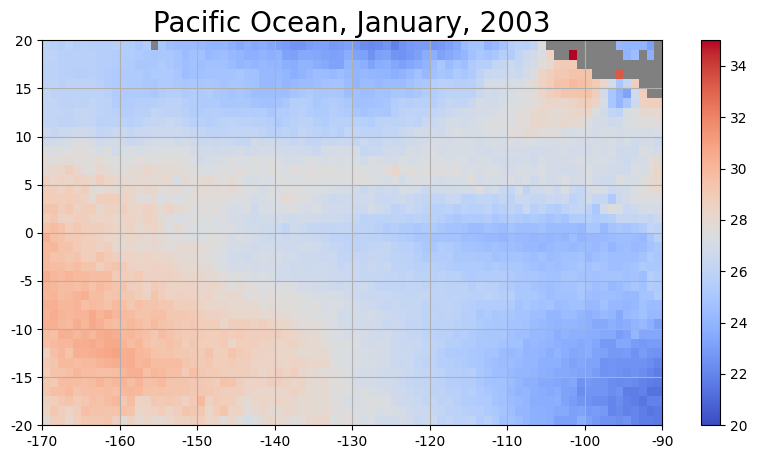

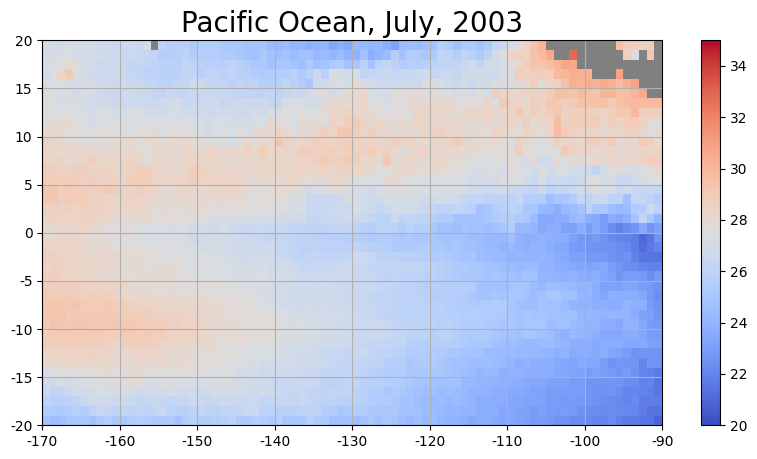

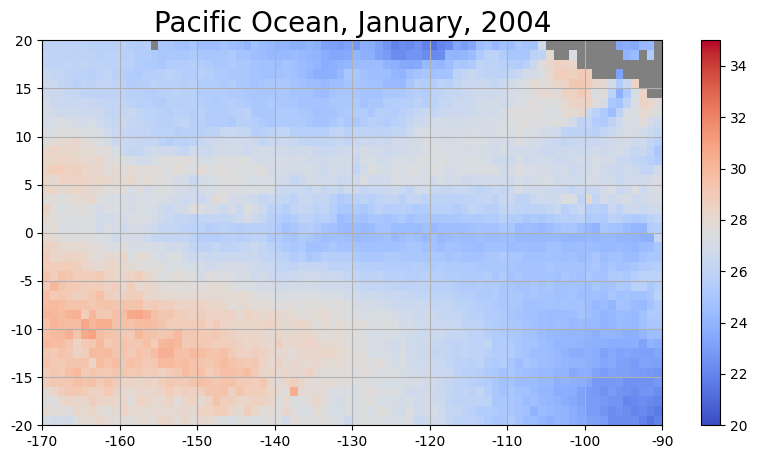

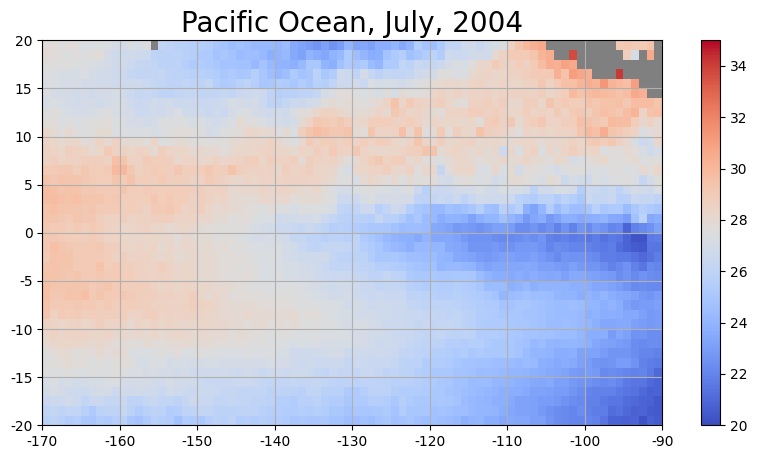

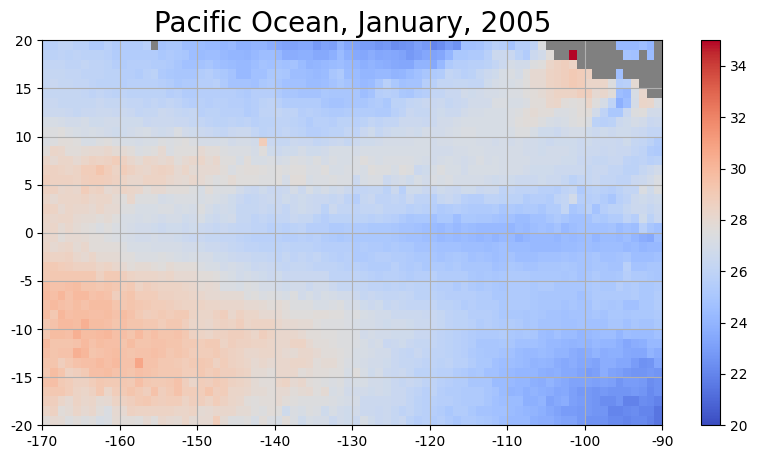

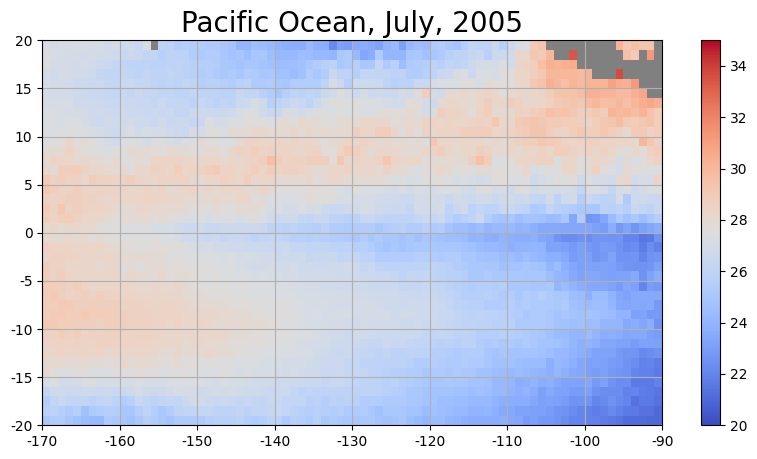

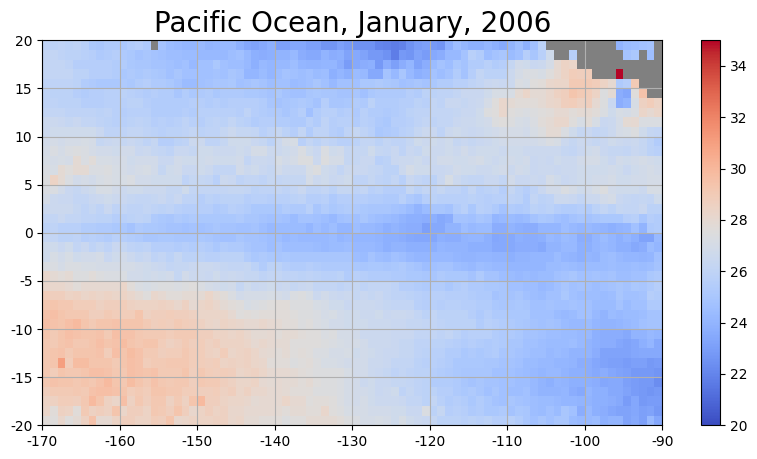

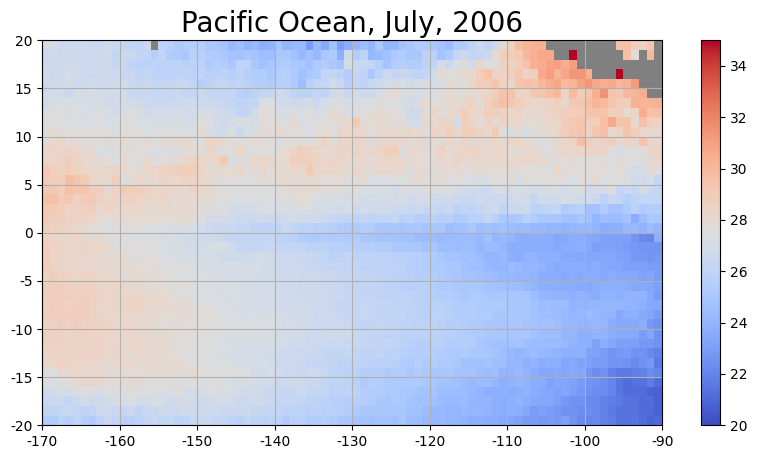

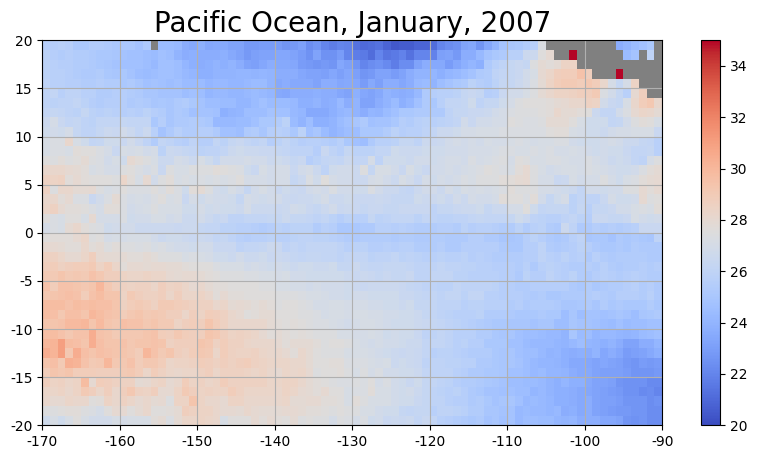

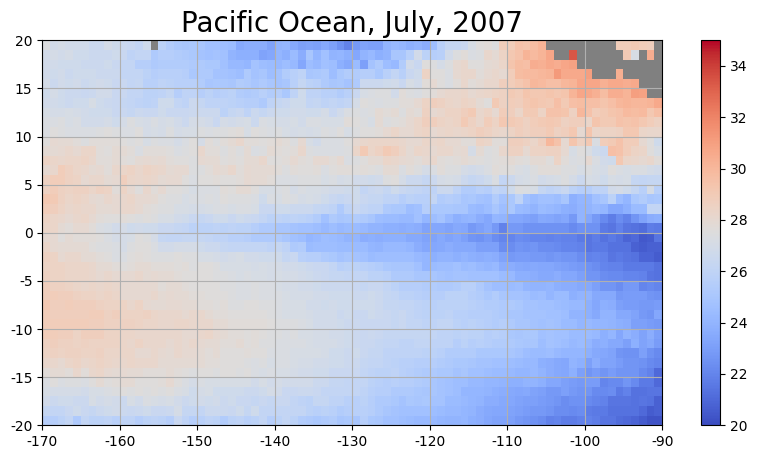

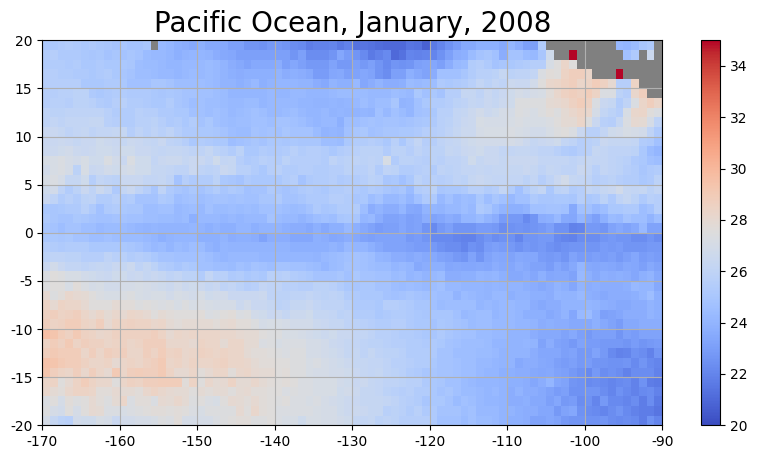

In [ ]:
year = [2003,2003,2004,2004,2005,2005,2006,2006,2007,2007,2008,2008,2009,2009]
month = ['January','July','January','July','January','July','January','July','January','July','January','July','January','July']
for j,i in enumerate([0,6,12,18,24,30,36,42,48,54,60]):
  '''
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')


  loadingpca = np.reshape(np.array(result_data_imputed_ind)[i],(np.array(result_data_imputed_ind).shape[1]*np.array(result_data_imputed_ind).shape[2]))
  loadingpca[zero_indices_union_ind] = np.nan
  loadingpca = np.reshape(loadingpca, (40,80))
  loadingpca = np.flipud(loadingpca)
  img = axes.pcolormesh(np.reshape(loadingpca, (40,80)), cmap=cmap, vmax = 35, vmin = 20)



  axes.set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
  axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
  axes.grid()
  fig.colorbar(img, ax=axes)
  plt.show()

  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')


  loadingpca = np.reshape(np.array(result_data_imputed_alt)[i],(np.array(result_data_imputed_alt).shape[1]*np.array(result_data_imputed_alt).shape[2]))
  loadingpca[zero_indices_union_alt] = np.nan
  loadingpca = np.reshape(loadingpca, (40,80))
  loadingpca = np.flipud(loadingpca)
  img = axes.pcolormesh(np.reshape(loadingpca, (40,80)), cmap=cmap, vmax = 35, vmin = 20)



  axes.set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
  axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
  axes.grid()
  fig.colorbar(img, ax=axes)
  plt.show()
  '''
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')


  loadingpca = np.reshape(np.array(result_data_imputed_pac)[i],(np.array(result_data_imputed_pac).shape[1]*np.array(result_data_imputed_pac).shape[2]))
  loadingpca[zero_indices_union_pac] = np.nan
  loadingpca = np.reshape(loadingpca, (40,80))
  loadingpca = np.flipud(loadingpca)
  img = axes.pcolormesh(np.reshape(loadingpca, (40,80)), cmap=cmap, vmax = 35, vmin = 20)


  axes.set_title(fr'Pacific Ocean, {month[j]}, {year[j]}',fontsize = 20)
  axes.set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
  axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
  axes.grid()
  fig.colorbar(img, ax=axes)
  plt.show()

In [ ]:
loadingpca.shape

(40, 80)

<ipython-input-7-e88653b1ed10>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-7-e88653b1ed10>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-7-e88653b1ed10>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])


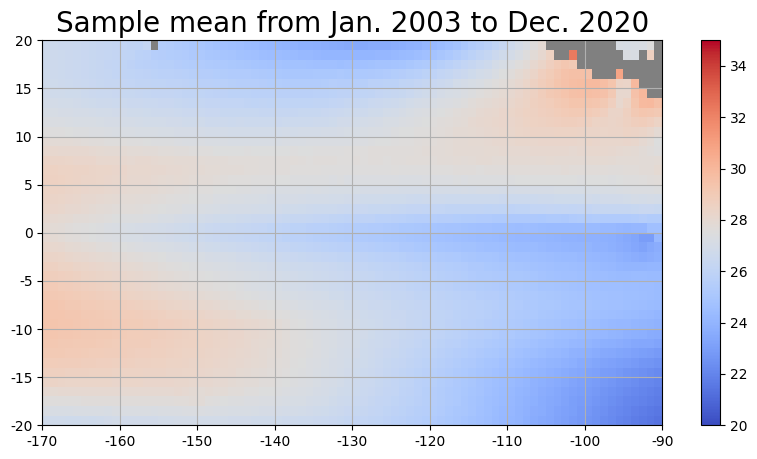

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad(color='gray')

mean = np.mean(result_data_imputed_pac,axis = 0)

loadingpca = np.reshape(mean,(np.array(result_data_imputed_pac).shape[1]*np.array(result_data_imputed_pac).shape[2]))
loadingpca[zero_indices_union_pac] = np.nan
loadingpca = np.reshape(loadingpca, (40,80))
loadingpca = np.flipud(loadingpca)
img = axes.pcolormesh(loadingpca, cmap=cmap, vmax = 35, vmin = 20)


axes.set_title(fr'Sample mean from Jan. 2003 to Dec. 2020',fontsize = 20)
axes.set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
axes.grid()
fig.colorbar(img, ax=axes)
plt.show()

<ipython-input-8-6884ef9bb581>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-8-6884ef9bb581>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-8-6884ef9bb581>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])


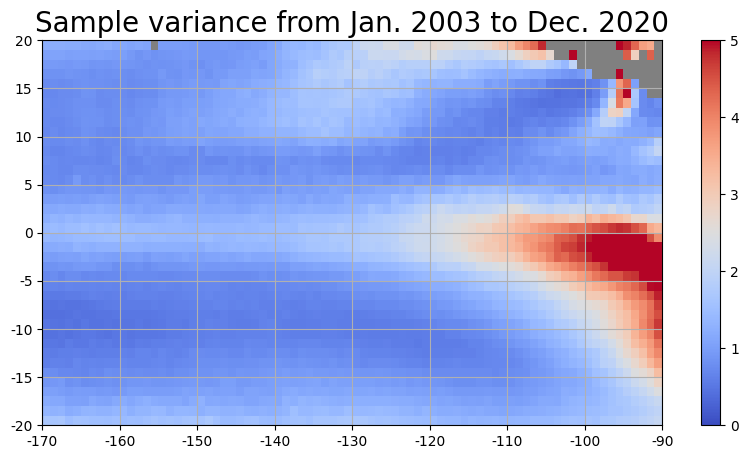

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad(color='gray')

variance = np.var(result_data_imputed_pac,axis = 0)

loadingpca2 = np.reshape(variance,(np.array(result_data_imputed_pac).shape[1]*np.array(result_data_imputed_pac).shape[2]))
loadingpca2[zero_indices_union_pac] = np.nan
loadingpca2 = np.reshape(loadingpca2, (40,80))
loadingpca2 = np.flipud(loadingpca2)
img = axes.pcolormesh(loadingpca2, cmap=cmap, vmax = 5, vmin = 0)


axes.set_title(fr'Sample variance from Jan. 2003 to Dec. 2020',fontsize = 20)
axes.set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
axes.set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
axes.grid()
fig.colorbar(img, ax=axes)
plt.show()

<ipython-input-22-8b2d78f26e62>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


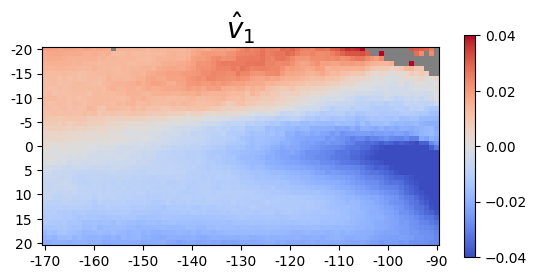

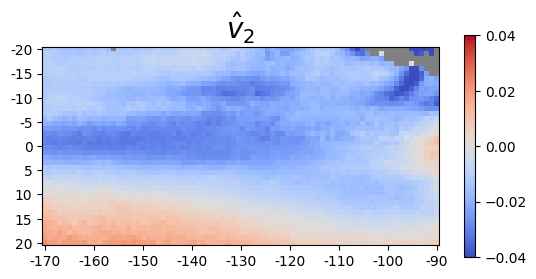

In [ ]:
pca1 = PCA(n_components=2)
Y22 = np.reshape(result_data_imputed_ind,(-1,result_data_1_ind.shape[1]*result_data_1_ind.shape[2]))
pca1.fit(Y22)

pca2 = PCA(n_components=2)
Y23 = np.reshape(result_data_imputed_alt,(-1,result_data_1_alt.shape[1]*result_data_1_alt.shape[2]))
pca2.fit(Y23)

pca3 = PCA(n_components=2)
Y24 = np.reshape(result_data_imputed_pac,(-1,result_data_1_pac.shape[1]*result_data_1_pac.shape[2]))
pca3.fit(Y24)
'''
for i in range(2):
  loadingpca = pca1.components_[i]
  loadingpca[zero_indices_union_ind] = np.nan
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')
  plt.imshow(np.reshape(loadingpca,(40,80)) ,cmap=cmap, vmax = 0.04, vmin = -0.04)


  plt.title(fr'PC loadning, {i+1}, Indian Ocean, Expained VAR: {np.round(pca1.explained_variance_ratio_[i],2)}')


  #axes[i, 0].set_xticks(np.linspace(0, dimx-1, 9))
  #axes[i, 0].set_yticks(np.linspace(0, dimy-1, 5))

  plt.xticks(np.linspace(0, 79, 9), [40, 50, 60, 70, 80, 90, 100, 110, 120])
  plt.yticks(np.linspace(0, 39, 9), [-20, -15, -10, -5, 0, 5, 10, 15, 20])
  plt.colorbar()
  plt.show()

for i in range(2):
  loadingpca = pca2.components_[i]
  loadingpca[zero_indices_union_alt] = np.nan
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')
  plt.imshow(np.reshape(loadingpca,(40,80)) ,cmap=cmap, vmax = 0.04, vmin = -0.04)


  plt.title(fr'PC loadning, {i+1}, Atlantic Ocean, Expained VAR: {np.round(pca2.explained_variance_ratio_[i],2)}')


  #axes[i, 0].set_xticks(np.linspace(0, dimx-1, 9))
  #axes[i, 0].set_yticks(np.linspace(0, dimy-1, 5))

  plt.xticks(np.linspace(0, 79, 9), [-70, -60, -50, -40, -30, -20, -10, 0, 10])
  plt.yticks(np.linspace(0, 39, 9), [-20, -15, -10, -5, 0, 5, 10, 15, 20])
  plt.colorbar()
  plt.show()
'''

for i in range(2):
  loadingpca = pca3.components_[i]
  loadingpca[zero_indices_union_pac] = np.nan
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')
  plt.imshow(np.reshape(loadingpca,(40,80)) ,cmap=cmap, vmax = 0.04, vmin = -0.04)

  #, Pacific Ocean, Expained VAR: {np.round(pca3.explained_variance_ratio_[i],2)}
  plt.title(fr'$\hat{{v}}_{i+1}$',fontsize = 20)

  '''
  axes[i, 0].set_xticks(np.linspace(0, dimx-1, 9))
  axes[i, 0].set_yticks(np.linspace(0, dimy-1, 5))
  '''

  plt.xticks(np.linspace(0, 79, 9), [-170, -160, -150, -140, -130, -120, -110, -100, -90])
  plt.yticks(np.linspace(0, 39, 9), [-20, -15, -10, -5, 0, 5, 10, 15, 20])
  plt.colorbar(shrink = 0.6)
  plt.show()

### cae

In [ ]:

def cae11(dimx,dimy, kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same'):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm

  inputs = keras.Input((dimx,dimy,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(inputs)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = False, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(dimx*dimy,use_bias = False, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1),kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)))(code)
  x = layers.Reshape((dimx,dimy,1))(x)

  outputs = layers.Flatten()(x)
  cae1 = Model(inputs = inputs, outputs = outputs)
  cae1.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory1 = CAELossHistory()
  return cae1, CAEhistory1

def cae31(dimx,dimy, kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same'):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None

  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  inputs = keras.Input((dimx,dimy,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(inputs)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(x)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = False, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(dimx*dimy,use_bias = False, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1),kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)))(code)
  x = layers.Reshape((dimx,dimy,1))(x)

  outputs = layers.Flatten()(x)
  cae3 = Model(inputs = inputs, outputs = outputs)
  cae3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory3 = CAELossHistory()
  return cae3, CAEhistory3

def cae51(dimx,dimy, kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same'):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  inputs = keras.Input((dimx,dimy,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(inputs)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]))(x)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = False, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(dimx*dimy,use_bias = False, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1),kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)))(code)
  x = layers.Reshape((dimx,dimy,1))(x)

  outputs = layers.Flatten()(x)
  cae5 = Model(inputs = inputs, outputs = outputs)
  cae5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory5 = CAELossHistory()
  return cae5, CAEhistory5
'''
def cae70(dimx,dimy, kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same'):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  b = np.zeros((kernelshape0,kernelshape0))
  b[int(kernelshape0/2-0.5),int(kernelshape0/2-0.5)] = 1

  inputs = keras.Input((dimx,dimy,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(inputs)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = False, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(dimx*dimy,use_bias = False, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1),kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)))(code)
  x = layers.Reshape((dimx,dimy,1))(x)
  outputs = layers.Flatten()(x)
  cae7 = Model(inputs = inputs, outputs = outputs)
  cae7.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 10), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory7 = CAELossHistory()
  return cae7, CAEhistory7
'''
def sae02(dimx,dimy, activations , j ,ncomp, pcloading):
  class SAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  inputs1 = keras.Input((dimx,dimy,1))
  x1 = layers.Reshape((dimx*dimy,))(inputs1)
  code1 = layers.Dense(ncomp,name = 'code',use_bias = False, kernel_regularizer=tf.keras.regularizers.L1(j), activation = activations, kernel_initializer = tf.keras.initializers.Constant(pcloading))(x1)
  outputs2 = layers.Dense(dimx*dimy,name = 'reconstruct',use_bias = False, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1),kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)))(code1)
  sae = Model(inputs = inputs1, outputs = outputs2)
  sae.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  SAEhistory = SAELossHistory()
  return sae, SAEhistory


### 2D functions

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import keras.backend as K
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd



#lambdas = [0,1]
lambdas = [0,0.0001,0.0005,0.001]
#ambdas = [0]
#lambdas = np.concatenate([np.repeat(0.0,7),np.repeat(0.05,7)])
size = [11,15,19]
ncomps = [2,3,4,5,6,7,8]
def spatialAE2D(Y, ncomp = ncomps, activations = None, epoches = 1200, dx = 0.1,lambda1 = lambdas,kernelshape = size, conti = 1, padding0 = 'same', data_idx = 'Indiean Ocean'):
  xdim = int(np.sqrt(Y.shape[1]))
  dimx, dimy = Y.shape[1],Y.shape[2]
  dims = Y.shape[1]
  Y = np.reshape(Y,(-1,Y.shape[1]*Y.shape[2]))

  for i in range(Y.shape[1]):
     Y[:,i] = Y[:,i] - np.mean(Y[:,i])


  Y_train, Y_test = train_test_split(Y, test_size = 100, random_state=42)
  Y_train, Y_valid = train_test_split(Y_train, train_size = 50, random_state=30)
  Y_train = Y_train*1.0
  Y_valid = Y_valid*1.0
  Y_test = Y_test*1.0
  #lambda_train,lambda_test = lambda_train*1.0 ,lambda_test*1.0


  loss31 = []
  loss21 = []
  loss41 = []
  loss33 = []
  loss23 = []
  loss43 = []
  loss35 = []
  loss25 = []
  loss45 = []
  gridsearchcae1 = []
  gridsearchcae3 = []
  gridsearchcae5 = []

  ressaes = []
  gridsearchsae = []
  respcas = []
  resspcas = []
  respcavalids = []
  resspcavalids = []
  gridsearchspca = []

  fubae21 = []
  fubae31 = []
  fubae41 = []
  fubae23 = []
  fubae33 = []
  fubae43 = []
  fubae25 = []
  fubae35 = []
  fubae45 = []
  fubsaes = []
  fubspcas = []
  sfubindex = []
  cfub1index = []
  cfub3index = []
  cfub5index = []

  #儲存var跟testingMSE
  pcavar = []
  spcavar = []
  saevar = []
  saecvar1 = []
  saecvar3 = []
  saecvar5 = []
  trespca = []
  tresspca = []
  tressae = []
  tressaec1 = []
  tressaec3 = []
  tressaec5 = []
  vrespca = []
  vresspca = []
  vressae = []
  vressaec1 = []
  vressaec3 = []
  vressaec5 = []
  gridindex = 0
  for ncomp in ncomps:
    start_comp = time.time()
    for kernelshape0 in kernelshape:
      lambdaindex = 0
      # 計時開始

      for j in lambda1:
        gridindex = gridindex + 1
        #PCA
        pca = PCA(n_components=ncomp)
        pca.fit(Y_train)
        pcloading = np.transpose(pca.components_)
        #ppca = pcloading.dot(np.transpose(pcloading))
        #ppca = pcloading.dot(np.diag(pca.singular_values_)).dot(np.transpose(pcloading))
        pctrain = pca.fit_transform(Y_train)
        pctest = pca.transform(Y_test)
        pcvalid = pca.transform(Y_valid)
        reconpcatrain = pca.inverse_transform(pctrain)
        reconpcatest = pca.inverse_transform(pctest)
        reconpcavalid = pca.inverse_transform(pcvalid)
        respcatrain = np.mean(tf.keras.metrics.mean_squared_error(reconpcatrain,Y_train))
        respcatest = np.mean(tf.keras.metrics.mean_squared_error(reconpcatest,Y_test))
        respcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconpcavalid,Y_valid))
        respcas.append(respcatest)
        respcavalids.append(respcavalid)
        pcalhat = np.mean(reconpcatest,axis = 0)
        pcavar.append(pca.explained_variance_)
        #pcatestgof = np.mean(np.mean((reconpcatest-lambda_test)**2))


        #SPCA
        '''
        spca = SparsePCA(n_components=ncomp,alpha = j*25, max_iter = 50)
        spca.fit(Y_train)
        spcloading = np.transpose(spca.components_)
        spctrain = spca.fit_transform(Y_train)
        spctest = spca.transform(Y_test)
        spcvalid = spca.transform(Y_valid)
        #spccov = pd.DataFrame.cov(pd.DataFrame(spctrain))
        reconspcatrain = spca.inverse_transform(spctrain)
        reconspcatest = spca.inverse_transform(spctest)
        reconspcavalid = spca.inverse_transform(spcvalid)
        #pspca = spcloading.dot(np.transpose(spcloading).dot(spcloading)).dot(np.transpose(spcloading))
        #pspca = spcloading.dot(spccov).dot(np.transpose(spcloading))
        resspcatrain = np.mean(tf.keras.metrics.mean_squared_error(reconspcatrain,Y_train))
        resspcatest = np.mean(tf.keras.metrics.mean_squared_error(reconspcatest,Y_test))
        resspcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
        resspcas.append(resspcatest)
        gridsearchspca.append(resspcatest)
        resspcavalids.append(resspcavalid)
        spcalhat = np.mean(reconspcatest,axis = 0)
        '''

        #spcatestgof = np.mean(np.mean((reconspcatest-lambda_test)**2))
        #print('SPCA loading',np.transpose(spcloading).dot(spcloading))
        #CAE
        cae1, CAEhistory1 = cae11(dimx,dimy , kernelshape0 , activations , j ,ncomp, pcloading)
        cae3, CAEhistory3 = cae31(dimx,dimy , kernelshape0 , activations , j ,ncomp, pcloading)
        cae5, CAEhistory5 = cae51(dimx,dimy , kernelshape0 , activations , j ,ncomp, pcloading)
        #cae7, CAEhistory7 = cae71(dimx,dimy , kernelshape0 , activations , j ,ncomp, pcloading, padding0)
        sae, SAEhistory = sae02(dimx,dimy , activations , j/10 ,ncomp, pcloading)
        early_stopping = EarlyStopping(monitor='loss', min_delta=0.1, patience=20)
        '''
        plt.plot(pcloading)
        plt.title(fr'$v_{{PCA,i}}$', fontsize = 20)
        plt.legend([r'$v_{{PCA,1}}$',r'$v_{{PCA,2}}$'],fontsize = 20)
        plt.show()
        '''

        #weight loading
        lambdaindex = lambdaindex+1
        j2 = np.array(lambda1)
        if lambdaindex > 1:
          j3 = j2[lambdaindex-2]

          start_timeload = time.time()

          cae1.load_weights('./cae1%f.h5'%j3)
          #cae3.load_weights('./cae3%f.h5'%j3)
          #cae5.load_weights('./cae5%f.h5'%j3)
          #cae7.load_weights('./cae7%f.h5'%j3)
          sae.load_weights('./sae%f.h5'%j3)
          end_timeload = time.time()
          elapsed_timeload2 = start_timeload - end_timeload
          print(f"第{lambdaindex}個lambda LOAD model time: {elapsed_timeload2} 秒")

          '''
          #SAE plot
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()
          '''
          '''
          #SAEC plot
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae1.layers[3].weights[0].numpy())
            plt.title(fr'$v_{{E,i}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{1}}^{{(CE)}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
            plt.title(fr'$v_{{DC,i}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()
          '''

          start_timetrain1 = time.time()
          cae1.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory1,early_stopping])
          end_timetrain1 = time.time()
          elapsed_timetrain2 = start_timetrain1 - end_timetrain1
          print(f"第{lambdaindex}個lambda train 1st model time: {elapsed_timetrain2} 秒")
          conv1_weights = cae1.layers[1].get_weights()
          dense_weights = cae1.layers[3].get_weights()
          dense_weights2 = cae1.layers[4].get_weights()

          cae3.layers[1].set_weights(conv1_weights)
          cae3.layers[4].set_weights(dense_weights)
          cae3.layers[5].set_weights(dense_weights2)

          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            print(np.sum(cae1.layers[1].get_weights()[0]**2))

            plt.plot(cae1.layers[3].weights[0].numpy())
            plt.title(fr'$v_{{E,i}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
            plt.title(fr'$v_{{DC,i}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()

            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae3.layers[4].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()
          '''



          start_timetrain3 = time.time()
          cae3.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory3,early_stopping])

          end_timetrain3 = time.time()
          elapsed_timetrain3 = start_timetrain3 - end_timetrain3
          print(f"第{lambdaindex}個lambda train 2nd model time: {elapsed_timetrain3} 秒")
          conv1_weights = cae3.layers[1].get_weights()
          conv1_weights2 = cae3.layers[2].get_weights()
          dense_weights = cae3.layers[4].get_weights()
          dense_weights2 = cae3.layers[5].get_weights()
          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae3.layers[4].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()
          '''





          cae5.layers[1].set_weights(conv1_weights)
          cae5.layers[2].set_weights(conv1_weights2)
          cae5.layers[6].set_weights(dense_weights)
          cae5.layers[7].set_weights(dense_weights2)



          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()


            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{4}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae5.layers[6].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()

            plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()
          '''



          start_timetrain5 = time.time()
          cae5.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory5,early_stopping])
          end_timetrain5 = time.time()
          elapsed_timetrain5 = start_timetrain5 - end_timetrain5
          print(f"第{lambdaindex}個lambda train 3rd model time: {elapsed_timetrain5} 秒")
          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{m}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae5.layers[6].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()

            plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()


          '''

          #cae7.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0, batch_size = Y_train.shape[0],callbacks = [CAEhistory7],early_stopping)

          start_timetrain0 = time.time()
          sae.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [SAEhistory,early_stopping])
          end_timetrain0 = time.time()
          elapsed_timetrain0 = start_timetrain0 - end_timetrain0
          print(f"第{lambdaindex}個lambda train SAE model time: {elapsed_timetrain0} 秒")
          '''
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()
          '''



          start_timesave2 = time.time()

          checkpoint_path1 = './cae1%f.h5'%j
          checkpoint_path3 = './cae3%f.h5'%j
          checkpoint_path5 = './cae5%f.h5'%j
          #checkpoint_path7 = './cae7%f.h5'%j
          checkpoint_path2 = './sae%f.h5'%j
          cae1.save_weights(checkpoint_path1)
          #cae3.save_weights(checkpoint_path3)
          #cae5.save_weights(checkpoint_path5)
          #cae7.save_weights(checkpoint_path7)
          sae.save_weights(checkpoint_path2)
          end_timesave2 = time.time()
          elapsed_timesave2 = start_timesave2 - end_timesave2
          print(f"第{lambdaindex}個lambda save model time: {elapsed_timesave2} 秒")

          '''
          cae_reconstruct1 = cae1.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct1test = cae1.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct1valid = cae1.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

          cae_reconstruct3 = cae3.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct3test = cae3.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct3valid = cae3.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

          cae_reconstruct5 = cae5.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct5test = cae5.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct5valid = cae5.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

          cae_reconstruct7 = cae7.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7test = cae7.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7valid = cae7.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,1)), verbose = 0)

          sae_reconstruct = sae.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          sae_reconstructtest = sae.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          sae_reconstructvalid = sae.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)
          '''

        else:
          '''
          #SAE plot
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()

          '''
          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            #SAEC plot
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae1.layers[3].weights[0].numpy())
            plt.title(fr'$v_{{E,i}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
            plt.title(fr'$v_{{DC,i}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()
          '''


          start_timetrain1 = time.time()
          cae1.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory1,early_stopping])
          end_timetrain1 = time.time()
          elapsed_timetrain2 = start_timetrain1 - end_timetrain1
          print(f"第{lambdaindex}個lambda train 1st model time: {elapsed_timetrain2} 秒")

          conv1_weights = cae1.layers[1].get_weights()
          dense_weights = cae1.layers[3].get_weights()
          dense_weights2 = cae1.layers[4].get_weights()

          cae3.layers[1].set_weights(conv1_weights)
          cae3.layers[4].set_weights(dense_weights)
          cae3.layers[5].set_weights(dense_weights2)

          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$C_{1,1}$'],fontsize = 20)
            plt.colorbar()
            plt.show()

            print(np.sum(cae1.layers[1].get_weights()[0]**2))

            plt.plot(cae1.layers[3].weights[0].numpy())
            plt.title(fr'$v_{{E,i}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
            plt.title(fr'$v_{{DC,i}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()

            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae3.layers[4].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()



          '''

          start_timetrain3 = time.time()
          cae3.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory3,early_stopping])

          end_timetrain3 = time.time()
          elapsed_timetrain3 = start_timetrain3 - end_timetrain3
          print(f"第{lambdaindex}個lambda train 2nd model time: {elapsed_timetrain3} 秒")


          conv1_weights = cae3.layers[1].get_weights()
          conv1_weights2 = cae3.layers[2].get_weights()
          dense_weights = cae3.layers[4].get_weights()
          dense_weights2 = cae3.layers[5].get_weights()

          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae3.layers[4].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()
            plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()

          '''
          cae5.layers[1].set_weights(conv1_weights)
          cae5.layers[2].set_weights(conv1_weights2)
          cae5.layers[6].set_weights(dense_weights)
          cae5.layers[7].set_weights(dense_weights2)
          '''



          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()


            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{4}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae5.layers[6].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()

            plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()
          '''

          start_timetrain5 = time.time()
          cae5.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory5,early_stopping])
          end_timetrain5 = time.time()
          elapsed_timetrain5 = start_timetrain5 - end_timetrain5
          print(f"第{lambdaindex}個lambda train 3rd model time: {elapsed_timetrain5} 秒")
          '''
          if j in np.round(np.linspace(0, 0.2, 3)/100,4):
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()


            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{4}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.plot(cae5.layers[6].get_weights()[0])
            plt.title(fr'$v_{{E,i}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{E,1}}$',r'$v_{{E,2}}$'],fontsize = 20)
            plt.show()

            plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
            plt.title(fr'$v_{{DC,i}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$v_{{DC,1}}$',r'$v_{{DC,2}}$'],fontsize = 20)
            plt.show()


          '''
          #cae7.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0, batch_size = Y_train.shape[0],callbacks = [CAEhistory7],early_stopping)


          start_timetrain0 = time.time()
          sae.fit(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)),Y_train, epochs = epoches, verbose = 0,callbacks = [SAEhistory,early_stopping])
          end_timetrain0 = time.time()
          elapsed_timetrain0 = start_timetrain0 - end_timetrain0
          print(f"第{lambdaindex}個lambda train SAE model time: {elapsed_timetrain0} 秒")

          '''
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()
          '''

          start_timesave1 = time.time()

          checkpoint_path1 = './cae1%f.h5'%j
          checkpoint_path3 = './cae3%f.h5'%j
          checkpoint_path5 = './cae5%f.h5'%j
          #checkpoint_path7 = './cae7%f.h5'%j
          checkpoint_path2 = './sae%f.h5'%j
          cae1.save_weights(checkpoint_path1)
          #cae3.save_weights(checkpoint_path3)
          #cae5.save_weights(checkpoint_path5)
          #cae7.save_weights(checkpoint_path7)
          sae.save_weights(checkpoint_path2)

          end_timesave1 = time.time()
          elapsed_timesave1 = start_timesave1 - end_timesave1
          print(f"第一個lambda save model time: {elapsed_timesave1} 秒")
          '''

          cae_reconstruct1 = cae1.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct1test = cae1.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct1valid = cae1.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

          cae_reconstruct3 = cae3.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct3test = cae3.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct3valid = cae3.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

          cae_reconstruct5 = cae5.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct5test = cae5.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          cae_reconstruct5valid = cae5.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

          cae_reconstruct7 = cae7.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7test = cae7.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7valid = cae7.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,1)), verbose = 0)

          sae_reconstruct = sae.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
          sae_reconstructtest = sae.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
          sae_reconstructvalid = sae.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)
          '''

        cae_get_code_layer_output1 = K.function([cae1.layers[0].input],[cae1.layers[3].output])
        cae_get_code_layer_output3 = K.function([cae3.layers[0].input],[cae3.layers[4].output])
        cae_get_code_layer_output5 = K.function([cae5.layers[0].input],[cae5.layers[6].output])
        #cae_get_code_layer_output7 = K.function([cae7.layers[0].input],[cae7.layers[9].output])
        sae_get_code_layer_output = K.function([sae.layers[0].input],[sae.layers[2].output])
        caecode1 = cae_get_code_layer_output1(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy,1)))[0]
        caecode3 = cae_get_code_layer_output3(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy,1)))[0]
        caecode5 = cae_get_code_layer_output5(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy,1)))[0]
        #caecode7 = cae_get_code_layer_output7(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy,1)))[0]
        saecode = sae_get_code_layer_output(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy,1)))[0]
        if activations == 'linear':
          print('using',activations,'estimating the loadings')
          #CAE estimation
          eaephi1 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode1)
          eaephi3 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode3)
          eaephi5 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode5)
          #eaephi7 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode7)
          saephi = sae.layers[2].weights[0].numpy()
        else:
          start_timeest = time.time()
          print('using',activations,'estimating the loadings')
          layer_output = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
          layer_output1 = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

          layer_output2 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
          layer_output3 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

          layer_output4 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
          layer_output5 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

          layer_output6 = sae_get_code_layer_output(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
          layer_output7 = sae_get_code_layer_output(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]
          end_timeest = time.time()
          elapsed_timeest = start_timeest - end_timeest
          print(f"{lambdaindex} estimation time: {elapsed_timeest} 秒")
          #layer_output8 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
          #layer_output9 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

          #gradient = layer_output
          eaephi1 = (layer_output-layer_output1)/dx
          eaephi3 = (layer_output2-layer_output3)/dx
          eaephi5 = (layer_output4-layer_output5)/dx
          saephi = (layer_output6-layer_output7)/dx

        for i in range(ncomp):
          eaephi1[:,i] = eaephi1[:,i]/np.sqrt(np.sum(eaephi1[:,i]**2))
          eaephi3[:,i] = eaephi3[:,i]/np.sqrt(np.sum(eaephi3[:,i]**2))
          eaephi5[:,i] = eaephi5[:,i]/np.sqrt(np.sum(eaephi5[:,i]**2))
          #eaephi7[:,i] = eaephi7[:,i]/np.sqrt(np.sum(eaephi7[:,i]**2))
          saephi[:,i] = saephi[:,i] /np.sqrt(np.sum(saephi[:,i]**2))
        '''
        cae_reconstruct1 = Y_train.dot(eaephi1).dot(np.transpose(eaephi1))
        cae_reconstruct1test = Y_test.dot(eaephi1).dot(np.transpose(eaephi1))
        cae_reconstruct1valid = Y_valid.dot(eaephi1).dot(np.transpose(eaephi1))

        cae_reconstruct3 = Y_train.dot(eaephi3).dot(np.transpose(eaephi3))
        cae_reconstruct3test = Y_test.dot(eaephi3).dot(np.transpose(eaephi3))
        cae_reconstruct3valid = Y_valid.dot(eaephi3).dot(np.transpose(eaephi3))

        cae_reconstruct5 = Y_train.dot(eaephi5).dot(np.transpose(eaephi5))
        cae_reconstruct5test = Y_test.dot(eaephi5).dot(np.transpose(eaephi5))
        cae_reconstruct5valid = Y_valid.dot(eaephi5).dot(np.transpose(eaephi5))

        sae_reconstruct = Y_train.dot(saephi).dot(np.transpose(saephi))
        sae_reconstructtest = Y_test.dot(saephi).dot(np.transpose(saephi))
        sae_reconstructvalid = Y_valid.dot(saephi).dot(np.transpose(saephi))
        '''
        cae_reconstruct1 = cae1.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
        cae_reconstruct1test = cae1.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
        cae_reconstruct1valid = cae1.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

        cae_reconstruct3 = cae3.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
        cae_reconstruct3test = cae3.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
        cae_reconstruct3valid = cae3.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

        cae_reconstruct5 = cae5.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
        cae_reconstruct5test = cae5.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
        cae_reconstruct5valid = cae5.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

        sae_reconstruct = sae.predict(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)), verbose = 0)
        sae_reconstructtest = sae.predict(np.reshape(Y_test,(Y_test.shape[0],dimx,dimy)), verbose = 0)
        sae_reconstructvalid = sae.predict(np.reshape(Y_valid,(Y_valid.shape[0],dimx,dimy)), verbose = 0)

        #Loss value calculating
        #caeres1 = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1,Y_train))
        #caeres3 = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3,Y_train))
        #caeres5 = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5,Y_train))
        saeres = np.mean(tf.keras.metrics.mean_squared_error(sae_reconstruct,Y_train))
        caeres1test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1test,Y_test))
        caeres3test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3test,Y_test))
        caeres5test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5test,Y_test))
        #caeres7test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct7test,Y_test))
        saerestest = np.mean(tf.keras.metrics.mean_squared_error(sae_reconstructtest,Y_test))
        caeres1valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1valid,Y_valid))
        caeres3valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3valid,Y_valid))
        caeres5valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5valid,Y_valid))
        #caeres7valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct7valid,Y_valid))
        saeresvalid = np.mean(tf.keras.metrics.mean_squared_error(sae_reconstructvalid,Y_valid))



        cae1lhat = np.mean(cae_reconstruct1test,axis = 0)
        #cae1testgof = np.mean(np.mean((cae_reconstruct1test-lambda_test)**2))
        cae3lhat = np.mean(cae_reconstruct3test,axis = 0)
        #cae3testgof = np.mean(np.mean((cae_reconstruct3test-lambda_test)**2))
        cae5lhat = np.mean(cae_reconstruct5test,axis = 0)
        #cae5testgof = np.mean(np.mean((cae_reconstruct5test-lambda_test)**2))
        '''
        cae7lhat = np.mean(cae_reconstruct7test,axis = 0)
        cae7testgof = np.mean(np.mean((cae_reconstruct7test-lambda_test)**2))
        '''
        saelhat = np.mean(sae_reconstructtest,axis = 0)
        #saetestgof = np.mean(np.mean((sae_reconstructtest-lambda_test)**2))

        #print(pcatestgof,spcatestgof,saetestgof,cae1testgof,cae3testgof,cae5testgof)
        #code

        #print(saecode.shape)
        ccode1mat = np.transpose(caecode1).dot(caecode1)
        ccode3mat = np.transpose(caecode3).dot(caecode3)
        ccode5mat = np.transpose(caecode5).dot(caecode5)
        #ccode7mat = np.transpose(caecode7).dot(caecode7)
        scodemat = np.transpose(saecode).dot(saecode)
        '''
        print('CAE1 cov',ccode1mat/Y_train.shape[0])
        print('CAE3 cov',ccode3mat/Y_train.shape[0])
        print('CAE5 cov',ccode5mat/Y_train.shape[0])
        print('SAE cov',scodemat/Y_train.shape[0])
        '''
        c1sortindex = np.argsort(np.diag(ccode1mat))[::-1]
        c3sortindex = np.argsort(np.diag(ccode3mat))[::-1]
        c5sortindex = np.argsort(np.diag(ccode5mat))[::-1]
        #c7sortindex = np.argsort(np.diag(ccode7mat))[::-1]
        ssortindex = np.argsort(np.diag(scodemat))[::-1]
        '''
        print(scodemat, ssortindex)
        print(ccode1mat, c1sortindex)
        print(ccode3mat, c3sortindex)
        print(ccode5mat, c5sortindex)
        '''
        '''
        caecov1 = pd.DataFrame.cov(pd.DataFrame(caecode1))
        caecov3 = pd.DataFrame.cov(pd.DataFrame(caecode3))
        caecov5 = pd.DataFrame.cov(pd.DataFrame(caecode5))
        saecov = pd.DataFrame.cov(pd.DataFrame(saecode))
        '''

        '''
        #daephi = np.linalg.inv(np.transpose(saecode).dot(saecode)).dot(np.transpose(saecode)).dot(sae_reconstruct)
        daephi = tf.transpose(sae.layers[3].weights[0].numpy())
        try:
          psae = saephi.dot(np.linalg.inv(np.transpose(saephi).dot(saephi))).dot(np.transpose(saephi))
          fubsae = np.sum((p-psae)**2)
        except:
          fubsae = 100
          print('SAE Singular matrix')
        try:
          pcae1 = eaephi1.dot(np.linalg.inv(np.transpose(eaephi1).dot(eaephi1))).dot(np.transpose(eaephi1))
          fubcae1 = np.sum((p-pcae1)**2)
        except:
          fubcae1 = 100
          print('CAE1 Singular matrix')
        try:
          pcae3 = eaephi3.dot(np.linalg.inv(np.transpose(eaephi3).dot(eaephi3))).dot(np.transpose(eaephi3))
          fubcae3 = np.sum((p-pcae3)**2)
        except:
          fubcae3 = 100
          print('CAE2 Singular matrix')
        try:
          pcae5 = eaephi5.dot(np.linalg.inv(np.transpose(eaephi5).dot(eaephi5))).dot(np.transpose(eaephi5))
          fubcae5 = np.sum((p-pcae5)**2)
        except:
          fubcae5 = 100
          print('CAE4 Singular matrix')

        try:
          pcae7 = eaephi7.dot(np.linalg.inv(np.transpose(eaephi7).dot(eaephi7))).dot(np.transpose(eaephi7))
          fubcae7 = np.sum((p-pcae7)**2)
        except:
          fubcae7 = 100
          print('CAE7 Singular matrix')
        '''






        '''
        pcae1 = eaephi1.dot(caecov1).dot(np.transpose(eaephi1))
        pcae3 = eaephi3.dot(caecov3).dot(np.transpose(eaephi3))
        pcae5 = eaephi5.dot(caecov5).dot(np.transpose(eaephi5))
        psae = saephi.dot(saecov).dot(np.transpose(saephi))
        '''

        #fubpca = np.sum((p-ppca)**2)
        #fubspca = np.sum((p-pspca)**2)
        saevar.append(np.sum(np.diag(scodemat)))
        tressae.append(saerestest)
        vressae.append(saeresvalid)
        saecvar1.append(np.sum(np.diag(ccode1mat)))
        tressaec1.append(caeres1test)
        vressaec1.append(caeres1valid)
        saecvar3.append(np.sum(np.diag(ccode3mat)))
        tressaec3.append(caeres3test)
        vressaec3.append(caeres3valid)
        saecvar5.append(np.sum(np.diag(ccode5mat)))
        tressaec5.append(caeres5test)
        vressaec5.append(caeres5valid)
        import pandas as pd
        testingmses = pd.DataFrame({'PCA':respcas, 'SPCA':tressae, 'SAE':tressae, 'SAEC1':tressaec1, 'SAEC3':tressaec3, 'SAEC5':tressaec5})
        testingmses.to_csv(f'/content/drive/MyDrive/master/20240704/testingmses_pca_ncomp{ncomp}test_noinit.csv')
        validmses = pd.DataFrame({'PCA':respcavalids, 'SPCA':vressae, 'SAE':vressae, 'SAEC1':vressaec1, 'SAEC3':vressaec3, 'SAEC5':vressaec5})
        validmses.to_csv(f'/content/drive/MyDrive/master/20240704/testingmses_pca_ncomp{ncomp}valid_noinit.csv')


        if gridindex == 1:
          #pcafubindex = fubpca
          pcaresindex2 = respcatest
          pcaresindex = respcavalid
          pcabest = pca
          pcancomp = ncomp

          #pcafubindex = fubpca
          #pcalambdaindex = pcatestgof

          '''
          spcabest = spca
          spcalambdabest = j
          spcaresindex2 = resspcatest
          spcaresindex = resspcavalid
          spcancomp = ncomp
          #spcafubindex = fubspca
          #spcalambdaindex = spcatestgof
          '''



          if np.isnan(saeresvalid).any() == False:
            saebest = sae
            saelambdabest = j/10
            sresindex2 = saerestest
            sresindex = saeresvalid
            sncomp = ncomp

            #sfubindex = fubsae
            #slambdaindex = saetestgof
            s1 = 1

          elif np.isnan(saeresvalid).any()== True:
            s1 = 0
            print('SAE NONE')


          if np.isnan(caeres1valid).any() == False:
            cae1best = cae1
            lambda1best = j
            kernel1best = kernelshape0
            cres1index2 = caeres1test
            cres1index = caeres1valid
            cncomp1 = ncomp
            eaephi1best = eaephi1
            #cfub1index = fubcae1
            #cae1lambdaindex = cae1testgof
            c1 = 1

          elif np.isnan(caeres1valid).any()== True:
            c1 = 0
            print('CAE1 NONE')

          if np.isnan(caeres3valid).any() == False:
            cae3best = cae3
            lambda3best = j
            kernel3best = kernelshape0
            cres3index2 = caeres3test
            cres3index = caeres3valid
            cncomp3 = ncomp
            eaephi3best = eaephi3
            #cfub3index = fubcae3
            #cae3lambdaindex = cae3testgof
            c3 = 1

          elif np.isnan(caeres3valid).any()== True:
            c3 = 0
            print('CAE3 NONE')

          if np.isnan(caeres5valid).any() == False:
            cae5best = cae5
            lambda5best = j
            kernel5best = kernelshape0
            cres5index2 = caeres5test
            cres5index = caeres5valid
            cncomp5 = ncomp
            eaephi5best = eaephi5
            #cfub5index = fubcae5
            #cae5lambdaindex = cae5testgof
            c5 = 1

          elif np.isnan(caeres5valid).any()== True:
            c5 = 0
            print('CAE5 NONE')
          '''
          if np.isnan(caeres7valid).any() == False:
            cae7best = cae7
            lambda7best = j
            kernel7best = kernelshape0
            cres7index2 = caeres7test
            cres7index = caeres7valid
            cncomp7 = ncomp
            cfub7index = fubcae7
            cae7lambdaindex = cae7testgof
            c7 = 1
          elif np.isnan(caeres7valid).any()== True:
            c7 = 0
            print('CAE7 NONE')
          '''

        else:
          if respcavalid < pcaresindex:
            #pcafubindex = fubpca
            pcaresindex2 = respcatest
            pcaresindex = respcavalid
            pcabest = pca
            pcancomp = ncomp
            #pcalambdaindex = pcatestgof

          '''
          if resspcavalid < spcaresindex:
            spcabest = spca
            spcalambdabest = j
            spcaresindex2 = resspcatest
            spcaresindex = resspcavalid
            spcancomp = ncomp
            #spcafubindex = fubspca
            #spcalambdaindex = spcatestgof
          '''

          if np.isnan(saeresvalid).any() == False and np.isnan(saeresvalid).any() == False:
            if s1 == 0:
              saebest = sae
              saelambdabest = j/10
              sresindex2 = saerestest
              sresindex = saeresvalid
              #SAEhistoryindex = SAEhistory
              sncomp = ncomp
              #sfubindex = fubsae
              #slambdaindex = saetestgof

              print(f'SAE resindex = {sresindex}, lambda = {j/10}')
            else:
              if saeresvalid < sresindex:
                saebest = sae
                saelambdabest = j/10
                sresindex2 = saerestest
                sresindex = saeresvalid
                #SAEhistoryindex = SAEhistory
                sncomp = ncomp
                #sfubindex = fubsae
                #slambdaindex = saetestgof

                print(f'SAE resindex = {sresindex}, lambda = {j/10}')
                s1 = 1
          elif np.isnan(saeresvalid).any()== True or np.isnan(saeresvalid).any() == True:
            print('SAE NONE')

          if np.isnan(caeres1valid).any() == False and np.isnan(caeres1valid).any() == False:
            if c1 == 0:
              cae1best = cae1
              lambda1best = j
              kernel1best = kernelshape0
              cres1index2 = caeres1test
              cres1index = caeres1valid
              #CAEhistory1index = CAEhistory1
              cncomp1 = ncomp
              eaephi1best = eaephi1
              #cfub1index = fubcae1
              #cae1lambdaindex = cae1testgof

              print(f'CAE1 Fubindex = {cres1index}, lambda = {j}')
            else:
              if caeres1valid < cres1index:
                cae1best = cae1
                lambda1best = j
                kernel1best = kernelshape0
                cres1index2 = caeres1test
                cres1index = caeres1valid
                #CAEhistory1index = CAEhistory1
                cncomp1 = ncomp
                eaephi1best = eaephi1
                #cfub1index = fubcae1
                #cae1lambdaindex = cae1testgof

                print(f'CAE1 resindex = {cres1index}, lambda = {j}')
                s2 = 1
          elif np.isnan(caeres1valid).any()== True or np.isnan(caeres1valid).any() ==True:
            print('CAE1 NONE')


          if np.isnan(caeres3valid).any() == False and np.isnan(caeres3valid).any() == False:
            if c3 == 0:
              cae3best = cae3
              lambda3best = j
              kernel3best = kernelshape0
              cres3index2 = caeres3test
              cres3index = caeres3valid
              eaephi3best = eaephi3
              #CAEhistory3index = CAEhistory3
              cncomp3 = ncomp
              #cfub3index = fubcae3
              #cae3lambdaindex = cae3testgof

              print(f'CAE3 resindex = {cres3index}, lambda = {j}')
            else:
              if caeres3valid < cres3index:
                cae3best = cae3
                lambda3best = j
                kernel3best = kernelshape0
                cres3index2 = caeres3test
                cres3index = caeres3valid
                eaephi3best = eaephi3
                #CAEhistory3index = CAEhistory3
                cncomp3 = ncomp
                #cfub3index = fubcae3
                #cae3lambdaindex = cae3testgof

                print(f'CAE3 resindex = {cres3index}, lambda = {j}')
                c3 = 1
          elif np.isnan(caeres3valid).any()== True or np.isnan(caeres3valid).any() == True:
            print('CAE3 NONE')

          if np.isnan(caeres5valid).any() == False and np.isnan(caeres5valid).any() == False:
            if c5 == 0:
              cae5best = cae5
              lambda5best = j
              kernel5best = kernelshape0
              cres5index2 = caeres5test
              cres5index = caeres5valid
              eaephi5best = eaephi5
              #CAEhistory5index = CAEhistory5
              cncomp5 = ncomp
              #cfub5index = fubcae5
              #cae5lambdaindex = cae5testgof

              print(f'CAE5 resindex = {cres5index}, lambda = {j}')
            else:
              if caeres5valid < cres5index:
                cae5best = cae5
                lambda5best = j
                kernel5best = kernelshape0
                cres5index2 = caeres5test
                cres5index = caeres5valid
                eaephi5best = eaephi5
                #CAEhistory5index = CAEhistory5
                cncomp5 = ncomp
                #cfub5index = fubcae5
                #cae5lambdaindex = cae5testgof

                print(f'CAE5 resindex = {cres5index}, lambda = {j}')
                c5 = 1
          elif np.isnan(caeres5valid).any()== True or np.isnan(caeres5valid).any() == True:
            print('CAE5 NONE')
          '''
          if np.isnan(caeres7valid).any() == False and np.isnan(caeres7valid).any() == False:
            if c7 == 0:
              cae7best = cae7
              lambda7best = j
              kernel7best = kernelshape0
              cres7index2 = caeres7test
              cres7index = caeres7valid
              #CAEhistory5index = CAEhistory5
              cncomp7 = ncomp
              cfub7index = fubcae7
              cae7lambdaindex = cae7testgof
              print(f'CAE7 resindex = {cres7index}')
            else:
              if caeres7valid < cres7index:
                cae7best = cae7
                lambda7best = j
                kernel7best = kernelshape0
                cres7index2 = caeres7test
                cres7index = caeres7valid
                #CAEhistory5index = CAEhistory5
                cncomp7 = ncomp
                cfub7index = fubcae7
                cae7lambdaindex = cae7testgof
                print(f'CAE7 resindex = {cres7index}')
                c7 = 1
          elif np.isnan(caeres7valid).any()== True or np.isnan(caeres7valid).any() == True:
            print('CAE7 NONE')
          '''
        '''
        plt.plot(SAEhistory.losses,c = 'green')
        plt.axhline(respcatrain,c = 'red')
        #plt.axhline(resspcatrain,c = 'orange')

        plt.plot(CAEhistory1.losses,c = 'blue')
        plt.plot(CAEhistory3.losses,c = 'blue',linestyle = 'dashed')
        plt.plot(CAEhistory5.losses,c = 'blue',linestyle = 'dotted')
        #plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')

        plt.legend([fr'SAE, $\lambda$ = {j/10}','PCA',
                    fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'

                    ])
        plt.title(f'TRAINING LOSS')
        plt.xlabel('Epoch')
        plt.ylabel('TRAINING LOSS')
        plt.show()
        print('SAE LOSS',SAEhistory.losses[:5],SAEhistory.losses[-5:],len(SAEhistory.losses))
        print('CAE1 LOSS',CAEhistory1.losses[:5],CAEhistory1.losses[-5:],len(CAEhistory1.losses))
        print('CAE3 LOSS',CAEhistory3.losses[:5],CAEhistory3.losses[-5:],len(CAEhistory3.losses))
        print('CAE4 LOSS',CAEhistory5.losses[:5],CAEhistory5.losses[-5:],len(CAEhistory5.losses))




        plt.plot(CAEhistory1.l1_penalty_sum,c = 'blue')
        plt.plot(CAEhistory3.l1_penalty_sum,c = 'blue',linestyle = 'dashed')
        plt.plot(CAEhistory5.l1_penalty_sum,c = 'blue',linestyle = 'dotted')
        #plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')

        plt.legend([     fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'

                    ])
        plt.title(f'L1 sum')
        plt.xlabel('Epoch')
        plt.ylabel('L1 sum')
        plt.show()
        '''


        '''
        plt.axhline(respcavalid,c = 'red')
        plt.axhline(resspcavalid,c = 'orange')
        plt.axhline(saeresvalid,c = 'green')
        plt.axhline(caeres1valid,c = 'blue')
        plt.axhline(caeres3valid,c = 'blue',linestyle = 'dashed')
        plt.axhline(caeres5valid,c = 'blue',linestyle = 'dotted')
        #plt.axhline(caeres7valid,c = 'blue',linestyle = 'dashdot')

        plt.legend(['PCA', fr'SPCA, $\lambda$ = {j}',
                    fr'SAE, $\lambda$ = {j/10}',
                    fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'])
        plt.title(r'Validation RSS')
        plt.xlabel('Epoch')
        plt.ylabel('Validation RSS')
        plt.show()
        print('SAE valid',saeresvalid)

        plt.axhline(pcatestgof,c = 'red')
        plt.axhline(spcatestgof,c = 'orange')
        plt.axhline(saetestgof,c = 'green')
        plt.axhline(cae1testgof,c = 'blue')
        plt.axhline(cae3testgof,c = 'blue',linestyle = 'dashed')
        plt.axhline(cae5testgof,c = 'blue',linestyle = 'dotted')
        #plt.axhline(cae7testgof,c = 'blue',linestyle = 'dashdot')

        plt.legend(['PCA', fr'SPCA, $\lambda$ = {j}',
                    fr'SAE, $\lambda$ = {j/10}',
                    fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'])
        plt.title(r'Testing $\lambda$ Prediction RSS')
        plt.xlabel('Epoch')
        plt.ylabel('Testing $\lambda$ Prediction RSS')
        plt.show()
        '''
        '''
        start_timeprint = time.time()


        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,5*2))
        vmaxs = []
        vmins = []
        for k in range(2):
          vmaxs.append(max(pca.components_[k]))
          vmins.append(min(pca.components_[k]))
        vmax = max(vmaxs)
        vmin = min(vmins)
        cmap = plt.cm.get_cmap('coolwarm')
        cmap.set_bad(color='gray')
        for i in range(2):
          # True loading plot 1

          loadingpca = pca.components_[i]
          if data_idx == 'Indian Ocean':
            loadingpca[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingpca[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingpca[zero_indices_union_pac] = np.nan
          loadingpca = np.flipud(loadingpca)
          # PCA loading plots
          if np.max(np.abs(pca.components_[i])) == -np.min(pca.components_[i]):
            pca.components_[i] = -pca.components_[i]

          img = axes[i, 0].pcolormesh(np.fliplr(np.reshape(loadingpca, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[i, 0].set_title(f'PCA, {data_idx}', fontsize = 30 )


          #axes[i, 0].set_xticks(np.linspace(0, dimx-1, 9))
          #axes[i, 0].set_yticks(np.linspace(0, dimy-1, 5))

          if data_idx == 'Indian Ocean':
            axes[i, 0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[i, 0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[i, 0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[i, 0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

          axes[i, 0].grid()
          fig.colorbar(img, ax=axes[i, 0])

          #loadingspca = spca.components_[i]
          #if data_idx == 'Indian Ocean':
            #loadingspca[zero_indices_union_ind] = np.nan
          #if data_idx == 'Atlantic Ocean':
            #loadingspca[zero_indices_union_alt] = np.nan
          #if data_idx == 'Pacific Ocean':
            #loadingspca[zero_indices_union_pac] = np.nan
          #loadingspca = np.flipud(loadingspca)

          loadingae1 = eaephi1[:,i]
          if data_idx == 'Indian Ocean':
            loadingae1[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae1[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae1[zero_indices_union_pac] = np.nan
          loadingae1 = np.flipud(loadingae1)
          # SPCA loading plots
          if np.max(np.abs(eaephi1[:,i])) == -np.min(eaephi1[:,i]):
            eaephi1[:,i] = -eaephi1[:,i]

          img = axes[i, 0].pcolormesh(np.fliplr(np.reshape(loadingae1, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[i, 0].set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=1, d={kernelshape0}, $\tau_{{3}}$={j}', fontsize=20)

          if data_idx == 'Indian Ocean':
            axes[i, 1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[i, 1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[i, 1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[i, 1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

          axes[i, 1].grid()
          fig.colorbar(img, ax=axes[i, 1])

          loadingsae = saephi[:,i]
          if data_idx == 'Indian Ocean':
            loadingsae[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingsae[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingsae[zero_indices_union_pac] = np.nan
          loadingsae = np.flipud(loadingsae)
          # SAE loading plots
          if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
            saephi[:,i] = -saephi[:,i]
          img = axes[i, 2].pcolormesh(np.fliplr(np.reshape(loadingsae, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[i, 2].set_title(fr'SAE, $\lambda$ = {np.round(j/10,4)}, {data_idx}', fontsize = 30 )



          if data_idx == 'Indian Ocean':
            axes[i, 2].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[i, 2].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[i, 2].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[i, 2].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

          axes[i, 2].grid()


          fig.colorbar(img, ax=axes[i, 2])
        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,5*2))
        vmaxs = []
        vmins = []
        for k in range(2):
          vmaxs.append(max(pca.components_[k]))
          vmins.append(min(pca.components_[k]))
        vmax = max(vmaxs)
        vmin = min(vmins)
        for i in range(2):
          # True loading plot 1

          loadingae1 = eaephi1[:,i]
          if data_idx == 'Indian Ocean':
            loadingae1[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae1[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae1[zero_indices_union_pac] = np.nan
          loadingae1 = np.flipud(loadingae1)
          # SCAE loading plots
          if np.max(np.abs(eaephi1[:,i])) == -np.min(eaephi1[:,i]):
            eaephi1[:,i] = -eaephi1[:,i]
          img = axes[i, 0].pcolormesh(np.fliplr(np.reshape(loadingae1, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[i, 0].set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=1, d={kernelshape0}, $\tau_{{3}}$={j}', fontsize=20)


          if data_idx == 'Indian Ocean':
            axes[i, 0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[i, 0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[i, 0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[i, 0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

          axes[i, 0].grid()
          fig.colorbar(img, ax=axes[i, 0])

          loadingae3 = eaephi3[:,i]
          if data_idx == 'Indian Ocean':
            loadingae3[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae3[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae3[zero_indices_union_pac] = np.nan
          loadingae3 = np.flipud(loadingae3)

          # SCAE loading plots
          if np.max(np.abs(eaephi3[:,i])) == -np.min(eaephi3[:,i]):
            eaephi3[:,i] = -eaephi3[:,i]
          img = axes[i, 1].pcolormesh(np.fliplr(np.reshape(loadingae3, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[i, 1].set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=2, d={kernelshape0}, $\tau_{{3}}$={j}', fontsize=20)

          if data_idx == 'Indian Ocean':
            axes[i, 1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[i, 1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[i, 1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[i, 1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

          axes[i, 1].grid()
          fig.colorbar(img, ax=axes[i, 1])

          loadingae5 = eaephi5[:,i]
          if data_idx == 'Indian Ocean':
            loadingae5[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae5[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae5[zero_indices_union_pac] = np.nan
          loadingae5 = np.flipud(loadingae5)

          # SCAE loading plots
          if np.max(np.abs(eaephi5[:,i])) == -np.min(eaephi5[:,i]):
            eaephi5[:,i] = -eaephi5[:,i]
          img = axes[i, 2].pcolormesh(np.fliplr(np.reshape(loadingae5, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[i, 2].set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=4, d={kernelshape0}, $\tau_{{3}}$={j}', fontsize=20)


          if data_idx == 'Indian Ocean':
            axes[i, 2].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[i, 2].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[i, 2].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[i, 2].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

          axes[i, 2].grid()

          fig.colorbar(img, ax=axes[i, 2])



        plt.tight_layout()
        plt.show()

        end_timeprint = time.time()
        elapsed_timeprint = start_timeprint - end_timeprint
        print(f"第{lambdaindex}個lambda PRINT time: {elapsed_timeprint} 秒")
        '''
        '''

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
        vmax =  np.max(p)
        vmin = np.min(p)

        # True projection matrix
        axes[0].pcolormesh(p, cmap='coolwarm', vmax=-vmin, vmin=vmin)
        axes[0].set_title('True P')
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        fig.colorbar(axes[0].pcolormesh(p, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[0],shrink = 0.5)


        # PCA projection matrix
        axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=-vmin, vmin=vmin)
        axes[1].set_title(r'PCA $\hat{P}$')
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        fig.colorbar(axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[1],shrink = 0.5)


        # SPCA projection matrix
        axes[2].pcolormesh(pspca, cmap='coolwarm', vmax=-vmin, vmin=vmin)
        axes[2].set_title(r'SPCA $\hat{P}$')
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        fig.colorbar(axes[2].pcolormesh(pspca, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[2],shrink = 0.5)
        try:
          # SAE projection matrix
          axes[3].pcolormesh(psae, cmap='coolwarm', vmax=-vmin, vmin=vmin)
          axes[3].set_title(r'SAE $\hat{P}$')
          axes[3].set_xticks([])
          axes[3].set_yticks([])
          fig.colorbar(axes[3].pcolormesh(psae, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[3],shrink = 0.5)
        except:
          print('No projection SAE')

        plt.show()

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3.5))
        vmax =  np.max(p)
        vmin = np.min(p)


        try:
          # CAE projection matrix
          axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=-vmin, vmin=vmin)
          axes[0].set_title(r'CSAE w/ 1 Conv1D layer $\hat{P}$')
          axes[0].set_xticks([])
          axes[0].set_yticks([])
          fig.colorbar(axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[0],shrink = 0.5)
        except:
          print('No projection1')
        try:
          # CAE projection matrix
          axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=-vmin, vmin=vmin)
          axes[1].set_title(r'CSAE w/ 2 Conv1D layers $\hat{P}$')
          axes[1].set_xticks([])
          axes[1].set_yticks([])
          fig.colorbar(axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[1],shrink = 0.5)
        except:
          print('NO Projection2')
        try:
          # CAE projection matrix
          axes[2].pcolormesh(pcae5, cmap='coolwarm', vmax=-vmin, vmin=vmin)
          axes[2].set_title(r'CSAE w/ 4 Conv1D layers $\hat{P}$')
          axes[2].set_xticks([])
          axes[2].set_yticks([])
          fig.colorbar(axes[3].pcolormesh(pcae5, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[2],shrink = 0.5)
        except:
          print('NO Projection4')

        try:
          # CAE projection matrix
          axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=-vmin, vmin=vmin)
          axes[3].set_title(r'CSAE w/ 7 Conv1D layers $\hat{P}$')
          axes[3].set_xticks([])
          axes[3].set_yticks([])
          fig.colorbar(axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[3],shrink = 0.5)
        except:
          print('NO Projection7')

        plt.show()


        '''
        '''
        print(f'PCA best Projection Fnorm = {pcafubindex}, Ncomp = {ncomp}')
        print(f'SPCA best Projection Fnorm = {spcafubindex}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE best Projection Fnorm = {sfubindex}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 best Projection Fnorm = {cfub1index}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 best Projection Fnorm = {cfub3index}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 best Projection Fnorm = {cfub5index}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        '''
        '''
        print(f'PCA Prediction RSS = {respcatest}, Ncomp = {ncomp}')
        print(f'SPCA Prediction RSS = {resspcatest}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE Prediction RSS = {saerestest}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 Prediction RSS = {caeres1test}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 Prediction RSS = {caeres3test}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 Prediction RSS = {caeres5test}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')

        print(f'PCA Validation RSS = {respcavalid}, Ncomp = {ncomp}')
        print(f'SPCA Validation RSS = {resspcavalid}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE Validation RSS = {saeresvalid}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 Validation RSS = {caeres1valid}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 Validation RSS = {caeres3valid}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 Validation RSS = {caeres5valid}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')


        print(f'PCA Projection Fnorm = {fubpca}, Ncomp = {ncomp}')
        print(f'SPCA Projection Fnorm = {fubspca}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE Projection Fnorm = {fubsae}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 Projection Fnorm = {fubcae1}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 Projection Fnorm = {fubcae3}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 Projection Fnorm = {fubcae5}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')

        '''
        '''
        U, s, Vh = randomized_svd(np.transpose(daephi), n_components=ncomp, n_iter=5, random_state=5)
        s2 = np.diag(s)
        psudoinverses = np.linalg.inv(np.transpose(s2).dot(s2)).dot(np.transpose(s2))
        aephipe = np.transpose(Vh).dot(psudoinverses).dot(np.transpose(U))
        U, s, Vh = randomized_svd(aephipe, n_components=ncomp)
        aephipe = U[:,:ncomp]
        '''




        #print(f'MSE: PCA = {respcatest}, SPCA = {resspcatest}, SAE = {saerestest}, CAE1 = {caeres1test}, CAE2 = {caeres3test}, penalty lambda = {j}')
        #print(f'MSE of recon-PCA = {respca}, MSE of recon-AE = {resae}, MSE of recon-AE(by estimated loadings) = {resae2}, penalty lambda = {j}')
        #print(f'F-norm: PCA = {fubpca}, SPCA = {fubspca}, SAE = {fubsae}, CAE1 = {fubcae1}, CAE2 = {fubcae3}, penalty lambda = {j}')
        gridsearchcae1.append(caeres1test)
        gridsearchcae3.append(caeres3test)
        gridsearchcae5.append(caeres5test)
        gridsearchsae.append(saerestest)


        del cae1, cae3, cae5, sae
    end_ncomp = time.time()
    elapsed_timencomp = start_comp-end_ncomp
    print(f"K: {ncomp} estimation: {elapsed_timencomp} 秒")
    plt.axhline(pcaresindex2,c = 'red')
    #plt.axhline(spcaresindex2,c = 'orange')
    plt.axhline(sresindex2,c = 'green')
    plt.axhline(cres1index2,c = 'blue')
    plt.axhline(cres3index2,c = 'blue',linestyle = 'dashed')
    plt.axhline(cres5index2,c = 'blue',linestyle = 'dotted')
    #plt.axhline(cres7index2,c = 'blue',linestyle = 'dashdot')
    plt.legend([fr'PCA, K = {pcancomp}',
                fr'SAE, $\tau_{2}$ = {saelambdabest}, K = {sncomp}',
                fr'Sparse CAE w/ 1 conv1d, $\tau_{3}$ = {lambda1best}, filter = {kernel1best}, K = {cncomp1}',
                fr'Sparse CAE w/ 2 conv1d, $\tau_{3}$ = {lambda3best}, filter = {kernel3best}, K = {cncomp3}',
                fr'Sparse CAE w/ 4 conv1d, $\tau_{3}$ = {lambda5best}, filter = {kernel5best}, K = {cncomp5}'])
    plt.title(f'Testing MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Testing MSE')
    plt.show()
    print('Testing MSE PCA:',pcaresindex2,'Testing MSE SAE-C 1:',cres1index2,'Testing MSE SAE-C 3:',cres3index2,'Testing MSE SAE-C 5:',cres5index2)

    plt.axhline(pcaresindex,c = 'red')
    #plt.axhline(spcaresindex2,c = 'orange')
    plt.axhline(sresindex,c = 'green')
    plt.axhline(cres1index,c = 'blue')
    plt.axhline(cres3index,c = 'blue',linestyle = 'dashed')
    plt.axhline(cres5index,c = 'blue',linestyle = 'dotted')
    #plt.axhline(cres7index2,c = 'blue',linestyle = 'dashdot')
    plt.legend([fr'PCA, K = {pcancomp}',
                fr'SAE, $\tau_{2}$ = {saelambdabest}, K = {sncomp}',
                fr'Sparse CAE w/ 1 conv1d, $\tau_{3}$ = {lambda1best}, filter = {kernel1best}, K = {cncomp1}',
                fr'Sparse CAE w/ 2 conv1d, $\tau_{3}$ = {lambda3best}, filter = {kernel3best}, K = {cncomp3}',
                fr'Sparse CAE w/ 4 conv1d, $\tau_{3}$ = {lambda5best}, filter = {kernel5best}, K = {cncomp5}'])
    plt.title(f'Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Validation MSE')
    plt.show()
    print('Validation MSE PCA:',pcaresindex,'Validation MSE SAE-C 1:',cres1index,'Validation MSE SAE-C 3:',cres3index,'Validation MSE SAE-C 5:',cres5index)

    vmaxs = []
    vmins = []
    for k in range(ncomp):
      vmaxs.append(max(pca.components_[k]))
      vmins.append(min(pca.components_[k]))
    vmax = max(vmaxs)
    vmin = min(vmins)
    cmap = plt.cm.get_cmap('coolwarm')
    cmap.set_bad(color='gray')
    for i in range(2):
      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
      plt.subplots_adjust(wspace=0.5)

      loadingpca = pcabest.components_[i]
      if data_idx == 'Indian Ocean':
        loadingpca[zero_indices_union_ind] = np.nan
      if data_idx == 'Atlantic Ocean':
        loadingpca[zero_indices_union_alt] = np.nan
      if data_idx == 'Pacific Ocean':
        loadingpca[zero_indices_union_pac] = np.nan
      loadingpca = np.flipud(loadingpca)
      # PCA loading plots
      if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
          pcabest.components_[i] = -pcabest.components_[i]
      img = axes[0].pcolormesh(np.fliplr(np.reshape(loadingpca, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
      axes[0].set_title(fr'$\hat{{v}}_{{{i+1}}}$', fontsize = 30 )

      '''
      axes[0].set_xticks(np.linspace(0, dimx-1, 9))
      axes[0].set_yticks(np.linspace(0, dimy-1, 5))
      '''
      if data_idx == 'Indian Ocean':
        axes[0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
      if data_idx == 'Atalantic Ocean':
        axes[0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
      if data_idx == 'Pacific Ocean':
        axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
      axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

      axes[0].grid()
      fig.colorbar(img, ax=axes[0])
      '''
      loadingspca = spcabest.components_[i]
      if data_idx == 'Indian Ocean':
        loadingspca[zero_indices_union_ind] = np.nan
      if data_idx == 'Atlantic Ocean':
        loadingspca[zero_indices_union_alt] = np.nan
      if data_idx == 'Pacific Ocean':
        loadingspca[zero_indices_union_pac] = np.nan
      loadingspca = np.flipud(loadingspca)
      # SPCA loading plots
      if np.max(np.abs(spcabest.components_[i])) == -np.min(spcabest.components_[i]):
          spcabest.components_[i] = -spcabest.components_[i]
      img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingspca, (dimx,dimy))), cmap=cmap,  vmax=-vmin, vmin=vmin)
      axes[1].set_title(fr'$\hat{{v}}_{{s,{i+1}}}$, {data_idx}', fontsize = 20 )
      '''

      '''
      axes[1].set_xticks(np.linspace(0, dimx-1, 9))
      axes[1].set_yticks(np.linspace(0, dimy-1, 5))
      '''
      '''
      if data_idx == 'Indian Ocean':
        axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
      if data_idx == 'Atalantic Ocean':
        axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
      if data_idx == 'Pacific Ocean':
        axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
      axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

      axes[1].grid()
      fig.colorbar(img, ax=axes[1])
      '''

      if np.argmin([cres1index, cres3index, cres5index]) == 0:
          # SCAE loading plots
          loadingae1 = eaephi1best[:, i]
          if data_idx == 'Indian Ocean':
            loadingae1[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae1[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae1[zero_indices_union_pac] = np.nan
          loadingae1 = np.flipud(loadingae1)
          if np.max(np.abs(eaephi1best[:, i])) == -np.min(eaephi1best[:, i]):
              eaephi1best[:, i] = -eaephi1best[:, i]
          img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae1, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[1].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )

          '''
          axes[1].set_xticks(np.linspace(0, dimx-1, 9))
          axes[1].set_yticks(np.linspace(0, dimy-1, 5))
          '''
          if data_idx == 'Indian Ocean':
            axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

          axes[1].grid()
          fig.colorbar(img, ax=axes[1])

          plt.tight_layout()
          plt.show()
      if np.argmin([cres1index, cres3index, cres5index]) == 1:
          # SCAE loading plots
          loadingae3 = eaephi3best[:, i]
          if data_idx == 'Indian Ocean':
            loadingae3[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae3[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae3[zero_indices_union_pac] = np.nan
          loadingae3 = np.flipud(loadingae3)
          if np.max(np.abs(eaephi3best[:, i])) == -np.min(eaephi3best[:, i]):
              eaephi3best[:, i] = -eaephi3best[:, i]
          img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae3, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[1].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )
          '''
          axes[1].set_xticks(np.linspace(0, dimx-1, 9))
          axes[1].set_yticks(np.linspace(0, dimy-1, 5))
          '''
          if data_idx == 'Indian Ocean':
            axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])


          axes[1].grid()
          fig.colorbar(img, ax=axes[1])

          plt.tight_layout()
          plt.show()
      if np.argmin([cres1index, cres3index, cres5index]) == 2:
          # SCAE loading plots
          loadingae5 = eaephi5best[:, i]
          if data_idx == 'Indian Ocean':
            loadingae5[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae5[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae5[zero_indices_union_pac] = np.nan
          loadingae5 = np.flipud(loadingae5)
          if np.max(np.abs(eaephi5best[:, i])) == -np.min(eaephi5best[:, i]):
              eaephi5best[:, i] = -eaephi5best[:, i]
          img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae5, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[1].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )
          '''
          axes[1].set_xticks(np.linspace(0, dimx-1, 9))
          axes[1].set_yticks(np.linspace(0, dimy-1, 5))
          '''
          if data_idx == 'Indian Ocean':
            axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

          axes[1].grid()
          fig.colorbar(img, ax=axes[1])

          plt.tight_layout()
          plt.show()
  resspcavalids = []
  '''
  spcal = np.round(np.linspace(0, 10, 3),3)
  for spcalambda in spcal:
    #SPCA
    spca = SparsePCA(n_components=ncomp,alpha = spcalambda)
    spca.fit(Y_train)
    spcvalid = spca.transform(Y_valid)
    reconspcavalid = spca.inverse_transform(spcvalid)
    resspcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
    resspcavalids.append(resspcavalid)
    spcavar.append(np.sum(np.diag(np.transpose(spctrain).dot(spctrain))))
    tresspca.append(resspcatest)
    vresspca.append(resspcavalid)


  bestspcalambda = spcal[np.argmin(resspcavalids)]
  spcabest = SparsePCA(n_components=ncomp,alpha = bestspcalambda)
  spcabest.fit(Y_train)
  spcloading = np.transpose(spcabest.components_)
  spctrain = spcabest.fit_transform(Y_train)
  spctest = spcabest.transform(Y_test)
  spcvalid = spcabest.transform(Y_valid)

  #spccov = pd.DataFrame.cov(pd.DataFrame(spctrain))
  reconspcatrain = spca.inverse_transform(spctrain)
  reconspcatest = spca.inverse_transform(spctest)
  reconspcavalid = spca.inverse_transform(spcvalid)
  #pspca = spcloading.dot(np.transpose(spcloading).dot(spcloading)).dot(np.transpose(spcloading))
  spcaresindex2 = np.mean(tf.keras.metrics.mean_squared_error(reconspcatest,Y_test))
  spcaresindex = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
  spcalhat = np.mean(reconspcatest,axis = 0)
  #spcatestgof = np.mean(np.mean((reconspcatest-lambda_test)**2))
  '''

  #code
  cae_get_code_layer_output1 = K.function([cae1best.layers[0].input],[cae1best.layers[3].output])
  cae_get_code_layer_output3 = K.function([cae3best.layers[0].input],[cae3best.layers[4].output])
  cae_get_code_layer_output5 = K.function([cae5best.layers[0].input],[cae5best.layers[6].output])
  #cae_get_code_layer_output7 = K.function([cae7best.layers[0].input],[cae7best.layers[9].output])
  sae_get_code_layer_output = K.function([saebest.layers[0].input],[saebest.layers[2].output])
  caecode1 = cae_get_code_layer_output1(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)))[0]
  caecode3 = cae_get_code_layer_output3(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)))[0]
  caecode5 = cae_get_code_layer_output5(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)))[0]
  #caecode7 = cae_get_code_layer_output7(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)))[0]
  saecode = sae_get_code_layer_output(np.reshape(Y_train,(Y_train.shape[0],dimx,dimy)))[0]

  if activations == 'linear':
    #CAE estimation
    eaephi1 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode1)
    eaephi3 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode3)
    eaephi5 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode5)
    #eaephi7 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode7)
  else:
    layer_output = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
    layer_output1 = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

    layer_output2 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
    layer_output3 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

    layer_output4 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
    layer_output5 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]

    #layer_output6 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],dimx,dimy)))[0]
    #layer_output7 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],dimx,dimy)))[0]


    #gradient = layer_output
    eaephi1 = (layer_output-layer_output1)/dx
    eaephi3 = (layer_output2-layer_output3)/dx
    eaephi5 = (layer_output4-layer_output5)/dx
    #eaephi7 = (layer_output6-layer_output7)/dx


  for i in range(eaephi1.shape[1]):
    eaephi1[:,i] = eaephi1[:,i]/np.sqrt(np.sum(eaephi1[:,i]**2))
  for i in range(eaephi3.shape[1]):
    eaephi3[:,i] = eaephi3[:,i]/np.sqrt(np.sum(eaephi3[:,i]**2))

  for i in range(eaephi5.shape[1]):
    eaephi5[:,i] = eaephi5[:,i]/np.sqrt(np.sum(eaephi5[:,i]**2))


  '''
  #daephi = np.linalg.inv(np.transpose(saecode).dot(saecode)).dot(np.transpose(saecode)).dot(sae_reconstruct)
  daephi = tf.transpose(saebest.layers[3].weights[0].numpy())
  pcae1 = eaephi1.dot(np.linalg.inv(np.transpose(eaephi1).dot(eaephi1))).dot(np.transpose(eaephi1))
  pcae3 = eaephi3.dot(np.linalg.inv(np.transpose(eaephi3).dot(eaephi3))).dot(np.transpose(eaephi3))
  pcae5 = eaephi5.dot(np.linalg.inv(np.transpose(eaephi5).dot(eaephi5))).dot(np.transpose(eaephi5))
  #pcae7 = eaephi7.dot(np.linalg.inv(np.transpose(eaephi7).dot(eaephi7))).dot(np.transpose(eaephi7))
  '''
  #saephi = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(saecode)
  saephi = saebest.layers[2].weights[0].numpy()

  for i in range(saephi.shape[1]):
    saephi[:,i] = saephi[:,i] /np.sqrt(np.sum(saephi[:,i]**2))





  #spcloadingbest = np.transpose(spcabest.components_)

  #pspcabest = spcloadingbest.dot(np.transpose(spcloadingbest).dot(spcloadingbest)).dot(np.transpose(spcloadingbest))
  pcloading = np.transpose(pcabest.components_)
  #ppca = pcloading.dot(np.transpose(pcloading))
  '''
  fubpca = np.sum((p-ppca)**2)
  fubcae1 = np.sum((p-pcae1)**2)
  fubcae3 = np.sum((p-pcae3)**2)
  fubcae5 = np.sum((p-pcae5)**2)
  #fubcae7 = np.sum((p-pcae7)**2)
  fubspca = np.sum((p-pspcabest)**2)
  fubsae = np.sum((p-psae)**2)


  plt.axhline(fubpca,c = 'red')
  plt.axhline(fubspca,c = 'orange')
  plt.axhline(fubsae,c = 'green')
  plt.axhline(fubcae1,c = 'blue')
  plt.axhline(fubcae3,c = 'blue',linestyle = 'dashed')
  plt.axhline(fubcae5,c = 'blue',linestyle = 'dotted')
  #plt.axhline(fubcae7,c = 'blue',linestyle = 'dashdot')
  plt.legend(['PCA', fr'SPCA, $\lambda$ = {spcalambdabest}',
              fr'SAE, $\lambda$ = {saelambdabest}',
              fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {lambda1best}, filter = {kernel1best}',
              fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {lambda3best}, filter = {kernel3best}',
              fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {lambda5best}, filter = {kernel5best}'])
  plt.title(f'Grid Search Fnorm')
  plt.xlabel('Epoch')
  plt.ylabel('Fnorm')
  plt.show()
  '''


  plt.axhline(pcaresindex2,c = 'red')
  #plt.axhline(spcaresindex2,c = 'orange')
  plt.axhline(sresindex2,c = 'green')
  plt.axhline(cres1index2,c = 'blue')
  plt.axhline(cres3index2,c = 'blue',linestyle = 'dashed')
  plt.axhline(cres5index2,c = 'blue',linestyle = 'dotted')
  #plt.axhline(cres7index2,c = 'blue',linestyle = 'dashdot')
  plt.legend(['PCA',
              fr'SAE, $\lambda$ = {saelambdabest}',
              fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {lambda1best}, filter = {kernel1best}',
              fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {lambda3best}, filter = {kernel3best}',
              fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {lambda5best}, filter = {kernel5best}'])
  plt.title(f'Grid Search Testing MSE')
  plt.xlabel('Epoch')
  plt.ylabel('Testing MSE')
  plt.show()
  '''
  plt.axhline(pcalambdaindex,c = 'red')
  plt.axhline(spcalambdaindex,c = 'orange')
  plt.axhline(slambdaindex,c = 'green')
  plt.axhline(cae1lambdaindex,c = 'blue')
  plt.axhline(cae3lambdaindex,c = 'blue',linestyle = 'dashed')
  plt.axhline(cae5lambdaindex,c = 'blue',linestyle = 'dotted')

  plt.legend(['PCA', fr'SPCA, $\lambda$ = {spcalambdabest}',
              fr'SAE, $\lambda$ = {saelambdabest}',
              fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {lambda1best}, filter = {kernel1best}',
              fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {lambda3best}, filter = {kernel3best}',
              fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {lambda5best}, filter = {kernel5best}'
              ])
  plt.title(r'Grid Search $\lambda$ Prediction RSS')
  plt.xlabel('Epoch')
  plt.ylabel('$\lambda$ Prediction RSS')
  plt.show()

  '''
  fig, axes = plt.subplots(nrows=ncomp, ncols=3, figsize=(30,10))
  vmaxs = []
  vmins = []
  for k in range(ncomp):
    vmaxs.append(max(pca.components_[k]))
    vmins.append(min(pca.components_[k]))
  vmax = max(vmaxs)
  vmin = min(vmins)

  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')
  for i in range(2):
    # True loading plot 1
    loadingpca = pcabest.components_[i]
    if data_idx == 'Indian Ocean':
      loadingpca[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingpca[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingpca[zero_indices_union_pac] = np.nan
    loadingpca = np.flipud(loadingpca)

    # PCA loading plots
    if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
      pcabest.components_[i] = -pcabest.components_[i]
    img = axes[i, 0].pcolormesh(np.fliplr(np.reshape(loadingpca, (dimx,dimy))), cmap=cmap, vmax=-vmin, vmin=vmin)
    axes[i, 0].set_title(f'$\hat{{v}}_{{{i+1}}}$, {data_idx}', fontsize = 30 )

    '''
    axes[i, 0].set_xticks(np.linspace(0, dimx-1, 9))
    axes[i, 0].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[i, 0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[i, 0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[i, 0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[i, 0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
    axes[i, 0].grid()

    fig.colorbar(img, ax=axes[i, 0])
    '''
    #loadingspca = spcabest.components_[i]
    if data_idx == 'Indian Ocean':
      loadingspca[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingspca[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingspca[zero_indices_union_pac] = np.nan
    #loadingspca = np.flipud(loadingspca)
    '''
    # SPCA loading plots
    loadingsae = saephi[:,i]
    if data_idx == 'Indian Ocean':
      loadingsae[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingsae[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingsae[zero_indices_union_pac] = np.nan
    loadingsae = np.flipud(loadingsae)
    if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
      saephi[:,i] = -saephi[:,i]
    img = axes[i, 2].pcolormesh(np.fliplr(np.reshape(loadingsae, (dimx,dimy))), cmap=cmap, vmax=-vmin, vmin=vmin)
    axes[i, 2].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(SE)}}$, {data_idx}', fontsize = 30 )

    '''
    axes[i, 1].set_xticks(np.linspace(0, dimx-1, 9))
    axes[i, 1].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[i, 1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[i, 1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[i, 1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[i, 1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10, 15, 20])

    axes[i, 1].grid()
    fig.colorbar(img, ax=axes[i, 1])
    loadingsae = saephi[:,i]
    if data_idx == 'Indian Ocean':
      loadingsae[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingsae[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingsae[zero_indices_union_pac] = np.nan
    loadingsae = np.flipud(loadingsae)

    # SAE loading plots
    if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
      saephi[:,i] = -saephi[:,i]
    img = axes[i, 2].pcolormesh(np.fliplr(np.reshape(loadingsae, (dimx,dimy))), cmap=cmap, vmax=-vmin, vmin=vmin)
    axes[i, 2].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(SE)}}$, {data_idx}', fontsize = 30 )

    '''
    axes[i, 2].set_xticks(np.linspace(0, dimx-1, 9))
    axes[i, 2].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[i, 2].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[i, 2].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[i, 2].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[i, 2].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

    axes[i, 2].grid()


    fig.colorbar(img, ax=axes[i, 2])
  plt.tight_layout()
  plt.show()


  fig, axes = plt.subplots(nrows=ncomp, ncols=3, figsize=(30,10))
  vmaxs = []
  vmins = []
  for k in range(ncomp):
    vmaxs.append(max(pca.components_[k]))
    vmins.append(min(pca.components_[k]))
  vmax = max(vmaxs)
  vmin = min(vmins)
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')
  for i in range(2):
    # True loading plot 1

    loadingae1 = eaephi1[:,i]
    if data_idx == 'Indian Ocean':
      loadingae1[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingae1[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingae1[zero_indices_union_pac] = np.nan
    loadingae1 = np.flipud(loadingae1)
    # SCAE loading plots
    if np.max(np.abs(eaephi1[:,i])) == -np.min(eaephi1[:,i]):
      eaephi1[:,i] = -eaephi1[:,i]
    img = axes[i, 0].pcolormesh(np.fliplr(np.reshape(loadingae1, (dimx,dimy))), cmap=cmap, vmax=-vmin, vmin=vmin)
    axes[i, 0].set_title(fr'SAEC w/ 1 Conv2D layers, {data_idx}', fontsize = 30 )

    '''
    axes[i, 0].set_xticks(np.linspace(0, dimx-1, 9))
    axes[i, 0].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[i, 0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[i, 0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[i, 0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[i, 0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

    axes[i, 0].grid()

    fig.colorbar(img, ax=axes[i, 0])
    loadingae3 = eaephi3[:,i]
    if data_idx == 'Indian Ocean':
      loadingae3[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingae3[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingae3[zero_indices_union_pac] = np.nan
    loadingae3 = np.flipud(loadingae3)

    # SCAE loading plots
    if np.max(np.abs(eaephi3[:,i])) == -np.min(eaephi3[:,i]):
      eaephi3[:,i] = -eaephi3[:,i]
    img = axes[i, 1].pcolormesh(np.fliplr(np.reshape(loadingae3, (dimx,dimy))), cmap=cmap, vmax=-vmin, vmin=vmin)
    axes[i, 1].set_title(fr'SAEC w/ 2 Conv2D layers, {data_idx}', fontsize = 30 )

    '''
    axes[i, 1].set_xticks(np.linspace(0, dimx-1, 9))
    axes[i, 1].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[i, 1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[i, 1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[i, 1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[i, 1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

    axes[i, 1].grid()

    fig.colorbar(img, ax=axes[i, 1])
    loadingae5 = eaephi5[:,i]
    if data_idx == 'Indian Ocean':
      loadingae5[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingae5[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingae5[zero_indices_union_pac] = np.nan
    loadingae5 = np.flipud(loadingae5)

    # SCAE loading plots
    if np.max(np.abs(eaephi5[:,i])) == -np.min(eaephi5[:,i]):
      eaephi5[:,i] = -eaephi5[:,i]
    img = axes[i,2].pcolormesh(np.fliplr(np.reshape(loadingae5, (dimx,dimy))), cmap=cmap, vmax=-vmin, vmin=vmin)
    axes[i, 2].set_title(fr'SAEC w/ 4 Conv2D layers, {data_idx}', fontsize = 30 )

    '''
    axes[i, 2].set_xticks(np.linspace(0, dimx-1, 9))
    axes[i, 2].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[i, 2].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[i, 2].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[i, 2].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[i, 2].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

    axes[i, 2].grid()

    fig.colorbar(img, ax=axes[i, 2])
    '''
    img = axes[i, 2].pcolormesh(np.fliplr(np.reshape(eaephi7[:,i], (dimx,dimy)), cmap='coolwarm', vmax=-vmin, vmin=vmin)
    axes[i, 2].set_title(fr'SAEC w/ 7 Conv2D layers')
    axes[i, 2].set_xticks(np.linspace(0, dimx-1, 11))
    axes[i, 2].set_yticks(np.linspace(0, dimy-1, 21))
    axes[i, 2].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    axes[i, 2].set_yticklabels([-20, -10, 0, 10, 20])

    fig.colorbar(img, ax=axes[i, 2])
    '''
  plt.tight_layout()
  plt.show()

  vmaxs = []
  vmins = []
  for k in range(ncomp):
    vmaxs.append(max(pca.components_[k]))
    vmins.append(min(pca.components_[k]))
  vmax = max(vmaxs)
  vmin = min(vmins)
  cmap = plt.cm.get_cmap('coolwarm')
  cmap.set_bad(color='gray')
  for i in range(2):
      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
      plt.subplots_adjust(wspace=0.5)

      loadingpca = pcabest.components_[i]
      if data_idx == 'Indian Ocean':
        loadingpca[zero_indices_union_ind] = np.nan
      if data_idx == 'Atlantic Ocean':
        loadingpca[zero_indices_union_alt] = np.nan
      if data_idx == 'Pacific Ocean':
        loadingpca[zero_indices_union_pac] = np.nan
      loadingpca = np.flipud(loadingpca)
      # PCA loading plots
      if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
          pcabest.components_[i] = -pcabest.components_[i]
      img = axes[0].pcolormesh(np.fliplr(np.reshape(loadingpca, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
      axes[0].set_title(fr'$\hat{{v}}_{{{i+1}}}$', fontsize = 30 )

      '''
      axes[0].set_xticks(np.linspace(0, dimx-1, 9))
      axes[0].set_yticks(np.linspace(0, dimy-1, 5))
      '''
      if data_idx == 'Indian Ocean':
        axes[0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
      if data_idx == 'Atalantic Ocean':
        axes[0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
      if data_idx == 'Pacific Ocean':
        axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
      axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

      axes[0].grid()
      fig.colorbar(img, ax=axes[0])
      '''
      loadingspca = spcabest.components_[i]
      if data_idx == 'Indian Ocean':
        loadingspca[zero_indices_union_ind] = np.nan
      if data_idx == 'Atlantic Ocean':
        loadingspca[zero_indices_union_alt] = np.nan
      if data_idx == 'Pacific Ocean':
        loadingspca[zero_indices_union_pac] = np.nan
      loadingspca = np.flipud(loadingspca)
      # SPCA loading plots
      if np.max(np.abs(spcabest.components_[i])) == -np.min(spcabest.components_[i]):
          spcabest.components_[i] = -spcabest.components_[i]
      img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingspca, (dimx,dimy))), cmap=cmap,  vmax=-vmin, vmin=vmin)
      axes[1].set_title(fr'$\hat{{v}}_{{s,{i+1}}}$, {data_idx}', fontsize = 20 )
      '''

      '''
      axes[1].set_xticks(np.linspace(0, dimx-1, 9))
      axes[1].set_yticks(np.linspace(0, dimy-1, 5))
      '''
      '''
      if data_idx == 'Indian Ocean':
        axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
      if data_idx == 'Atalantic Ocean':
        axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
      if data_idx == 'Pacific Ocean':
        axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
      axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

      axes[1].grid()
      fig.colorbar(img, ax=axes[1])
      '''

      if np.argmin([cres1index, cres3index, cres5index]) == 0:
          # SCAE loading plots
          loadingae1 = eaephi1[:, i]
          if data_idx == 'Indian Ocean':
            loadingae1[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae1[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae1[zero_indices_union_pac] = np.nan
          loadingae1 = np.flipud(loadingae1)
          if np.max(np.abs(eaephi1[:, i])) == -np.min(eaephi1[:, i]):
              eaephi1[:, i] = -eaephi1[:, i]
          img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae1, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[1].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )

          '''
          axes[1].set_xticks(np.linspace(0, dimx-1, 9))
          axes[1].set_yticks(np.linspace(0, dimy-1, 5))
          '''
          if data_idx == 'Indian Ocean':
            axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

          axes[1].grid()
          fig.colorbar(img, ax=axes[1])

          plt.tight_layout()
          plt.show()
      if np.argmin([cres1index, cres3index, cres5index]) == 1:
          # SCAE loading plots
          loadingae3 = eaephi3[:, i]
          if data_idx == 'Indian Ocean':
            loadingae3[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae3[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae3[zero_indices_union_pac] = np.nan
          loadingae3 = np.flipud(loadingae3)
          if np.max(np.abs(eaephi3[:, i])) == -np.min(eaephi3[:, i]):
              eaephi3[:, i] = -eaephi3[:, i]
          img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae3, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[1].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )
          '''
          axes[1].set_xticks(np.linspace(0, dimx-1, 9))
          axes[1].set_yticks(np.linspace(0, dimy-1, 5))
          '''
          if data_idx == 'Indian Ocean':
            axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])


          axes[1].grid()
          fig.colorbar(img, ax=axes[1])

          plt.tight_layout()
          plt.show()
      if np.argmin([cres1index, cres3index, cres5index]) == 2:
          # SCAE loading plots
          loadingae5 = eaephi5[:, i]
          if data_idx == 'Indian Ocean':
            loadingae5[zero_indices_union_ind] = np.nan
          if data_idx == 'Atlantic Ocean':
            loadingae5[zero_indices_union_alt] = np.nan
          if data_idx == 'Pacific Ocean':
            loadingae5[zero_indices_union_pac] = np.nan
          loadingae5 = np.flipud(loadingae5)
          if np.max(np.abs(eaephi5[:, i])) == -np.min(eaephi5[:, i]):
              eaephi5[:, i] = -eaephi5[:, i]
          img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae5, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
          axes[1].set_title(fr'$\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )
          '''
          axes[1].set_xticks(np.linspace(0, dimx-1, 9))
          axes[1].set_yticks(np.linspace(0, dimy-1, 5))
          '''
          if data_idx == 'Indian Ocean':
            axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
          if data_idx == 'Atalantic Ocean':
            axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
          if data_idx == 'Pacific Ocean':
            axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
          axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

          axes[1].grid()
          fig.colorbar(img, ax=axes[1])

          plt.tight_layout()
          plt.show()

  '''
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
  vmax =  np.max(p)
  vmin = np.min(p)

  # True projection matrix
  axes[0].pcolormesh(p, cmap='coolwarm', vmax=-vmin, vmin=vmin)
  axes[0].set_title('True P')
  axes[0].set_xticks([])
  axes[0].set_yticks([])
  fig.colorbar(axes[0].pcolormesh(p, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[0],shrink = 0.5)


  # PCA projection matrix
  axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=-vmin, vmin=vmin)
  axes[1].set_title(r'PCA $\hat{P}$')
  axes[1].set_xticks([])
  axes[1].set_yticks([])
  fig.colorbar(axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[1],shrink = 0.5)


  # SPCA projection matrix
  axes[2].pcolormesh(pspcabest, cmap='coolwarm', vmax=-vmin, vmin=vmin)
  axes[2].set_title(r'SPCA $\hat{P}$')
  axes[2].set_xticks([])
  axes[2].set_yticks([])
  fig.colorbar(axes[2].pcolormesh(pspcabest, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[2],shrink = 0.5)
  try:
    # SAE projection matrix
    axes[3].pcolormesh(psae, cmap='coolwarm', vmax=-vmin, vmin=vmin)
    axes[3].set_title(r'SAE $\hat{P}$')
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    fig.colorbar(axes[3].pcolormesh(psae, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[3],shrink = 0.5)
  except:
    print('No projection SAE')

  plt.show()

  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
  vmax =  np.max(p)
  vmin = np.min(p)


  try:
    # CAE projection matrix
    axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=-vmin, vmin=vmin)
    axes[0].set_title(r'CSAE w/ 1 Conv1D layer $\hat{P}$')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.colorbar(axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[0],shrink = 0.5)
  except:
    print('No projection1')
  try:
    # CAE projection matrix
    axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=-vmin, vmin=vmin)
    axes[1].set_title(r'CSAE w/ 2 Conv1D layers $\hat{P}$')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    fig.colorbar(axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[1],shrink = 0.5)
  except:
    print('NO Projection2')
  try:
    # CAE projection matrix
    axes[2].pcolormesh(pcae5, cmap='coolwarm', vmax=-vmin, vmin=vmin)
    axes[2].set_title(r'CSAE w/ 4 Conv1D layers $\hat{P}$')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    fig.colorbar(axes[2].pcolormesh(pcae5, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[2],shrink = 0.5)
  except:
    print('NO Projection4')

  try:
    # CAE projection matrix
    axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=-vmin, vmin=vmin)
    axes[3].set_title(r'CSAE w/ 7 Conv1D layers $\hat{P}$')
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    fig.colorbar(axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=-vmin, vmin=vmin), ax=axes[3],shrink = 0.5)
  except:
    print('NO Projection7')
  plt.show()
  '''
  #var polts
  for n in range(len(kernelshape)):


    plt.plot(saecvar1[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.plot(saecvar3[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.plot(saecvar5[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.axhline(np.sum(pca.explained_variance_))
    plt.legend(['SAEC w/ 1 Conv.','SAEC w/ 3 Conv.','SAEC w/ 5 Conv.','PCA'])
    plt.title(r'Explained Variance vs $\lambda$')
    plt.show()
  #testMSE plots
  for n , kernel in enumerate(kernelshape):


    plt.plot(tressaec1[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.plot(tressaec3[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.plot(tressaec5[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.axhline(respcatest)
    plt.legend(['SAEC w/ 1 Conv.','SAEC w/ 3 Conv.','SAEC w/ 5 Conv.','PCA'])
    plt.title(fr'Testing MSE vs $\lambda$, kernel size = {kernel}')
    plt.show()

  #validMSE plots
  for n , kernel in enumerate(kernelshape):


    plt.plot(vressaec1[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.plot(vressaec3[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.plot(vressaec5[len(lambdas)*(n):len(lambdas)*(n+1)])
    plt.axhline(respcavalid)
    plt.legend(['SAEC w/ 1 Conv.','SAEC w/ 3 Conv.','SAEC w/ 5 Conv.','PCA'])
    plt.title(fr'Validation MSE vs $\lambda$, kernel size = {kernel}')
    plt.show()



  print(f'PCA Prediction RSS = {pcaresindex2}, Ncomp = {pcancomp}')
  #print(f'SPCA Prediction RSS = {spcaresindex2}, lambda = {bestspcalambda}, Ncomp = {spcancomp}')
  print(f'SAE Prediction RSS = {sresindex2}, lambda = {saelambdabest}, Ncomp = {sncomp}')
  print(f'CAE 1 Prediction RSS = {cres1index2}, lambda = {lambda1best}, filter = {kernel1best}, Ncomp = {cncomp1}')
  print(f'CAE 2 Prediction RSS = {cres3index2}, lambda = {lambda3best}, filter = {kernel3best}, Ncomp = {cncomp3}')
  print(f'CAE 4 Prediction RSS = {cres5index2}, lambda = {lambda5best}, filter = {kernel5best}, Ncomp = {cncomp5}')
  #print(f'CAE 7 Prediction RSS = {cres7index2}, lambda = {lambda7best}, filter = {kernel7best}, Ncomp = {cncomp7}')

  '''
  print(f'PCA Projection Fnorm = {pcafubindex}, Ncomp = {pcancomp}')
  print(f'SPCA Projection Fnorm = {fubspca}, lambda = {spcalambdabest}, Ncomp = {spcancomp}')
  print(f'SAE Projection Fnorm = {fubsae}, lambda = {saelambdabest}, Ncomp = {sncomp}')
  print(f'CAE 1 Projection Fnorm = {fubcae1}, lambda = {lambda1best}, filter = {kernel1best}, Ncomp = {cncomp1}')
  print(f'CAE 2 Projection Fnorm = {fubcae3}, lambda = {lambda3best}, filter = {kernel3best}, Ncomp = {cncomp3}')
  print(f'CAE 4 Projection Fnorm = {fubcae5}, lambda = {lambda5best}, filter = {kernel5best}, Ncomp = {cncomp5}')
  '''
  #print(f'CAE 7 Projection Fnorm = {fubcae7}, lambda = {lambda7best}, filter = {kernel7best}, Ncomp = {cncomp7}')


  del cae1best, cae3best, cae5best, saebest
  #  return pcaresindex2, spcaresindex2, sresindex2, cres1index2, cres3index2, cres5index2, pcabest.components_, spcabest.components_, saephi, eaephi1, eaephi3, eaephi5, vressaec1, vressaec3, vressaec5, tressaec1, tressaec3, tressaec5, saecvar1, saecvar3, saecvar5, respcas, resspcas, tressae, tressae, tressaec1, tressaec3, tressaec5
  return pcaresindex2, sresindex2, cres1index2, cres3index2, cres5index2, pcabest.components_, saephi, eaephi1, eaephi3, eaephi5, vressaec1, vressaec3, vressaec5, tressaec1, tressaec3, tressaec5, saecvar1, saecvar3, saecvar5, respcas, tressae, tressae, tressaec1, tressaec3, tressaec5


### Training

第1個lambda train 1st model time: -0.8344719409942627 秒
第1個lambda train 2nd model time: -1.0088894367218018 秒
第1個lambda train 3rd model time: -1.3894996643066406 秒
第1個lambda train SAE model time: -0.6678111553192139 秒
第一個lambda save model time: -0.009477615356445312 秒
using None estimating the loadings
1 estimation time: -1.3011066913604736 秒
第2個lambda LOAD model time: -0.008875131607055664 秒
第2個lambda train 1st model time: -0.8799560070037842 秒
第2個lambda train 2nd model time: -1.0004723072052002 秒
第2個lambda train 3rd model time: -1.3113117218017578 秒
第2個lambda train SAE model time: -0.6646599769592285 秒
第2個lambda save model time: -0.009661436080932617 秒
using None estimating the loadings
2 estimation time: -1.3163530826568604 秒
第3個lambda LOAD model time: -0.0077228546142578125 秒
第3個lambda train 1st model time: -0.8271064758300781 秒
第3個lambda train 2nd model time: -0.994375467300415 秒
第3個lambda train 3rd model time: -1.325599193572998 秒
第3個lambda train SAE model time: -0.6639010906219482

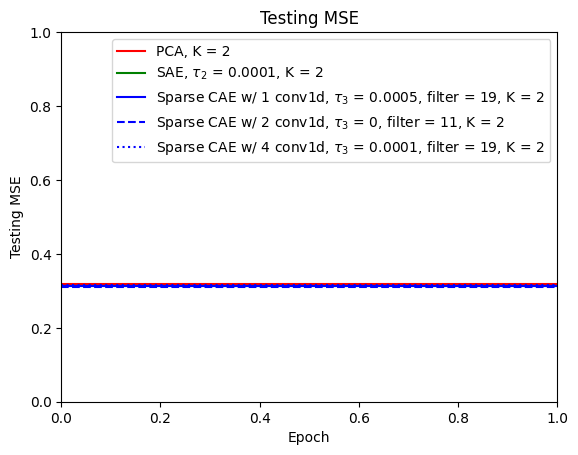

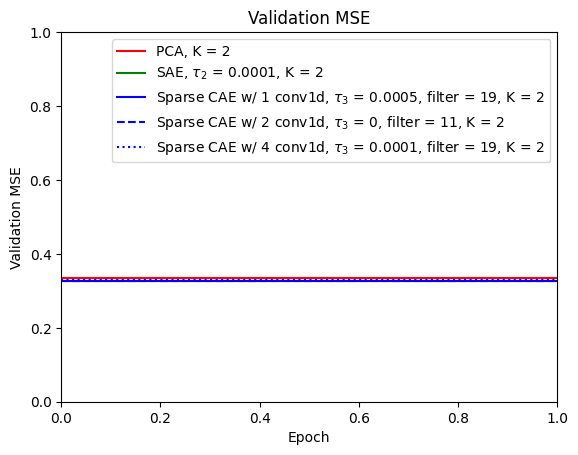

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1877: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1878: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

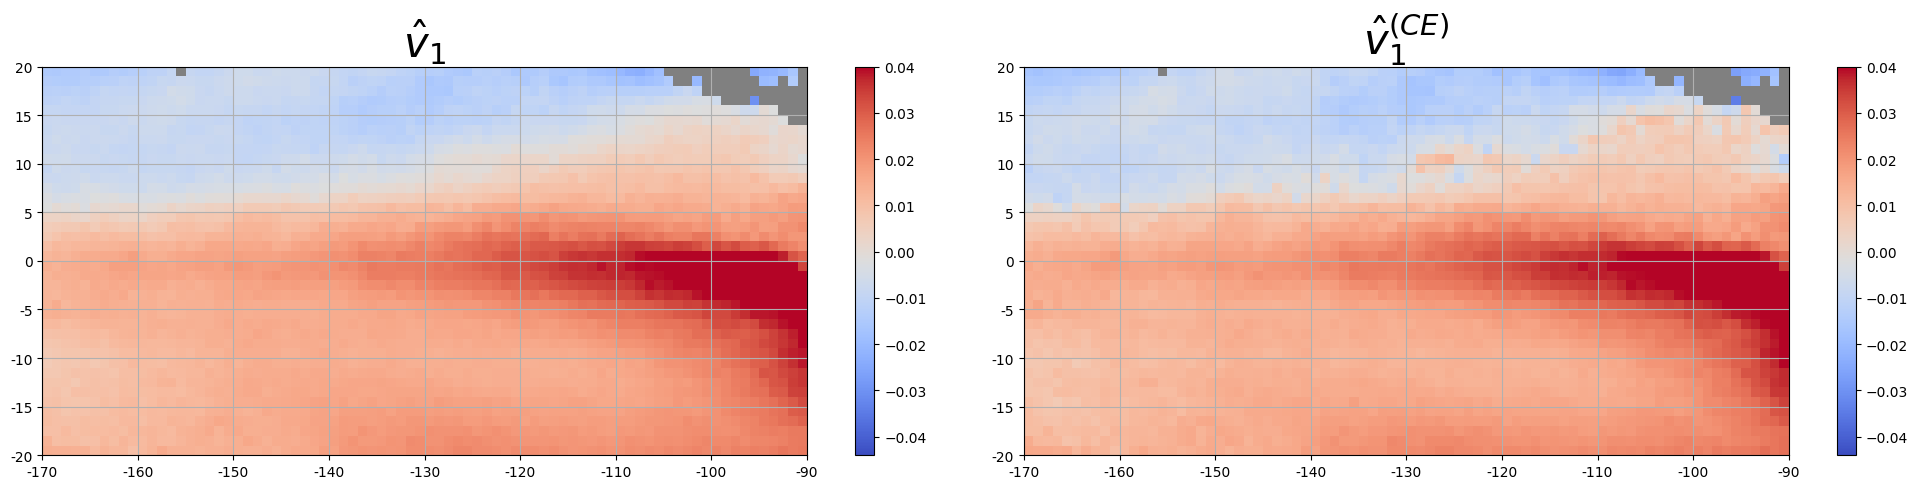

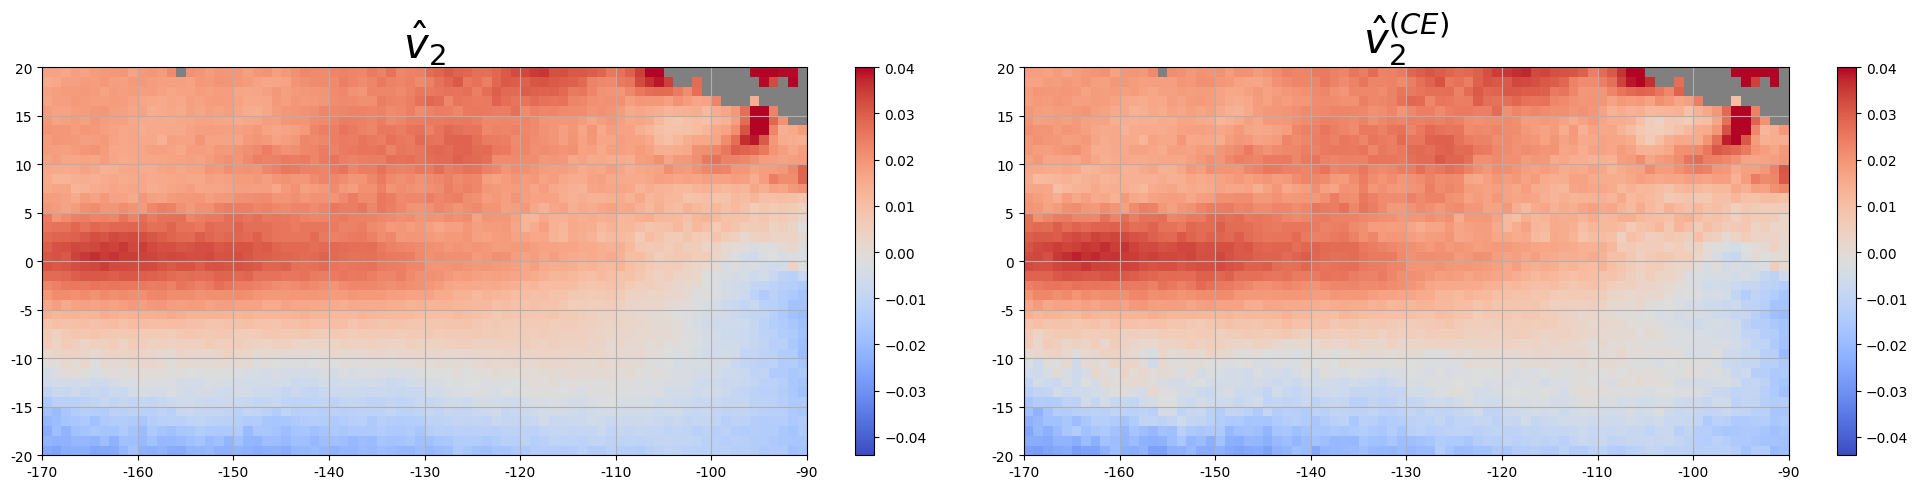

第1個lambda train 1st model time: -0.8668239116668701 秒
第1個lambda train 2nd model time: -1.0315351486206055 秒
第1個lambda train 3rd model time: -1.3724122047424316 秒
第1個lambda train SAE model time: -0.7179503440856934 秒
第一個lambda save model time: -0.009350299835205078 秒
using None estimating the loadings
1 estimation time: -1.3408451080322266 秒
SAE resindex = 0.26612089162758246, lambda = 0.0
CAE1 resindex = 0.2633078844424013, lambda = 0
CAE3 resindex = 0.26488101113407003, lambda = 0
CAE5 resindex = 0.26489481214294075, lambda = 0
第2個lambda LOAD model time: -0.007936477661132812 秒
第2個lambda train 1st model time: -0.8677225112915039 秒
第2個lambda train 2nd model time: -1.024263858795166 秒
第2個lambda train 3rd model time: -1.358039140701294 秒
第2個lambda train SAE model time: -0.6779642105102539 秒
第2個lambda save model time: -0.011251449584960938 秒
using None estimating the loadings
2 estimation time: -1.304166316986084 秒
SAE resindex = 0.2657820560316892, lambda = 1e-05
CAE5 resindex = 0.264884

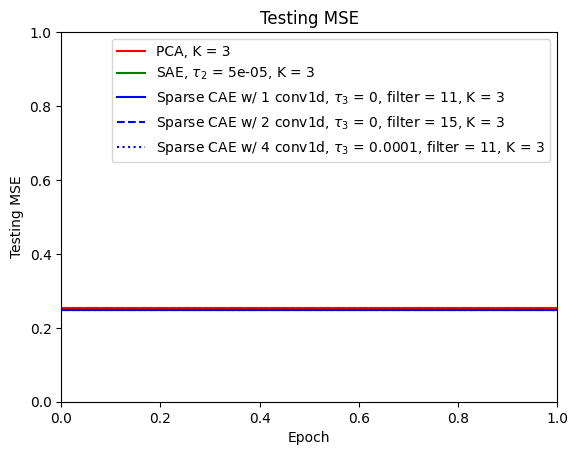

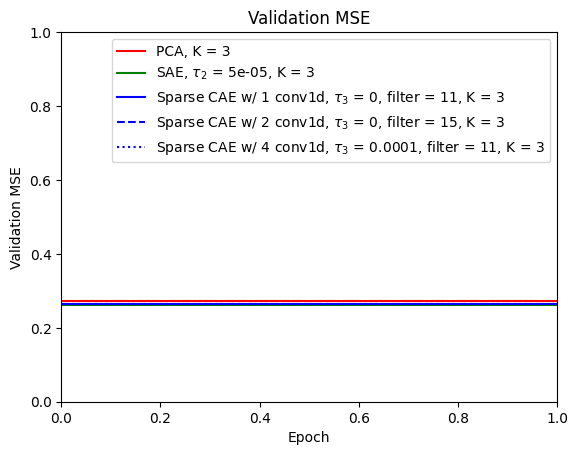

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

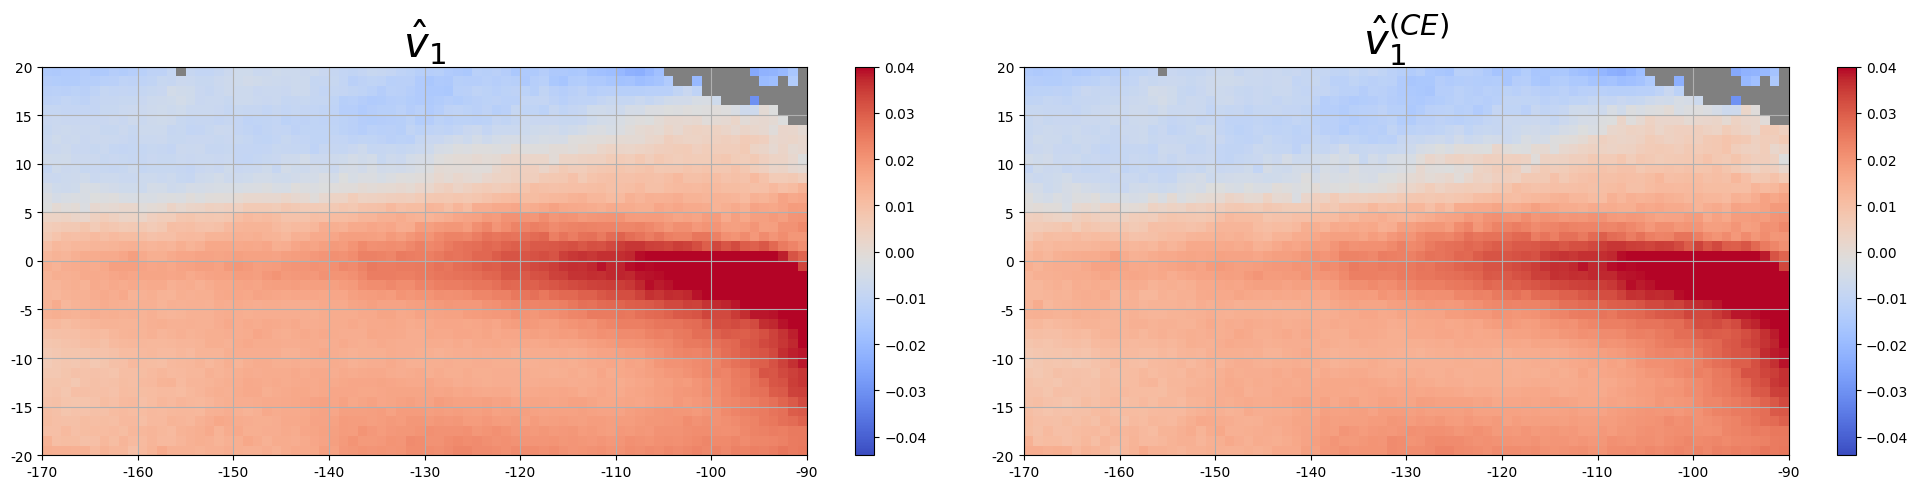

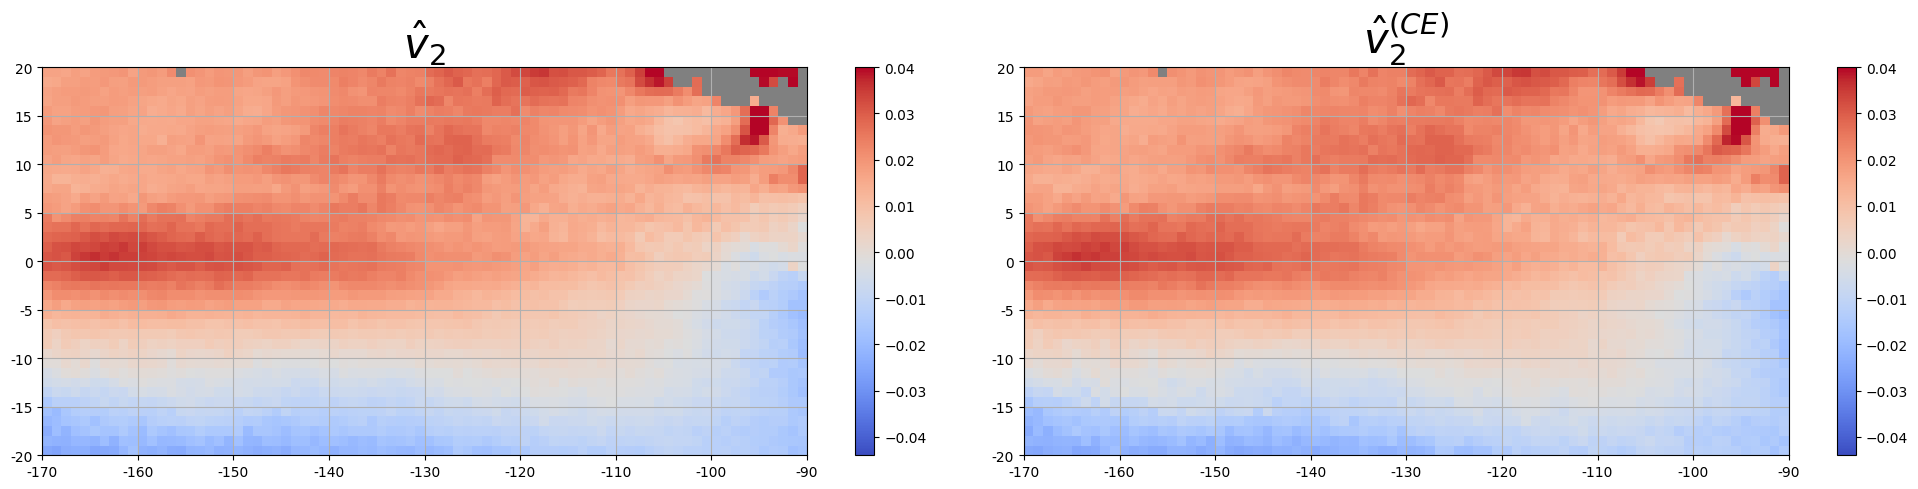

第1個lambda train 1st model time: -0.8699357509613037 秒
第1個lambda train 2nd model time: -1.0374085903167725 秒
第1個lambda train 3rd model time: -1.413891315460205 秒
第1個lambda train SAE model time: -0.6976752281188965 秒
第一個lambda save model time: -0.009464740753173828 秒
using None estimating the loadings
1 estimation time: -1.3101119995117188 秒
SAE resindex = 0.22570692661112562, lambda = 0.0
CAE1 resindex = 0.22578361113248455, lambda = 0
CAE3 resindex = 0.22538230364088607, lambda = 0
CAE5 resindex = 0.22559354876721377, lambda = 0
第2個lambda LOAD model time: -0.008318901062011719 秒
第2個lambda train 1st model time: -0.8660111427307129 秒
第2個lambda train 2nd model time: -1.0548059940338135 秒
第2個lambda train 3rd model time: -1.348780632019043 秒
第2個lambda train SAE model time: -0.6792478561401367 秒
第2個lambda save model time: -0.009757518768310547 秒
using None estimating the loadings
2 estimation time: -1.3068280220031738 秒
SAE resindex = 0.22521830619476302, lambda = 1e-05
第3個lambda LOAD model 

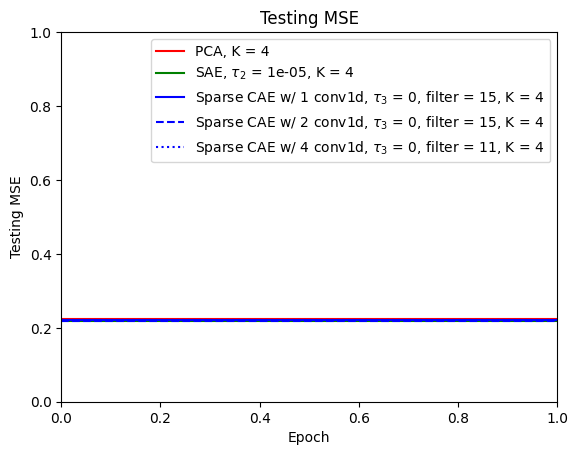

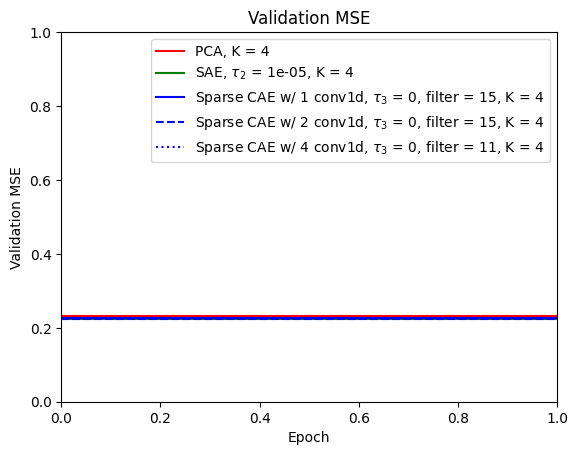

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1877: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1878: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

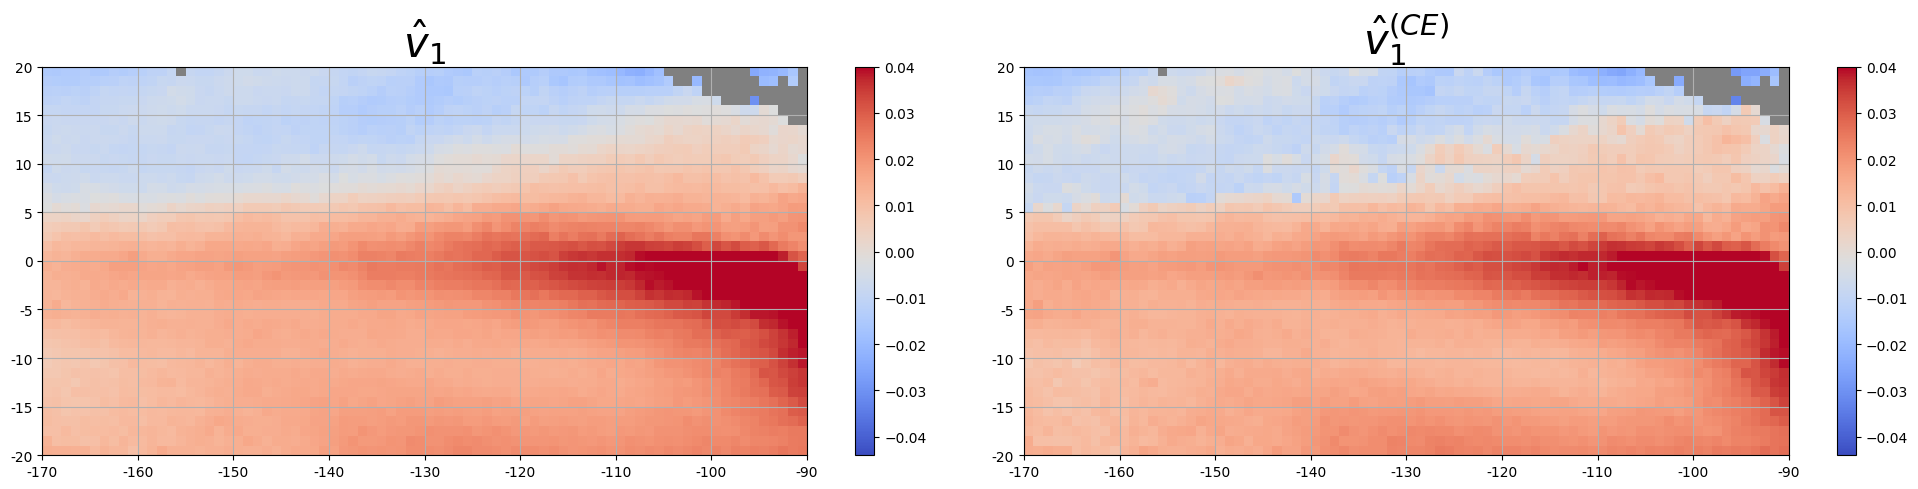

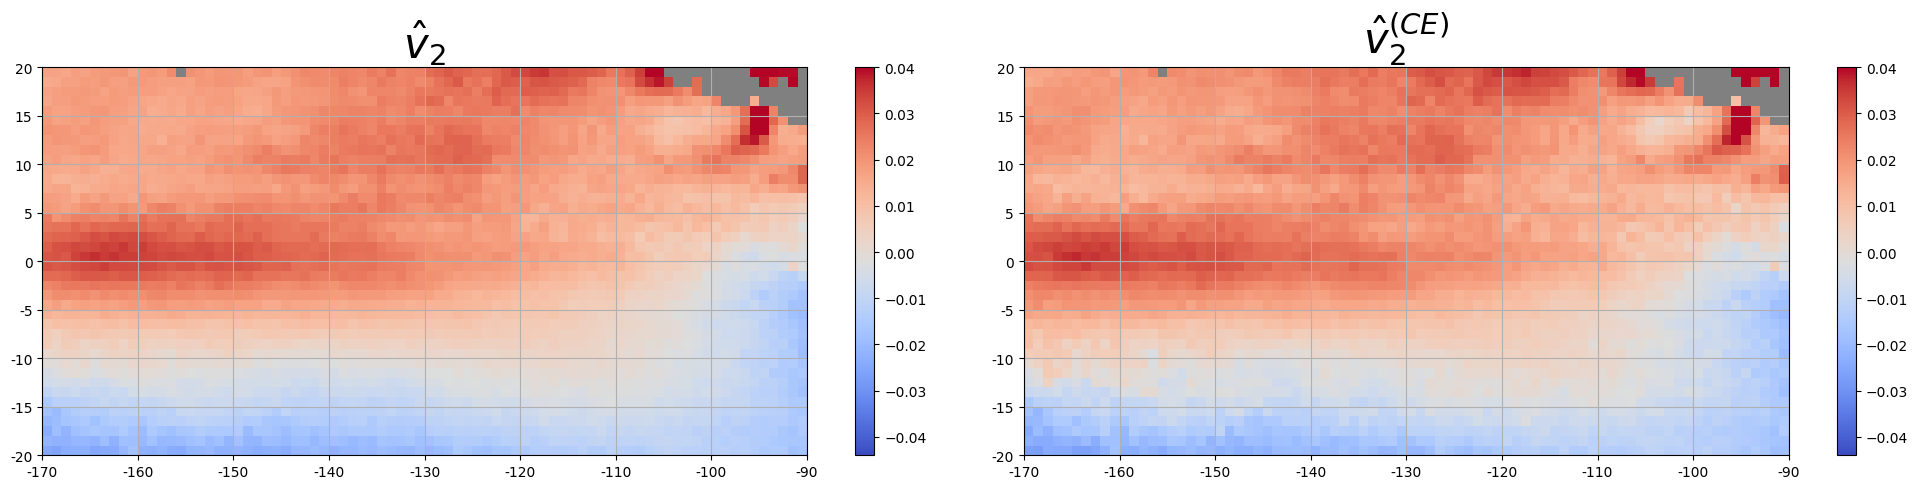

第1個lambda train 1st model time: -0.8709671497344971 秒
第1個lambda train 2nd model time: -1.0483698844909668 秒
第1個lambda train 3rd model time: -1.3669276237487793 秒
第1個lambda train SAE model time: -0.6911685466766357 秒
第一個lambda save model time: -0.009898185729980469 秒
using None estimating the loadings
1 estimation time: -1.3121955394744873 秒
SAE resindex = 0.19297488197684215, lambda = 0.0
CAE1 resindex = 0.19285812760987622, lambda = 0
CAE3 resindex = 0.19316544973924982, lambda = 0
CAE5 resindex = 0.19276049876067336, lambda = 0
第2個lambda LOAD model time: -0.007844924926757812 秒
第2個lambda train 1st model time: -0.9494180679321289 秒
第2個lambda train 2nd model time: -1.0588927268981934 秒
第2個lambda train 3rd model time: -1.6153111457824707 秒
第2個lambda train SAE model time: -0.7340993881225586 秒
第2個lambda save model time: -0.015166521072387695 秒
using None estimating the loadings
2 estimation time: -1.3528435230255127 秒
SAE resindex = 0.1927747492989873, lambda = 1e-05
第3個lambda LOAD model

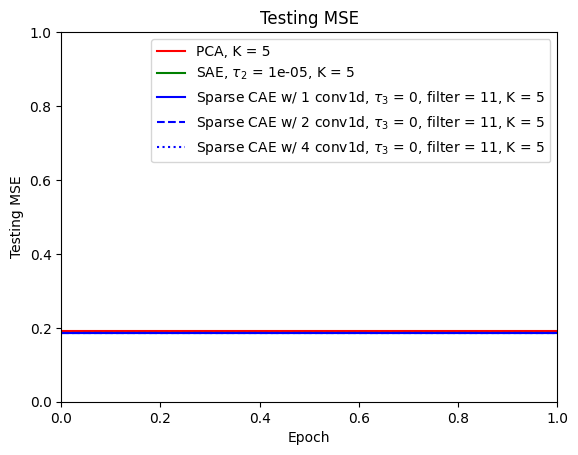

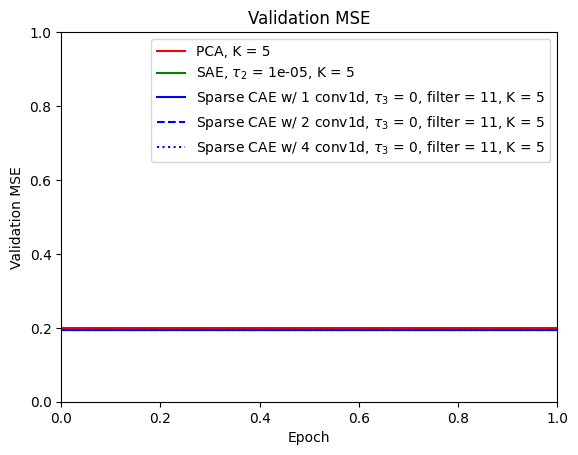

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1909: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1910: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

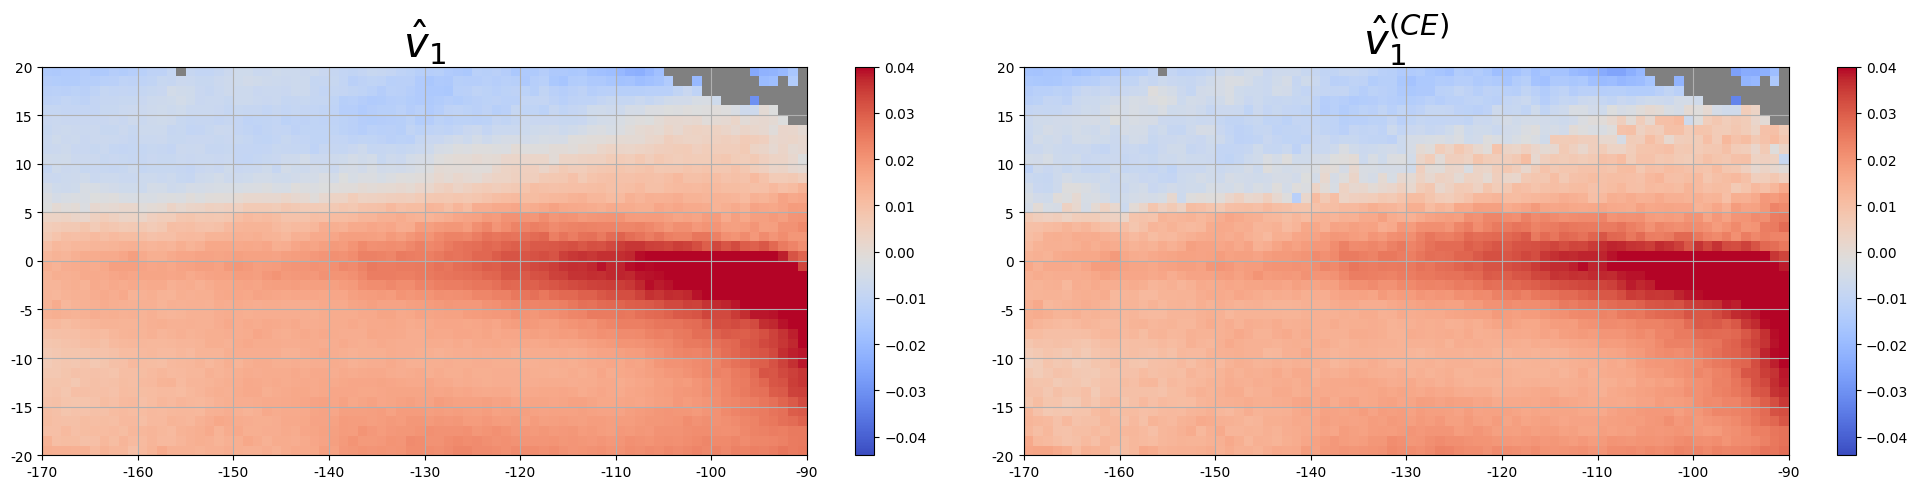

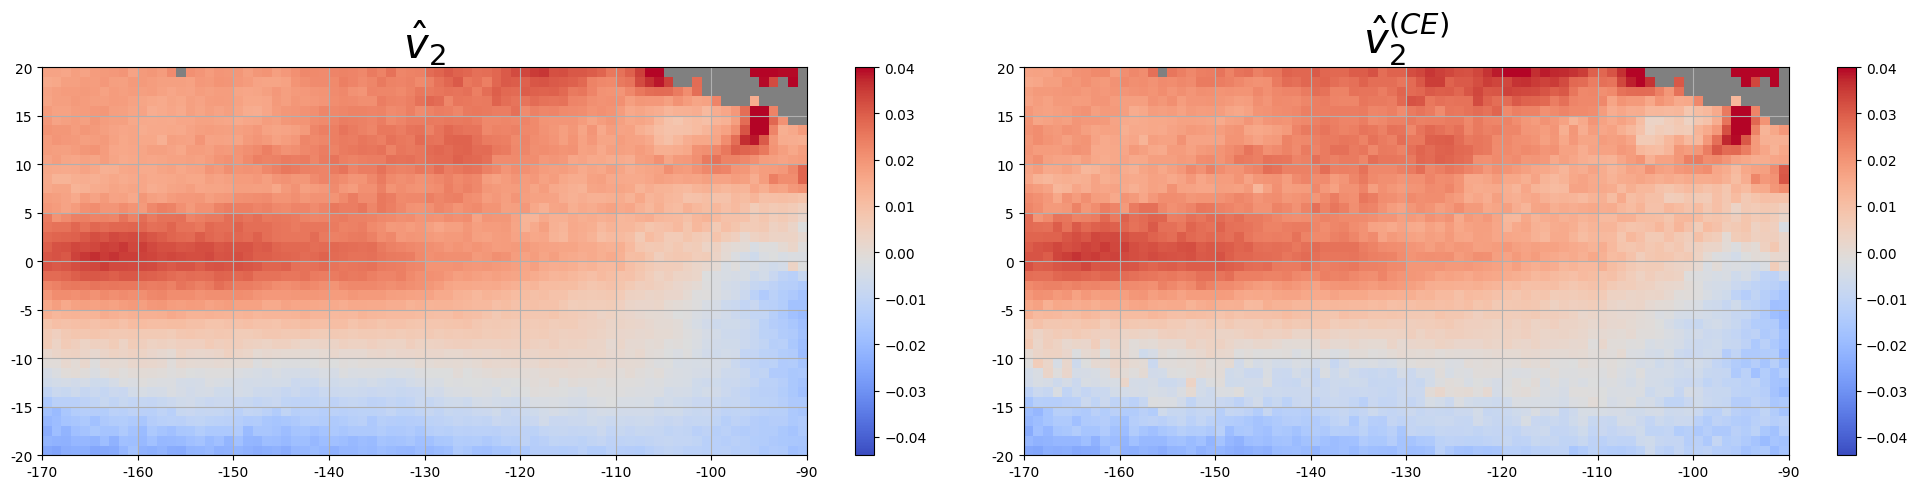

第1個lambda train 1st model time: -0.8630692958831787 秒
第1個lambda train 2nd model time: -1.0463247299194336 秒
第1個lambda train 3rd model time: -1.3545677661895752 秒
第1個lambda train SAE model time: -0.6740031242370605 秒
第一個lambda save model time: -0.009836196899414062 秒
using None estimating the loadings
1 estimation time: -1.324439525604248 秒
SAE resindex = 0.18324458323357898, lambda = 0.0
CAE1 resindex = 0.1822294244571781, lambda = 0
CAE3 resindex = 0.18353798020919487, lambda = 0
CAE5 resindex = 0.18253677892230857, lambda = 0
第2個lambda LOAD model time: -0.007781028747558594 秒
第2個lambda train 1st model time: -0.8342628479003906 秒
第2個lambda train 2nd model time: -0.994950532913208 秒
第2個lambda train 3rd model time: -1.4480969905853271 秒
第2個lambda train SAE model time: -0.666010856628418 秒
第2個lambda save model time: -0.009925365447998047 秒
using None estimating the loadings
2 estimation time: -1.3146750926971436 秒
第3個lambda LOAD model time: -0.0075185298919677734 秒
第3個lambda train 1st mo

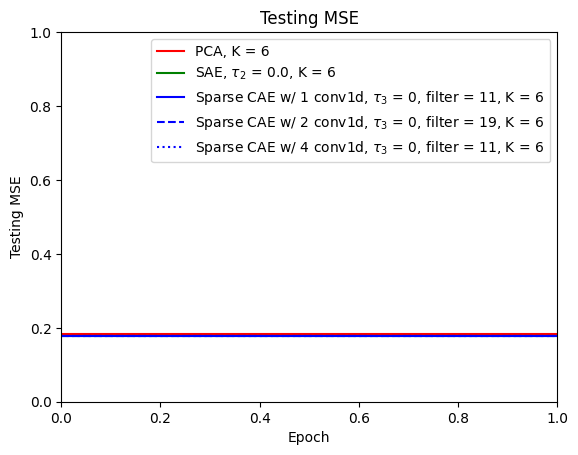

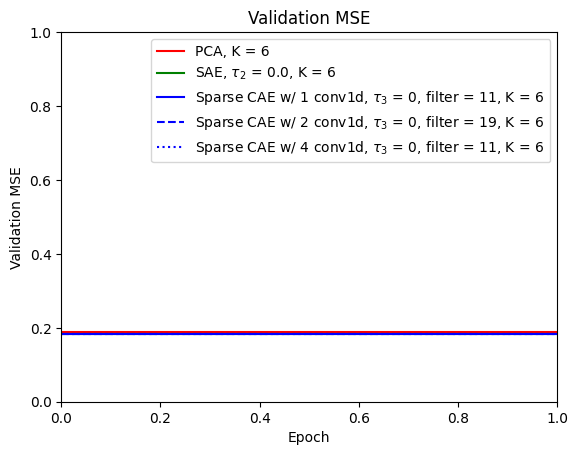

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

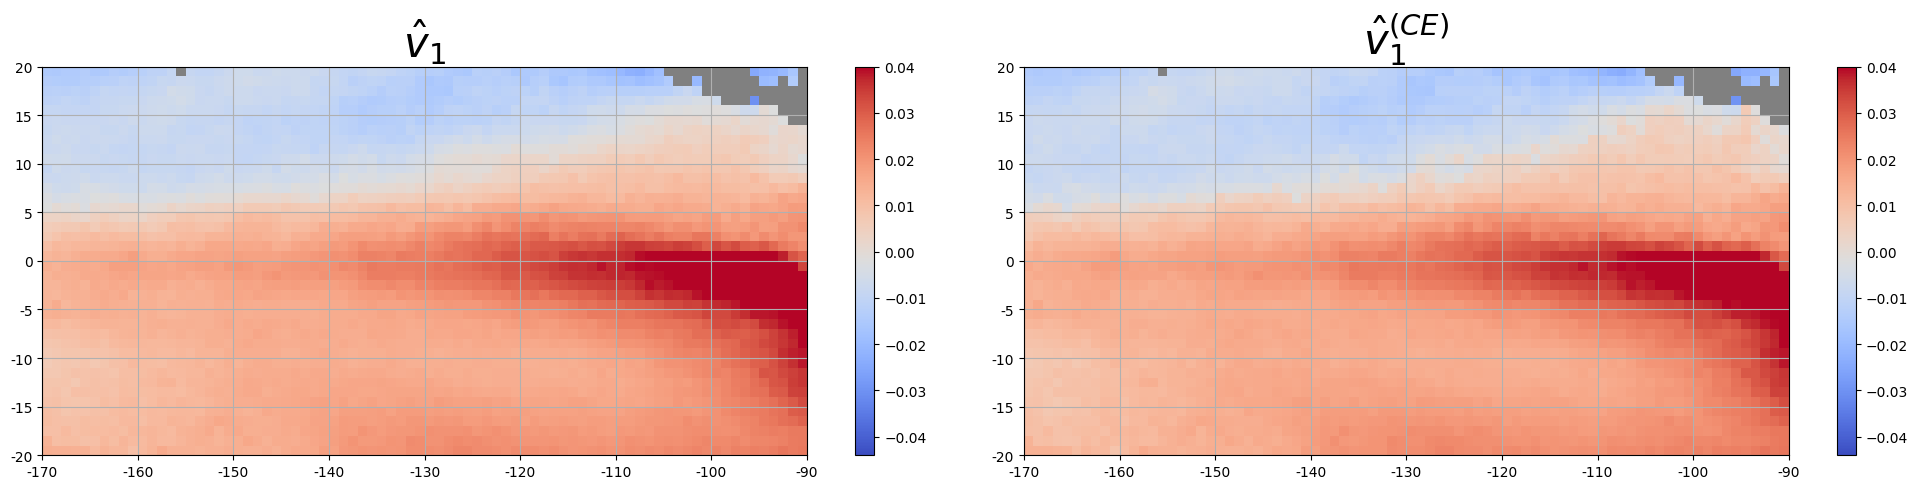

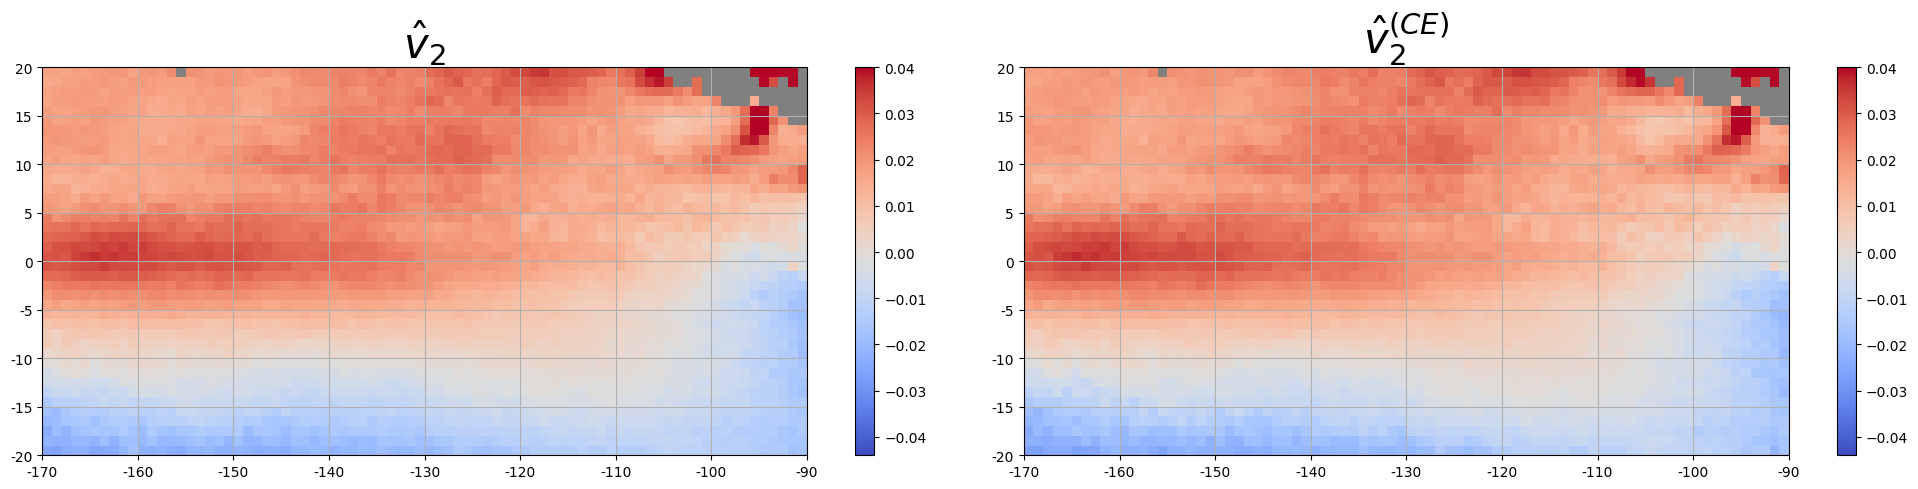

第1個lambda train 1st model time: -0.9081106185913086 秒
第1個lambda train 2nd model time: -1.1134660243988037 秒
第1個lambda train 3rd model time: -1.436556100845337 秒
第1個lambda train SAE model time: -0.7185661792755127 秒
第一個lambda save model time: -0.010043144226074219 秒
using None estimating the loadings
1 estimation time: -1.3118398189544678 秒
SAE resindex = 0.1751950201917881, lambda = 0.0
CAE1 resindex = 0.17541318029348713, lambda = 0
CAE3 resindex = 0.1759027597263039, lambda = 0
CAE5 resindex = 0.17692912733685684, lambda = 0
第2個lambda LOAD model time: -0.008168935775756836 秒
第2個lambda train 1st model time: -0.9074957370758057 秒
第2個lambda train 2nd model time: -1.0934271812438965 秒
第2個lambda train 3rd model time: -1.571192979812622 秒
第2個lambda train SAE model time: -0.7123863697052002 秒
第2個lambda save model time: -0.010060787200927734 秒
using None estimating the loadings
2 estimation time: -1.2946407794952393 秒
第3個lambda LOAD model time: -0.008927583694458008 秒
第3個lambda train 1st mod

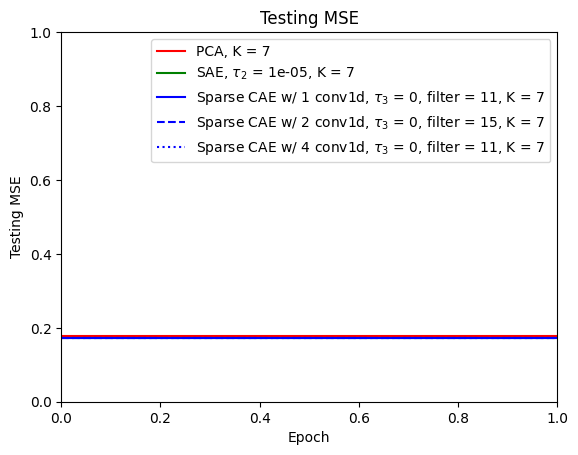

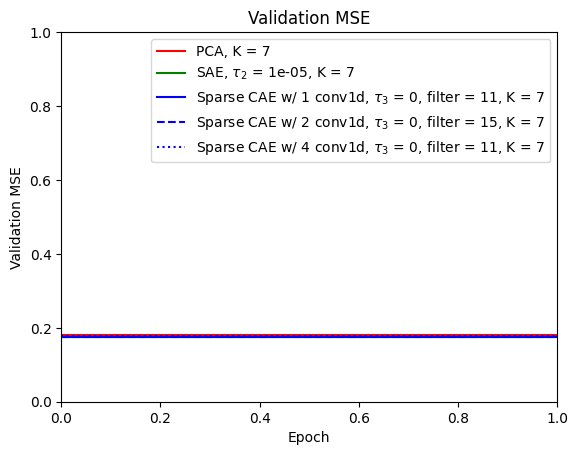

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

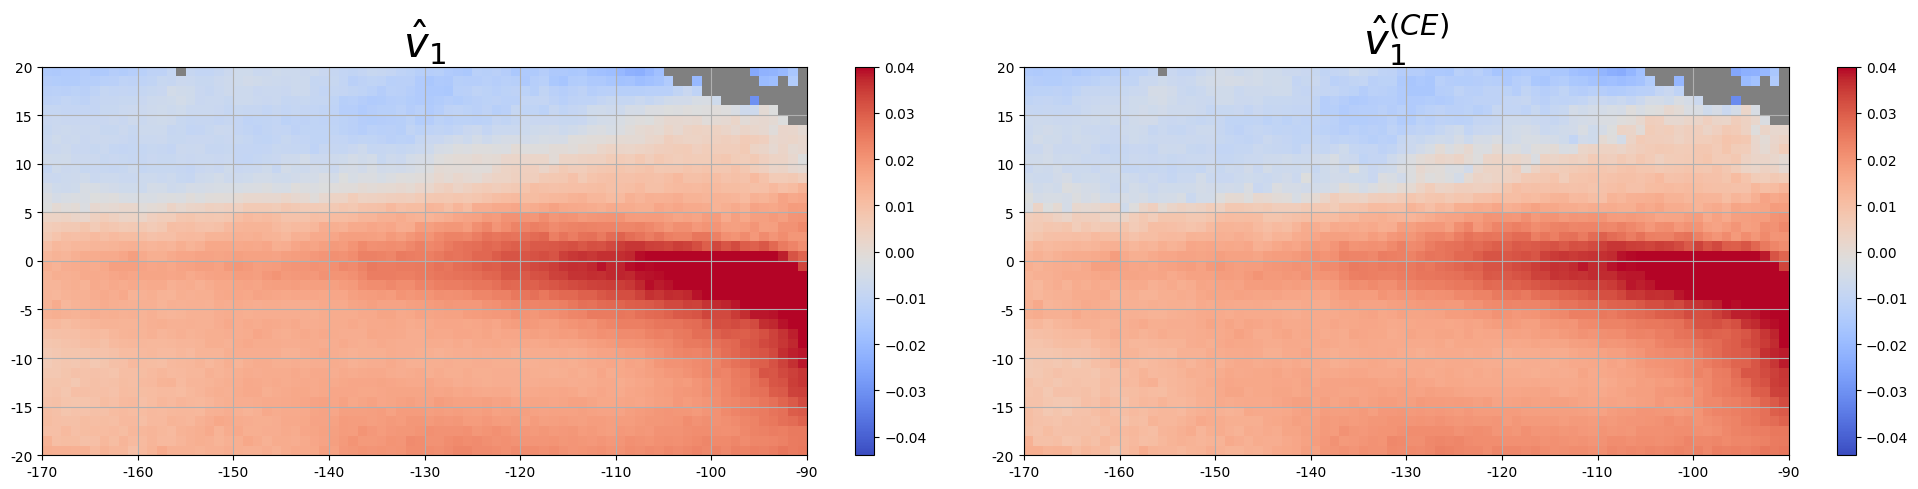

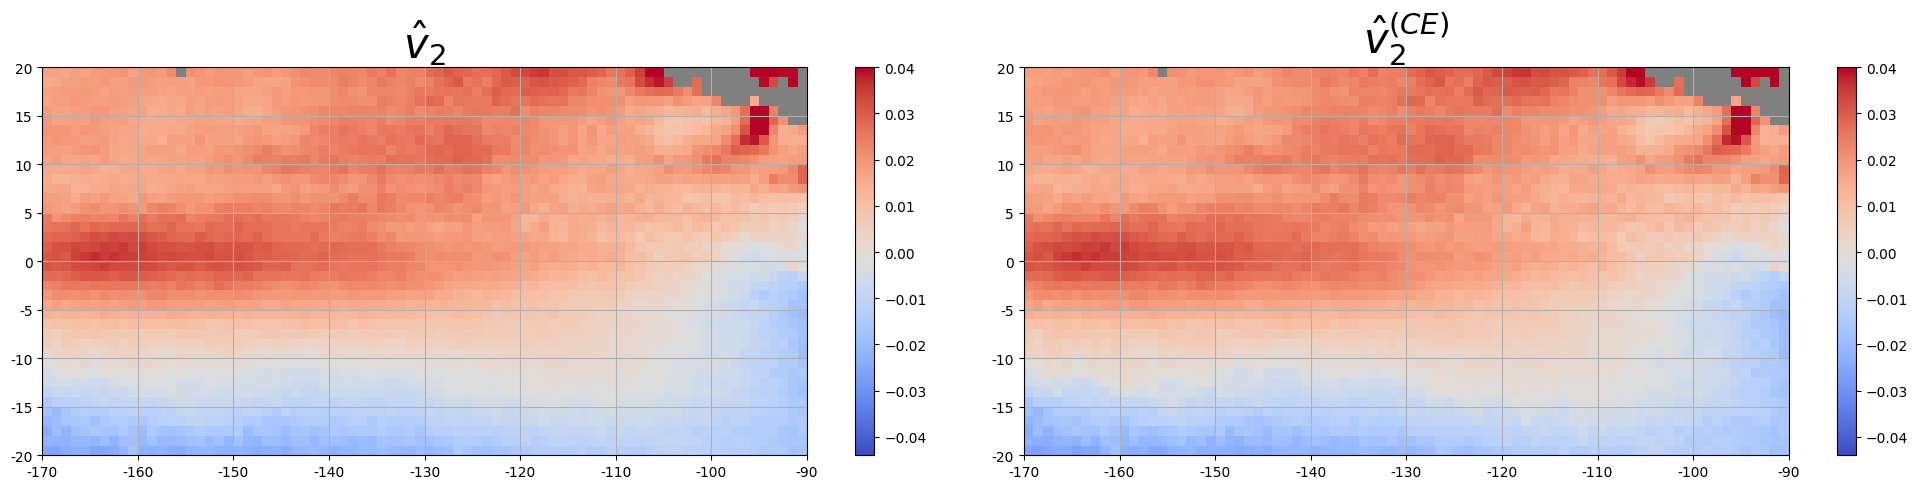

第1個lambda train 1st model time: -0.8465292453765869 秒
第1個lambda train 2nd model time: -1.0311918258666992 秒
第1個lambda train 3rd model time: -1.3766682147979736 秒
第1個lambda train SAE model time: -0.687976598739624 秒
第一個lambda save model time: -0.010367155075073242 秒
using None estimating the loadings
1 estimation time: -1.3009612560272217 秒
SAE resindex = 0.17080555057756244, lambda = 0.0
CAE1 resindex = 0.17074107650490858, lambda = 0
CAE3 resindex = 0.17088885722210706, lambda = 0
CAE5 resindex = 0.1738228988342867, lambda = 0
第2個lambda LOAD model time: -0.008392333984375 秒
第2個lambda train 1st model time: -0.8498172760009766 秒
第2個lambda train 2nd model time: -1.0303001403808594 秒
第2個lambda train 3rd model time: -1.3718993663787842 秒
第2個lambda train SAE model time: -0.7068324089050293 秒
第2個lambda save model time: -0.012489557266235352 秒
using None estimating the loadings
2 estimation time: -1.3264060020446777 秒
CAE5 resindex = 0.17304491881162423, lambda = 0.0001
第3個lambda LOAD model t

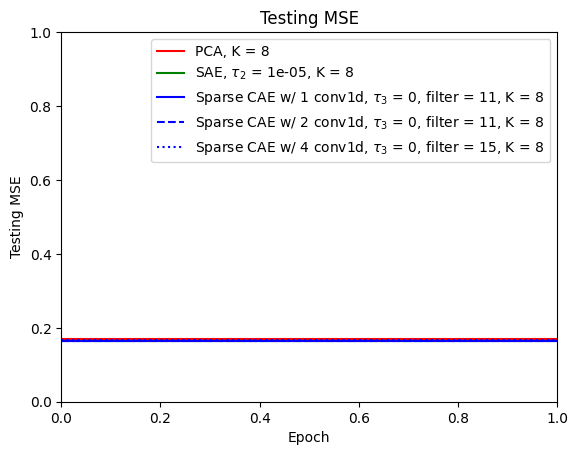

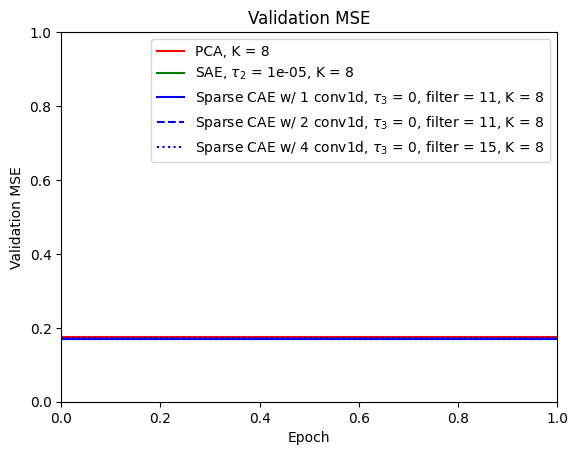

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

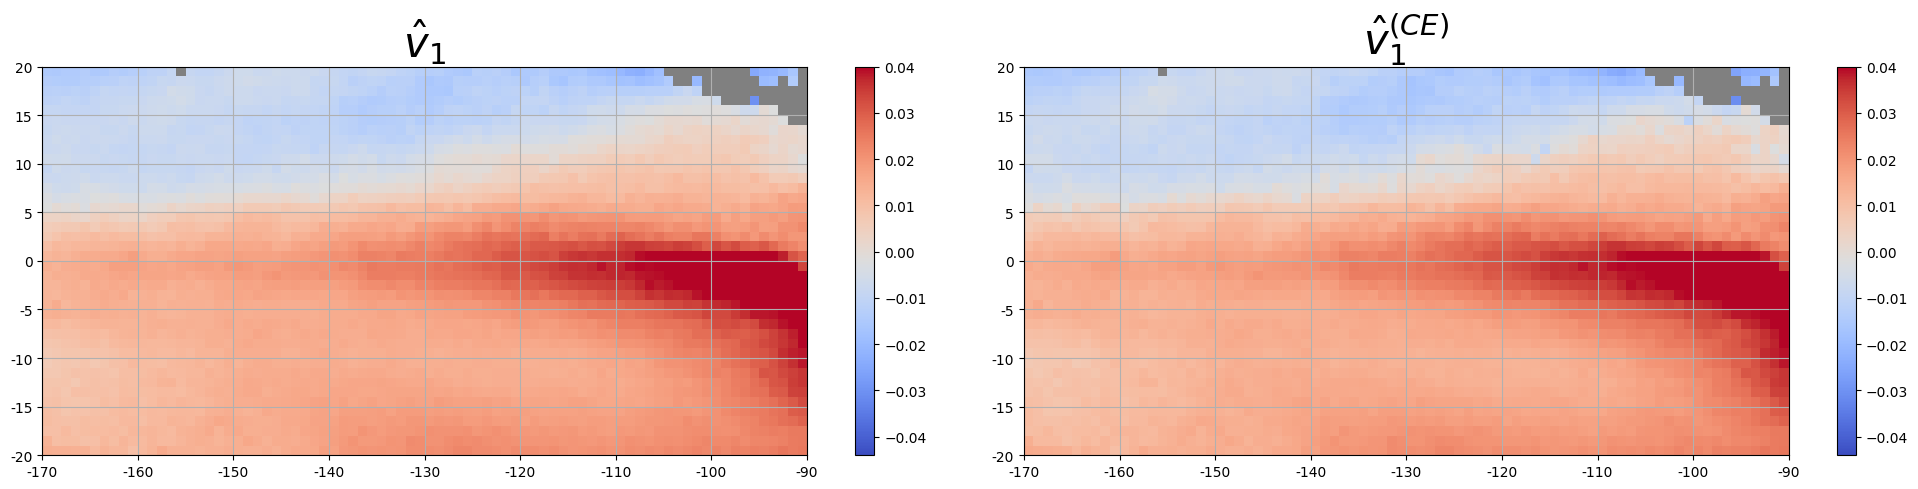

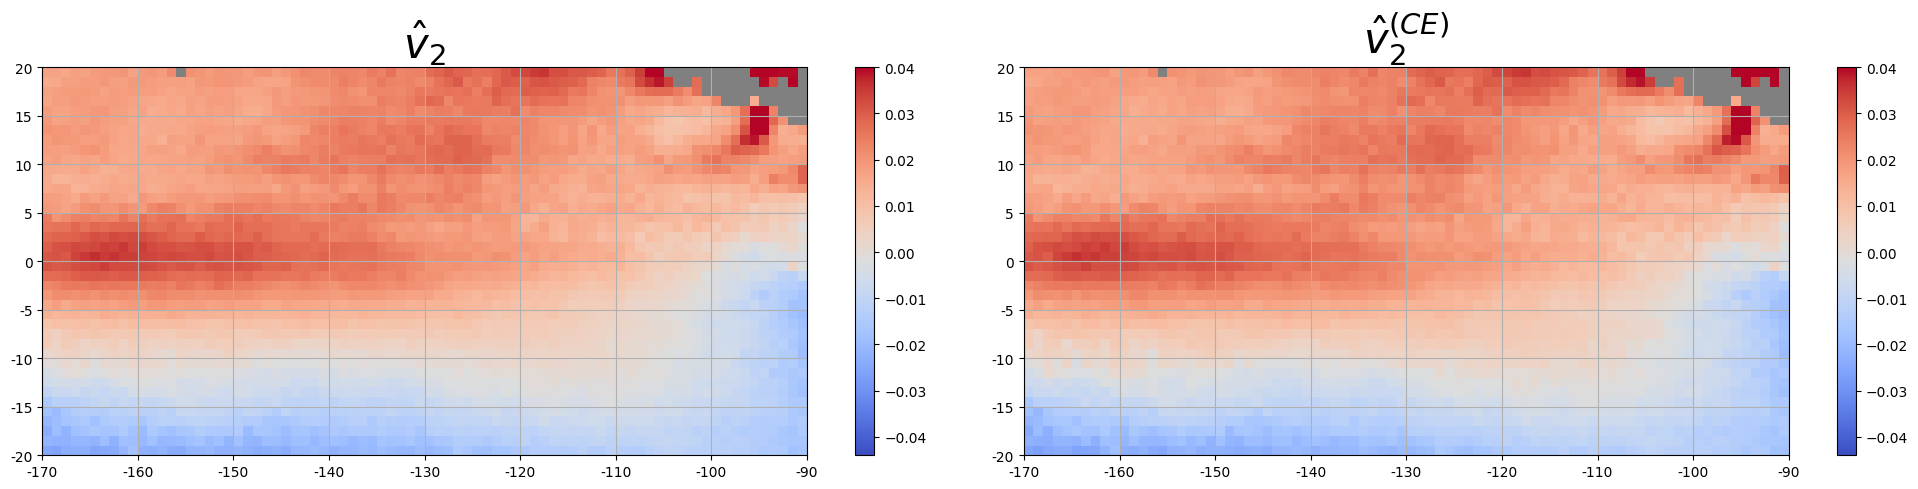

第1個lambda train 1st model time: -0.8701210021972656 秒
第1個lambda train 2nd model time: -1.0383305549621582 秒
第1個lambda train 3rd model time: -1.5447134971618652 秒
第1個lambda train SAE model time: -0.6940135955810547 秒
第一個lambda save model time: -0.009760141372680664 秒
using None estimating the loadings
1 estimation time: -1.2935984134674072 秒
SAE resindex = 0.16595135559436344, lambda = 0.0
CAE1 resindex = 0.16565812738392938, lambda = 0
CAE3 resindex = 0.16636492130674585, lambda = 0
CAE5 resindex = 0.16534576189302513, lambda = 0
第2個lambda LOAD model time: -0.008165836334228516 秒
第2個lambda train 1st model time: -0.8438472747802734 秒
第2個lambda train 2nd model time: -1.0456418991088867 秒
第2個lambda train 3rd model time: -1.3597972393035889 秒
第2個lambda train SAE model time: -0.6914589405059814 秒
第2個lambda save model time: -0.009814739227294922 秒
using None estimating the loadings
2 estimation time: -1.3078069686889648 秒
SAE resindex = 0.16552040571791718, lambda = 1e-05
第3個lambda LOAD mode

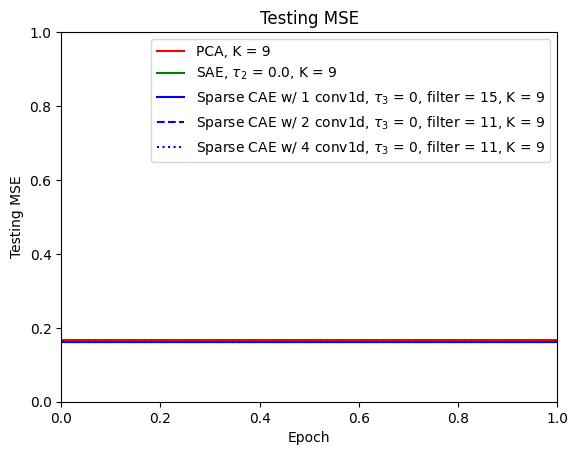

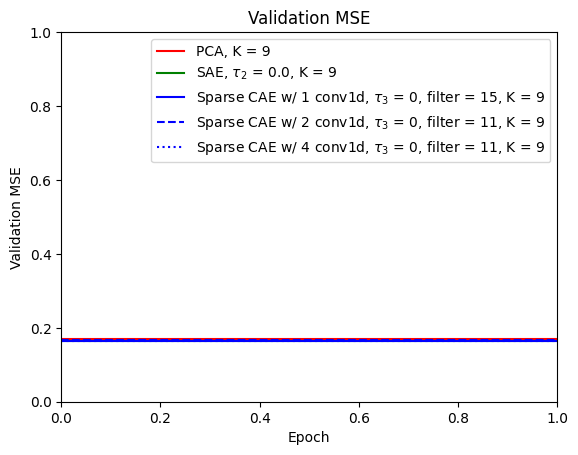

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

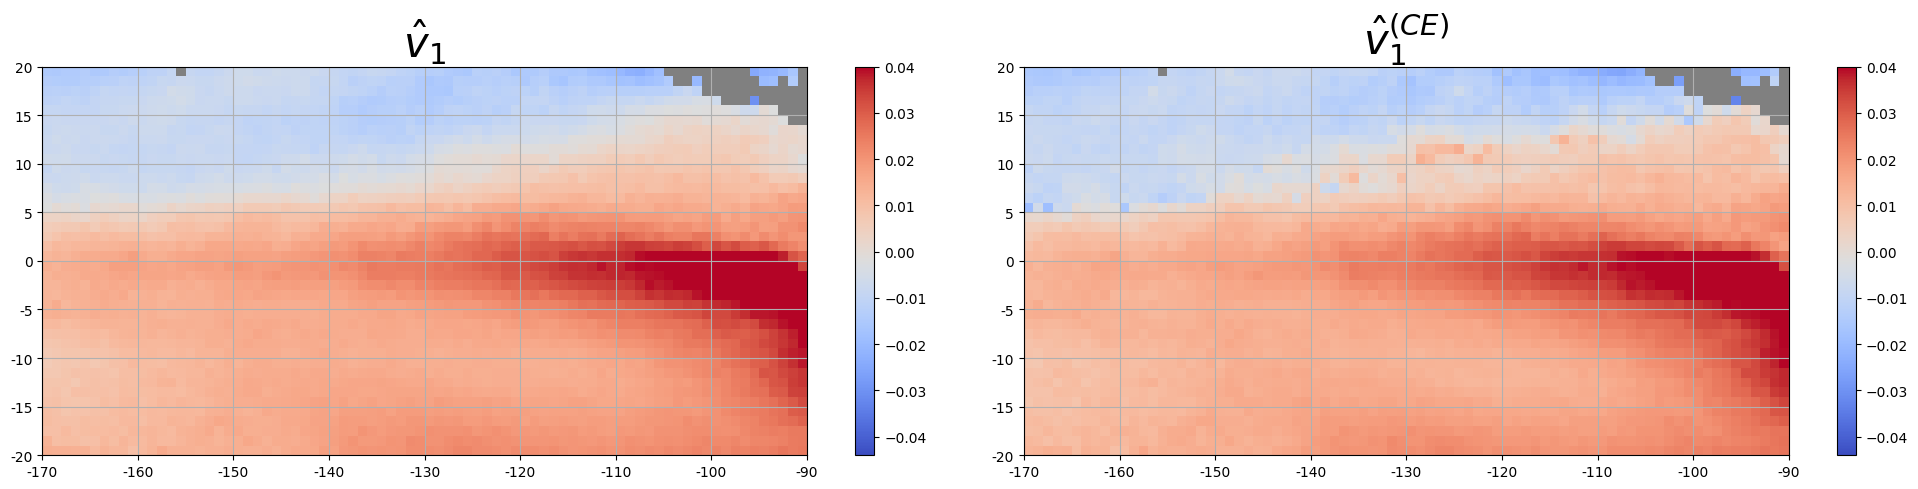

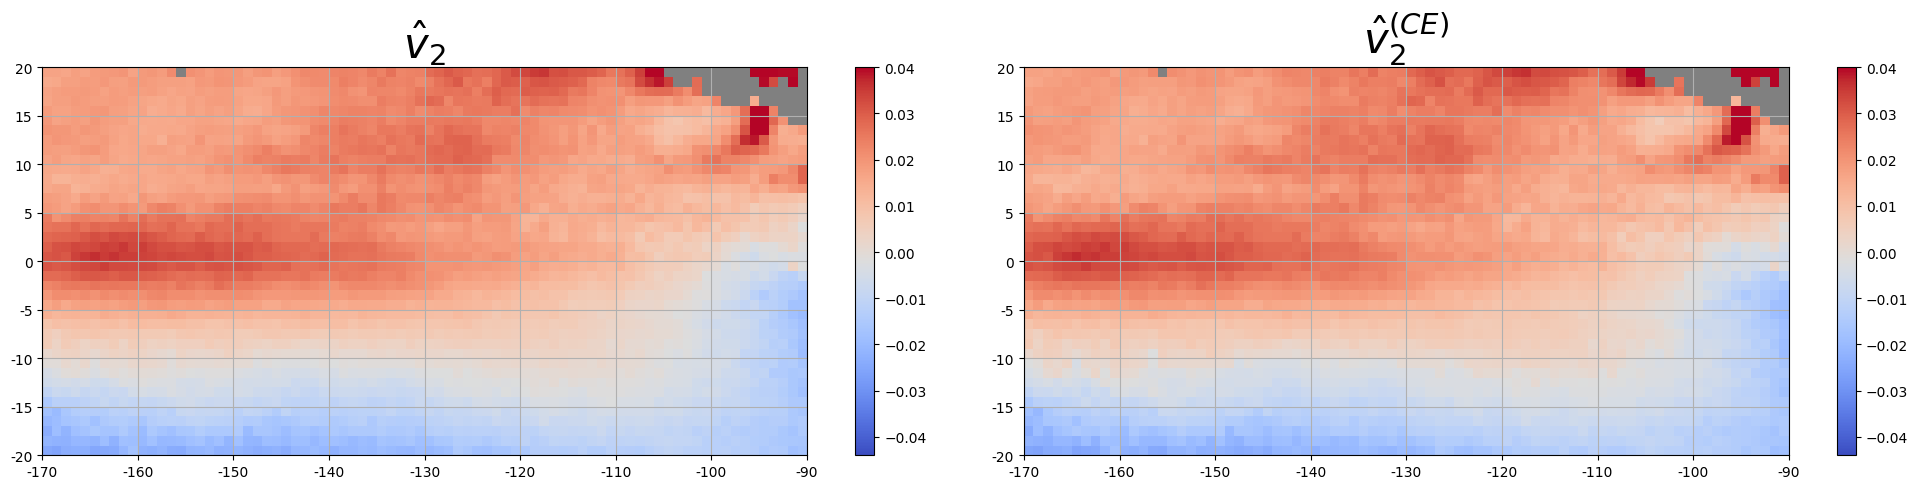

第1個lambda train 1st model time: -0.8388674259185791 秒
第1個lambda train 2nd model time: -1.0132837295532227 秒
第1個lambda train 3rd model time: -1.3561182022094727 秒
第1個lambda train SAE model time: -0.6897404193878174 秒
第一個lambda save model time: -0.011093616485595703 秒
using None estimating the loadings
1 estimation time: -1.3160860538482666 秒
SAE resindex = 0.16280518928341903, lambda = 0.0
CAE1 resindex = 0.16263311263029737, lambda = 0
CAE3 resindex = 0.16274594461323125, lambda = 0
CAE5 resindex = 0.16499103416058947, lambda = 0
第2個lambda LOAD model time: -0.007722139358520508 秒
第2個lambda train 1st model time: -0.8427164554595947 秒
第2個lambda train 2nd model time: -1.037045955657959 秒
第2個lambda train 3rd model time: -1.3660221099853516 秒
第2個lambda train SAE model time: -0.6803131103515625 秒
第2個lambda save model time: -0.010426044464111328 秒
using None estimating the loadings
2 estimation time: -1.3343377113342285 秒
SAE resindex = 0.16218379261718419, lambda = 1e-05
CAE5 resindex = 0.16

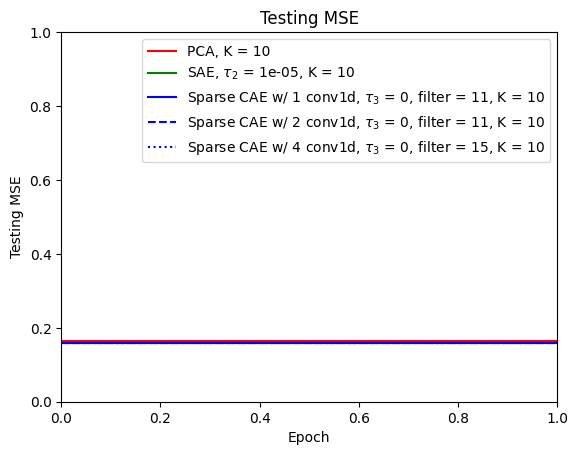

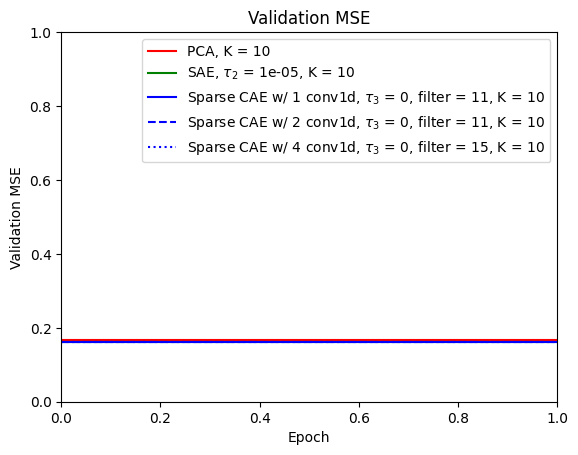

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1909: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1910: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

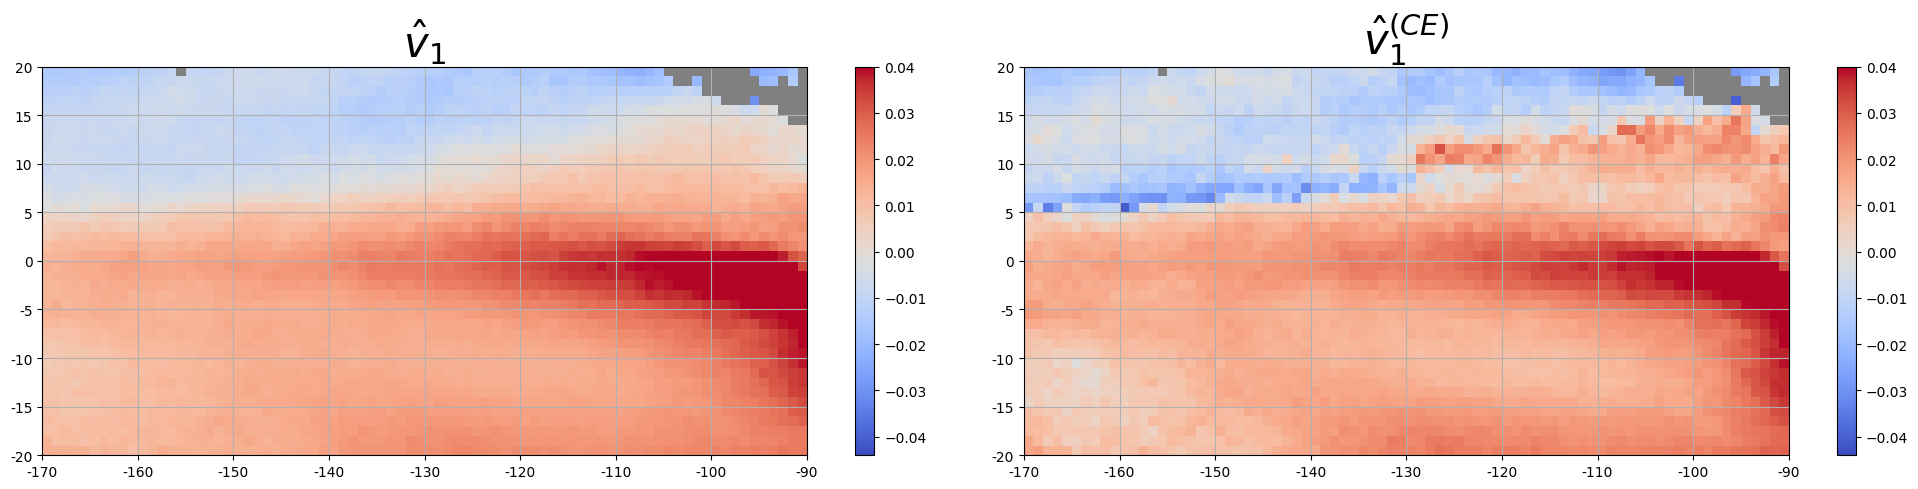

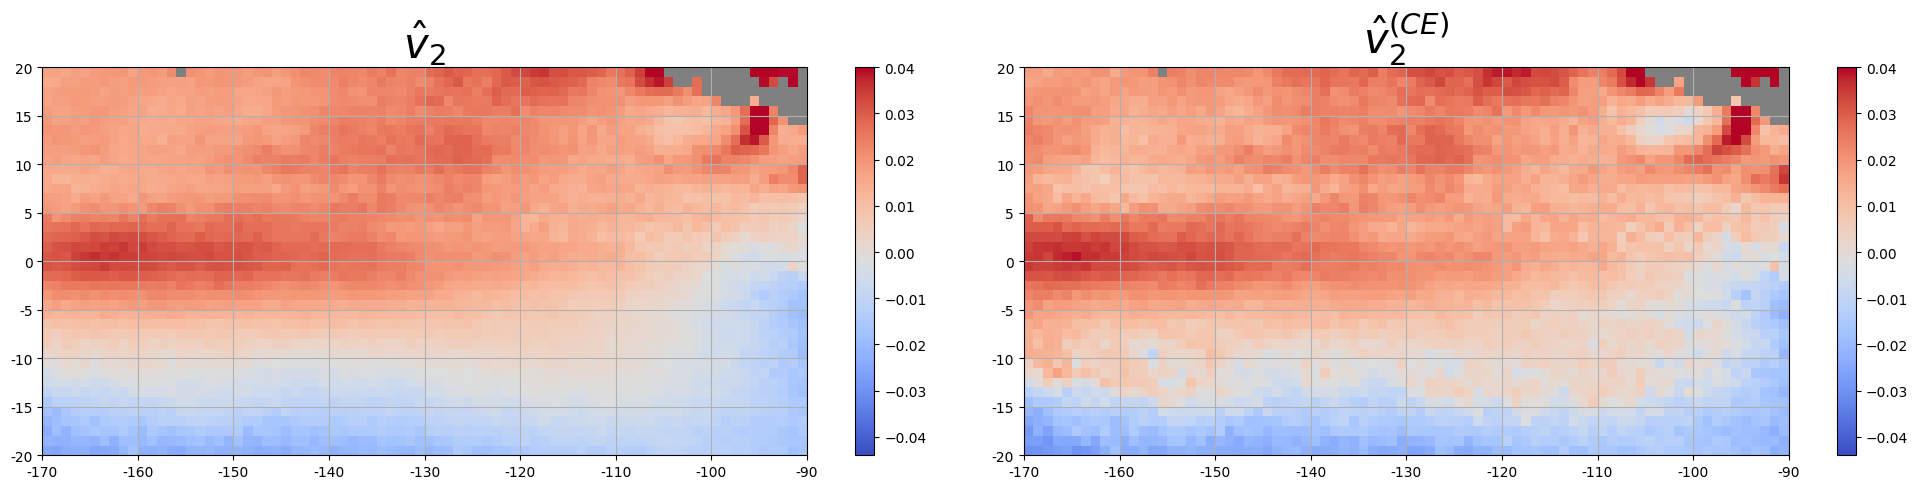

第1個lambda train 1st model time: -0.8530447483062744 秒
第1個lambda train 2nd model time: -1.0111885070800781 秒
第1個lambda train 3rd model time: -1.3244776725769043 秒
第1個lambda train SAE model time: -0.6747663021087646 秒
第一個lambda save model time: -0.010373830795288086 秒
using None estimating the loadings
1 estimation time: -1.3192195892333984 秒
SAE resindex = 0.15969180466736055, lambda = 0.0
CAE1 resindex = 0.1597692292130581, lambda = 0
CAE3 resindex = 0.1594400099006213, lambda = 0
CAE5 resindex = 0.15930448385218432, lambda = 0
第2個lambda LOAD model time: -0.008358478546142578 秒
第2個lambda train 1st model time: -0.8999145030975342 秒
第2個lambda train 2nd model time: -1.0386998653411865 秒
第2個lambda train 3rd model time: -1.3526670932769775 秒
第2個lambda train SAE model time: -0.6663980484008789 秒
第2個lambda save model time: -0.010440826416015625 秒
using None estimating the loadings
2 estimation time: -1.3126883506774902 秒
SAE resindex = 0.15946003809426648, lambda = 1e-05
第3個lambda LOAD model 

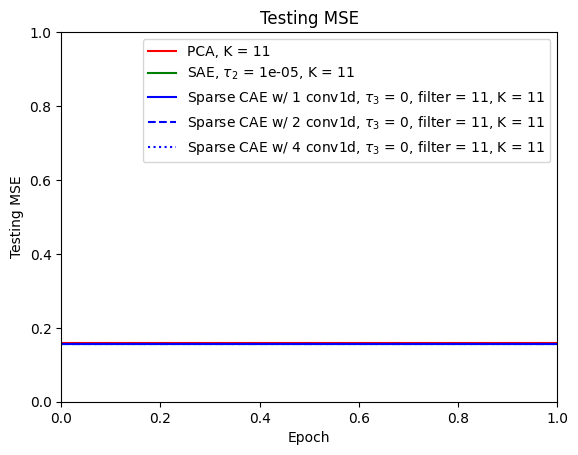

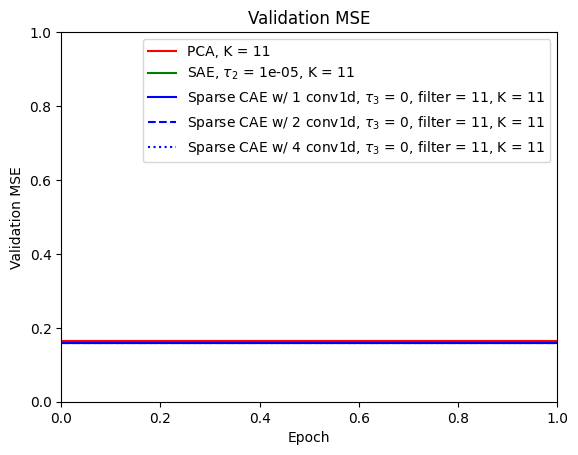

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1909: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1910: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

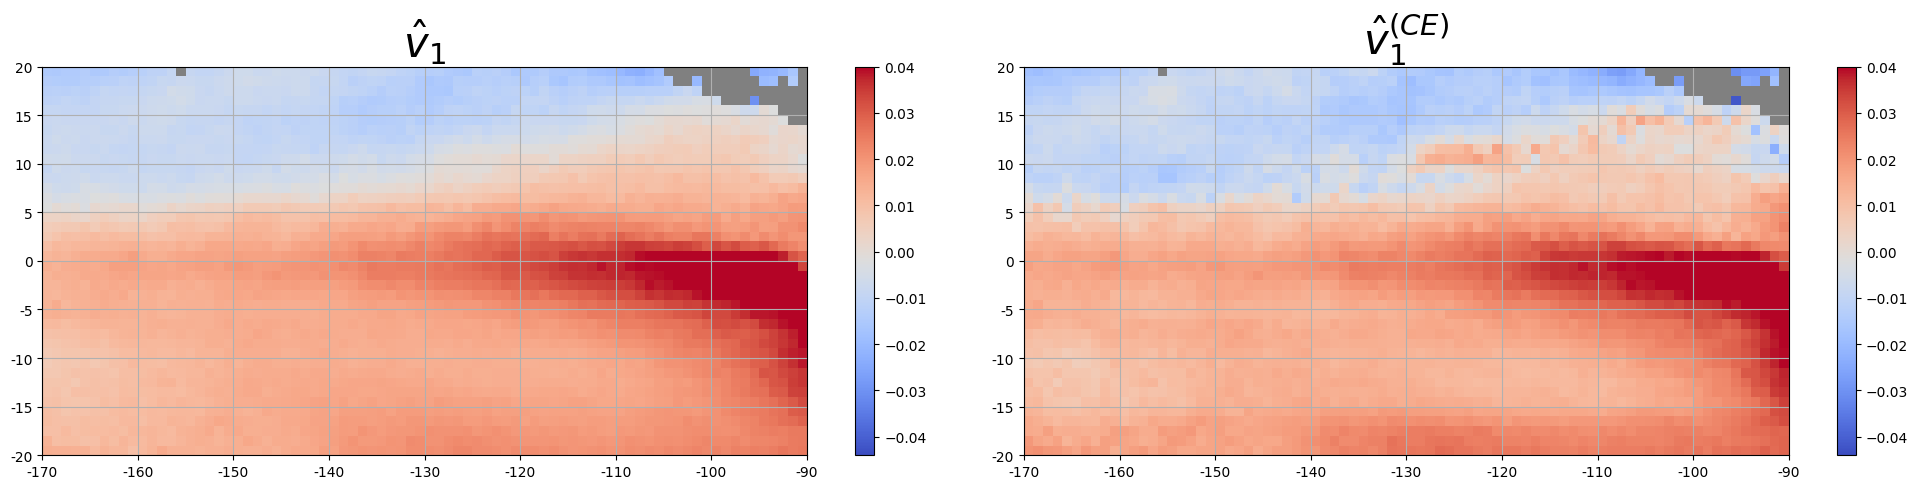

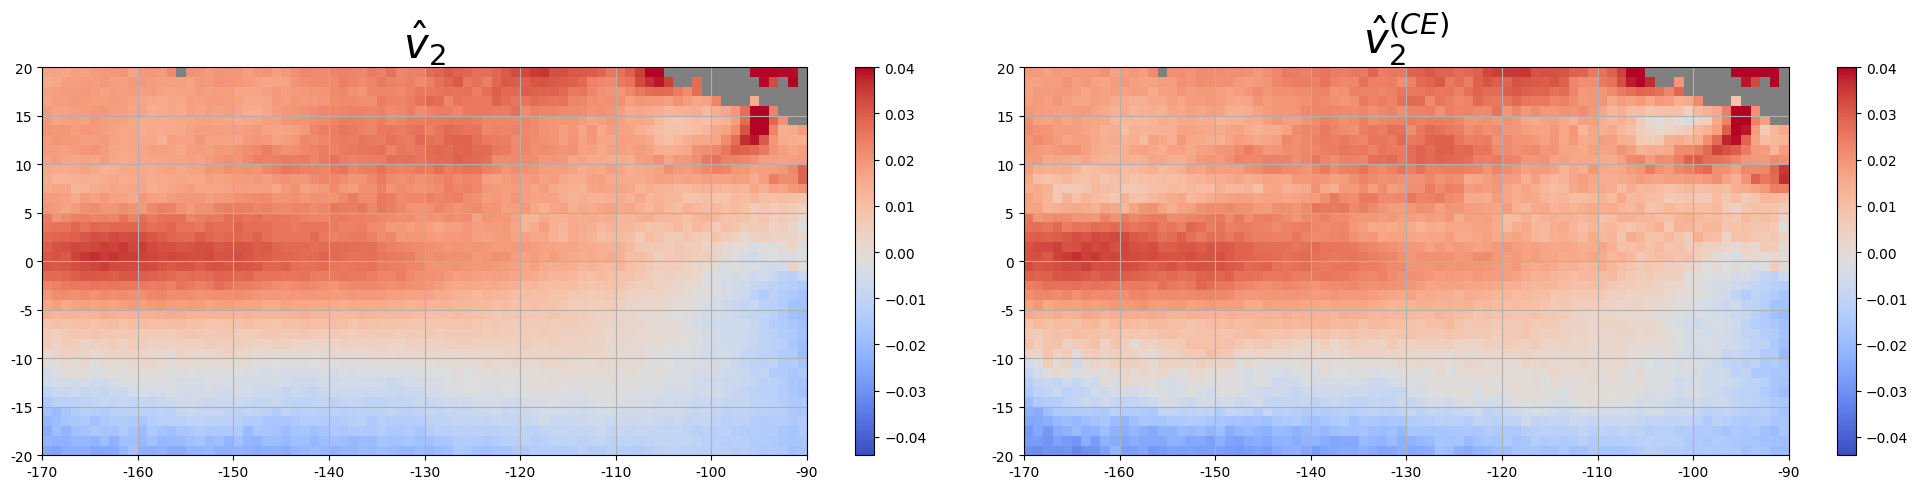

第1個lambda train 1st model time: -0.9001493453979492 秒
第1個lambda train 2nd model time: -1.0454332828521729 秒
第1個lambda train 3rd model time: -1.404710054397583 秒
第1個lambda train SAE model time: -0.7060556411743164 秒
第一個lambda save model time: -0.01031637191772461 秒
using None estimating the loadings
1 estimation time: -1.3048079013824463 秒
SAE resindex = 0.15594437729855093, lambda = 0.0
CAE1 resindex = 0.15644997550461776, lambda = 0
CAE3 resindex = 0.1572382537283428, lambda = 0
CAE5 resindex = 0.15691801537085603, lambda = 0
第2個lambda LOAD model time: -0.008742809295654297 秒
第2個lambda train 1st model time: -0.8852241039276123 秒
第2個lambda train 2nd model time: -1.0792324542999268 秒
第2個lambda train 3rd model time: -1.3939933776855469 秒
第2個lambda train SAE model time: -0.7212584018707275 秒
第2個lambda save model time: -0.010236501693725586 秒
using None estimating the loadings
2 estimation time: -1.3446078300476074 秒
第3個lambda LOAD model time: -0.008186101913452148 秒
第3個lambda train 1st mo

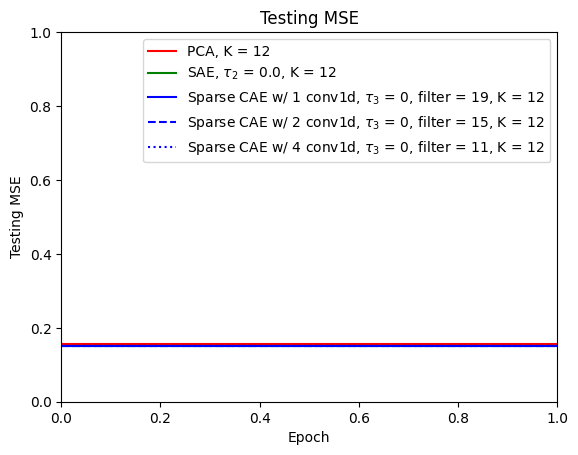

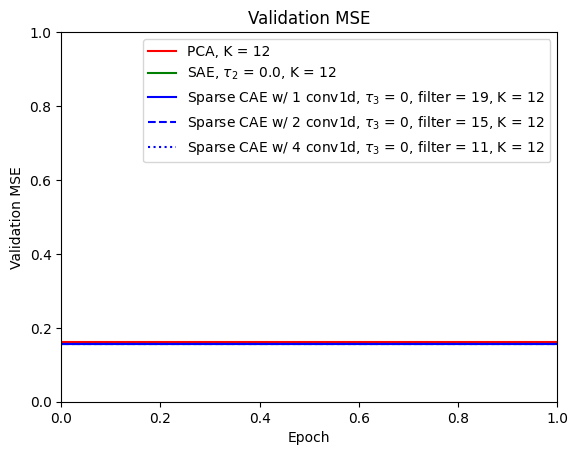

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

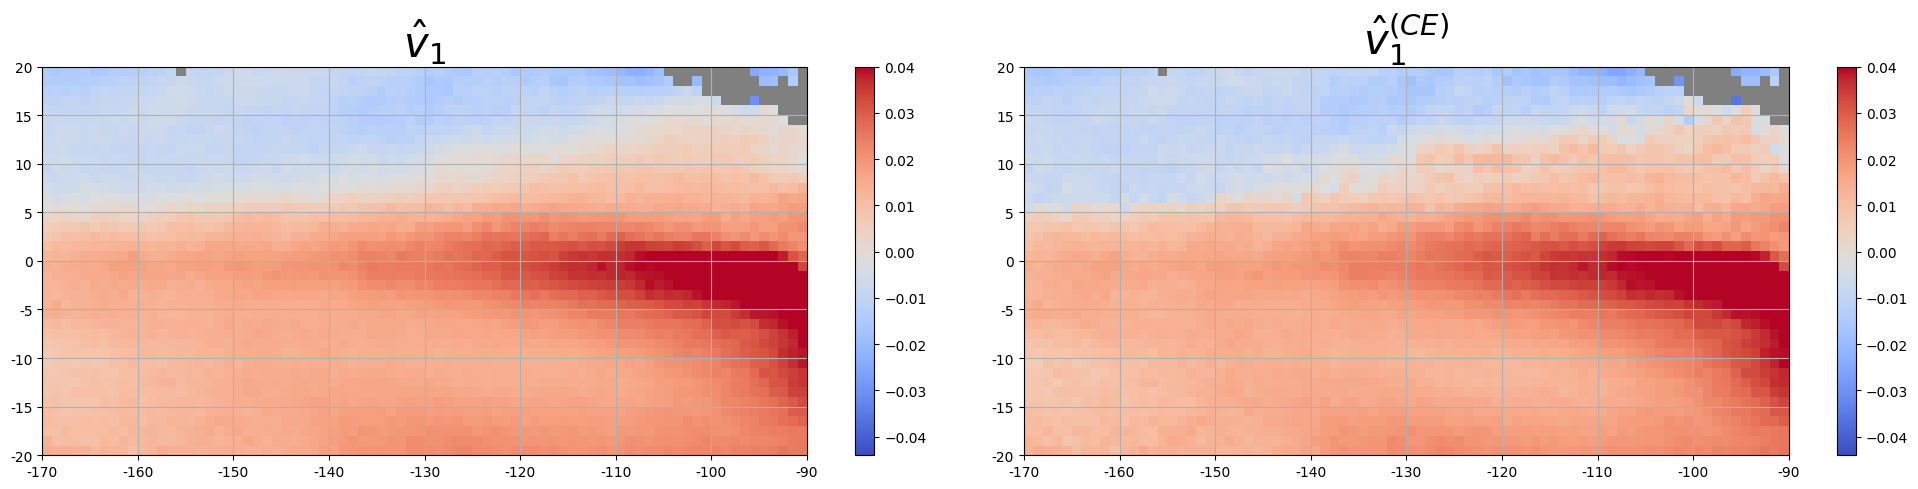

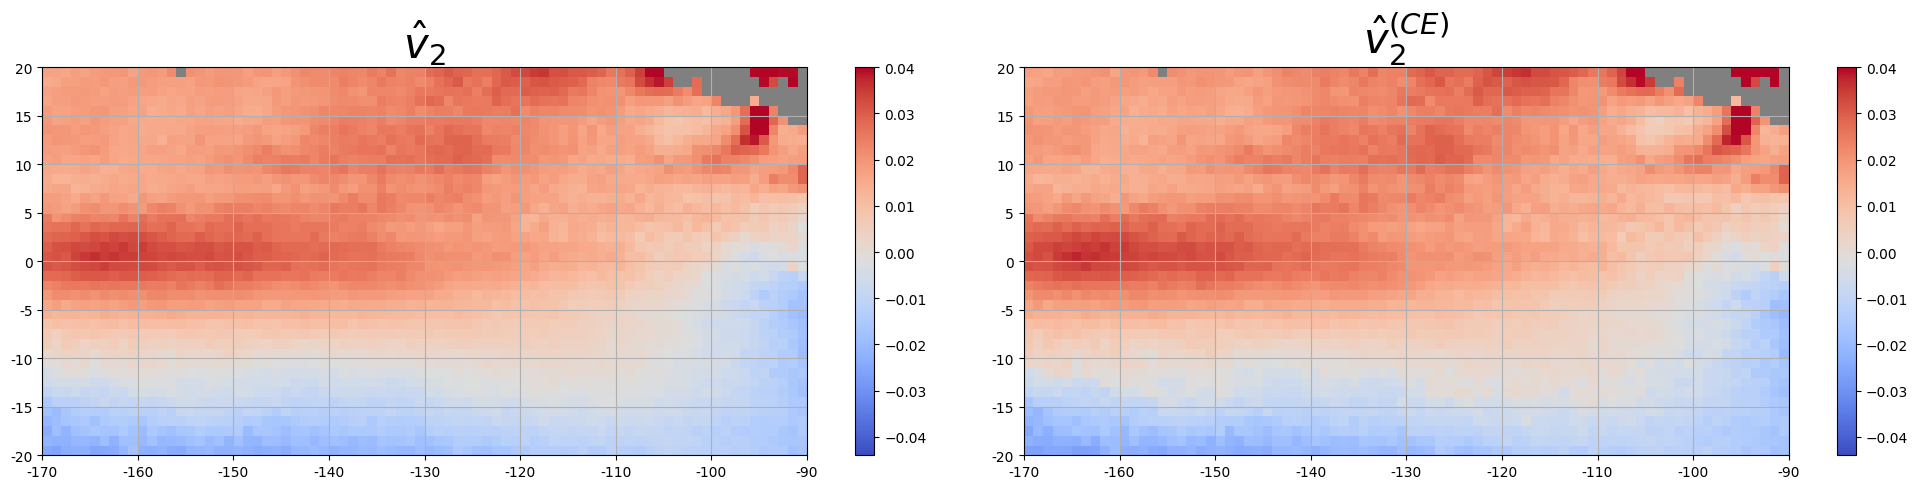

第1個lambda train 1st model time: -0.8898231983184814 秒
第1個lambda train 2nd model time: -1.050898790359497 秒
第1個lambda train 3rd model time: -1.4364814758300781 秒
第1個lambda train SAE model time: -0.71510910987854 秒
第一個lambda save model time: -0.01023101806640625 秒
using None estimating the loadings
1 estimation time: -1.2976469993591309 秒
SAE resindex = 0.15382099251783263, lambda = 0.0
CAE1 resindex = 0.15368628134340448, lambda = 0
CAE3 resindex = 0.1541556066080249, lambda = 0
CAE5 resindex = 0.15457325665011412, lambda = 0
第2個lambda LOAD model time: -0.008630752563476562 秒
第2個lambda train 1st model time: -0.876774787902832 秒
第2個lambda train 2nd model time: -1.0337319374084473 秒
第2個lambda train 3rd model time: -1.3772492408752441 秒
第2個lambda train SAE model time: -0.7120664119720459 秒
第2個lambda save model time: -0.010259389877319336 秒
using None estimating the loadings
2 estimation time: -1.355658769607544 秒
第3個lambda LOAD model time: -0.008272886276245117 秒
第3個lambda train 1st model 

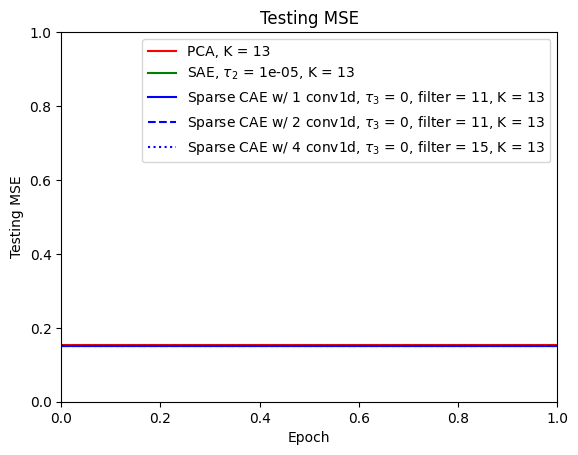

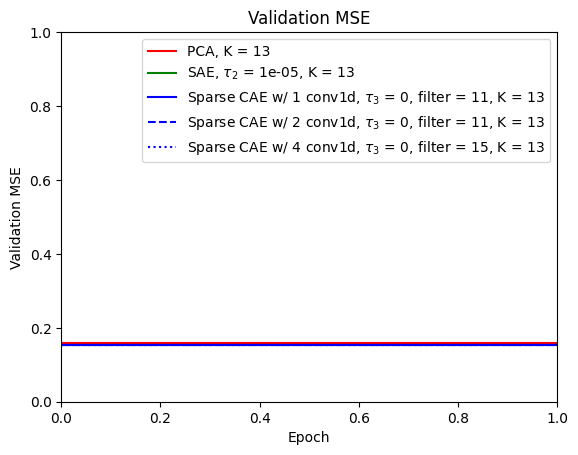

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

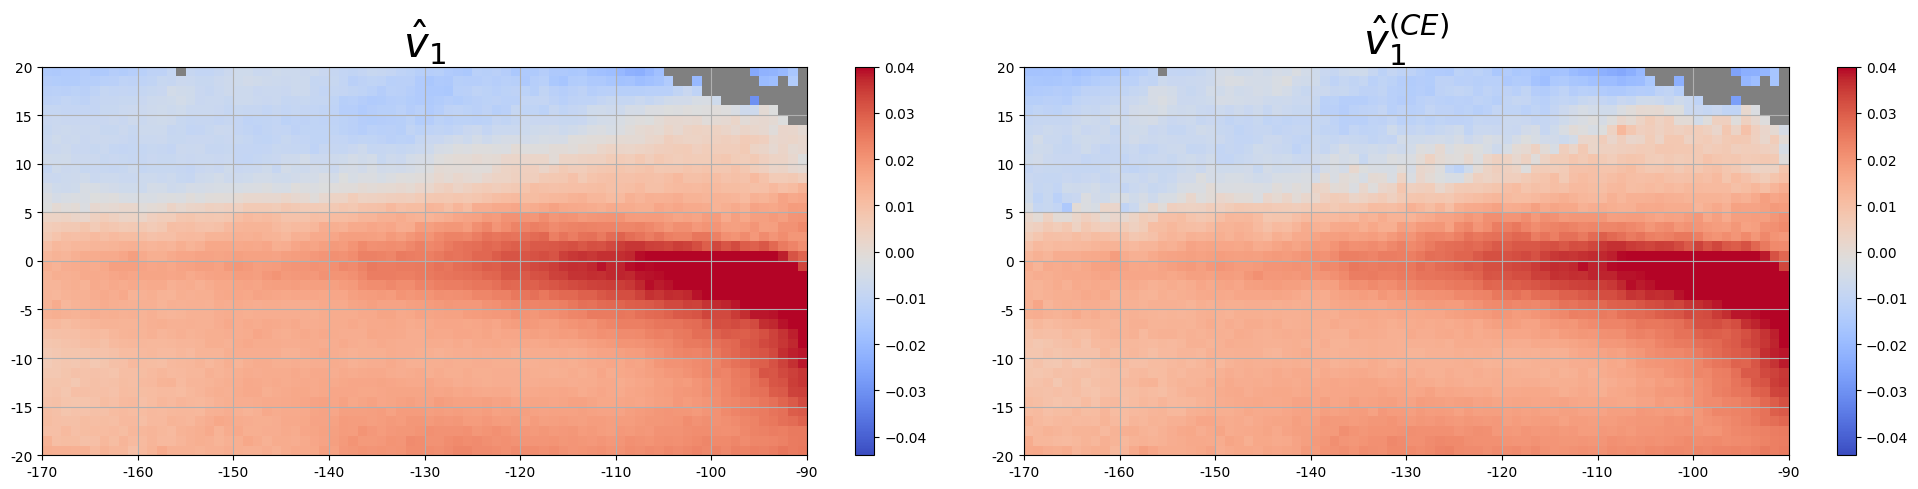

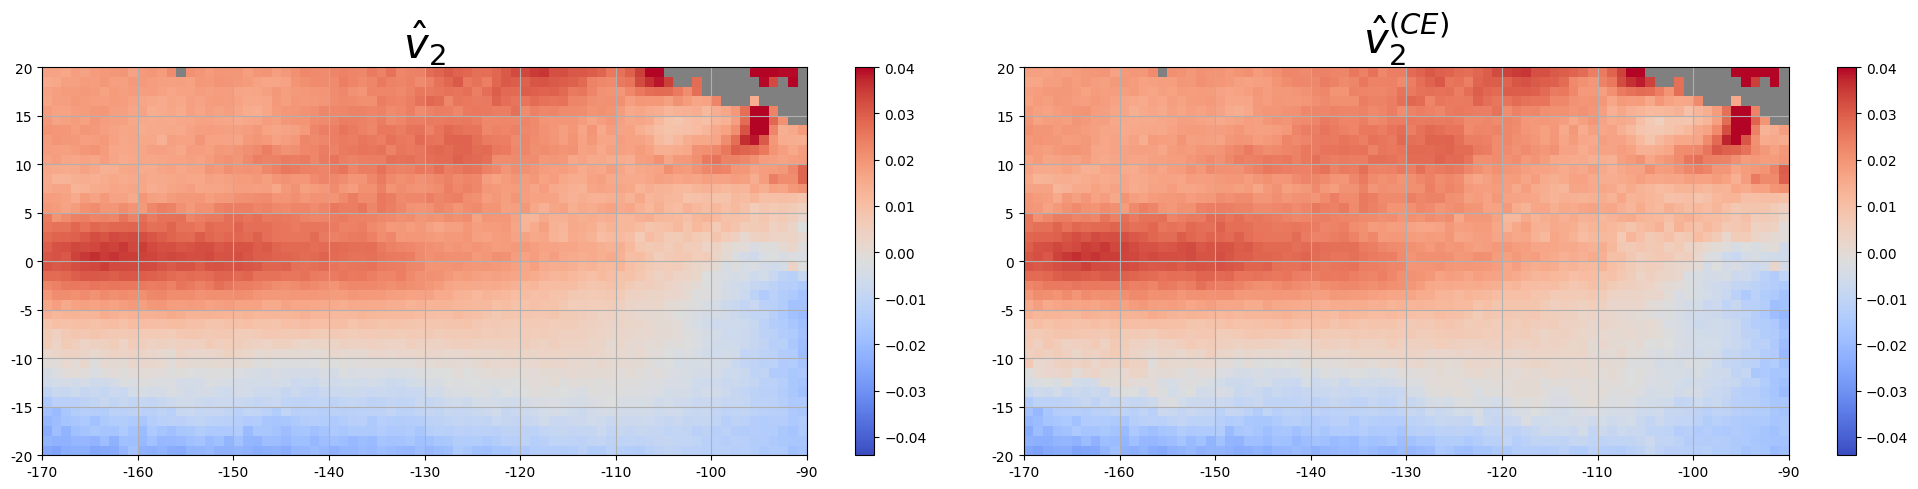

第1個lambda train 1st model time: -0.8867087364196777 秒
第1個lambda train 2nd model time: -1.0892102718353271 秒
第1個lambda train 3rd model time: -1.3424768447875977 秒
第1個lambda train SAE model time: -0.6955544948577881 秒
第一個lambda save model time: -0.010182619094848633 秒
using None estimating the loadings
1 estimation time: -1.2968742847442627 秒
SAE resindex = 0.15242685360783237, lambda = 0.0
CAE1 resindex = 0.1519374448352735, lambda = 0
CAE3 resindex = 0.15336724899426304, lambda = 0
CAE5 resindex = 0.15331406077135945, lambda = 0
第2個lambda LOAD model time: -0.007944107055664062 秒
第2個lambda train 1st model time: -0.8383886814117432 秒
第2個lambda train 2nd model time: -1.0454342365264893 秒
第2個lambda train 3rd model time: -1.3833088874816895 秒
第2個lambda train SAE model time: -0.7029953002929688 秒
第2個lambda save model time: -0.010321378707885742 秒
using None estimating the loadings
2 estimation time: -1.3109958171844482 秒
SAE resindex = 0.15238817587814313, lambda = 1e-05
第3個lambda LOAD model

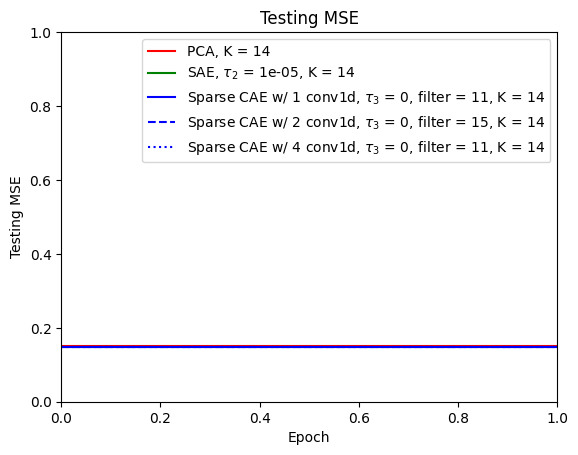

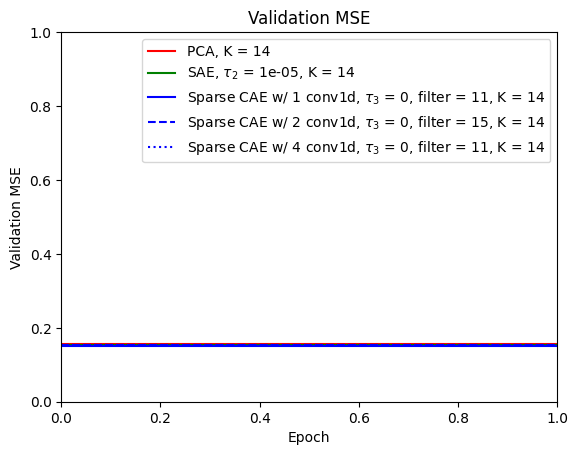

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

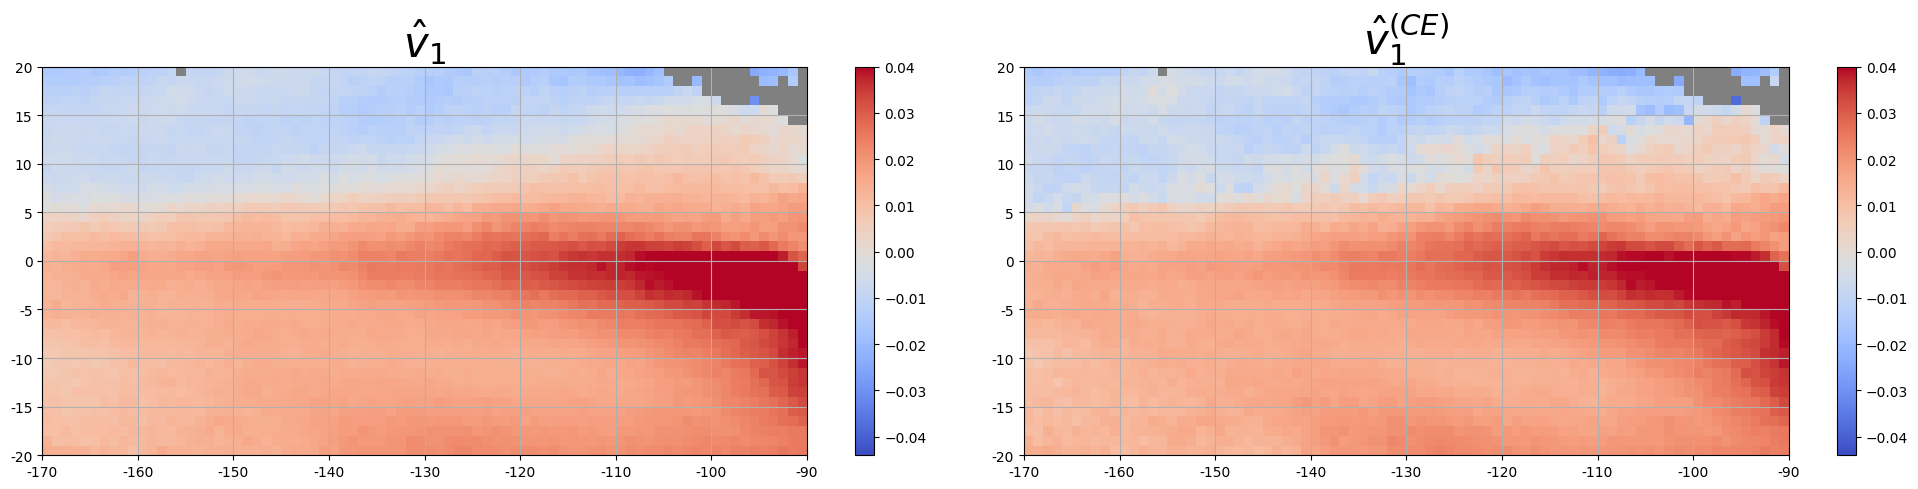

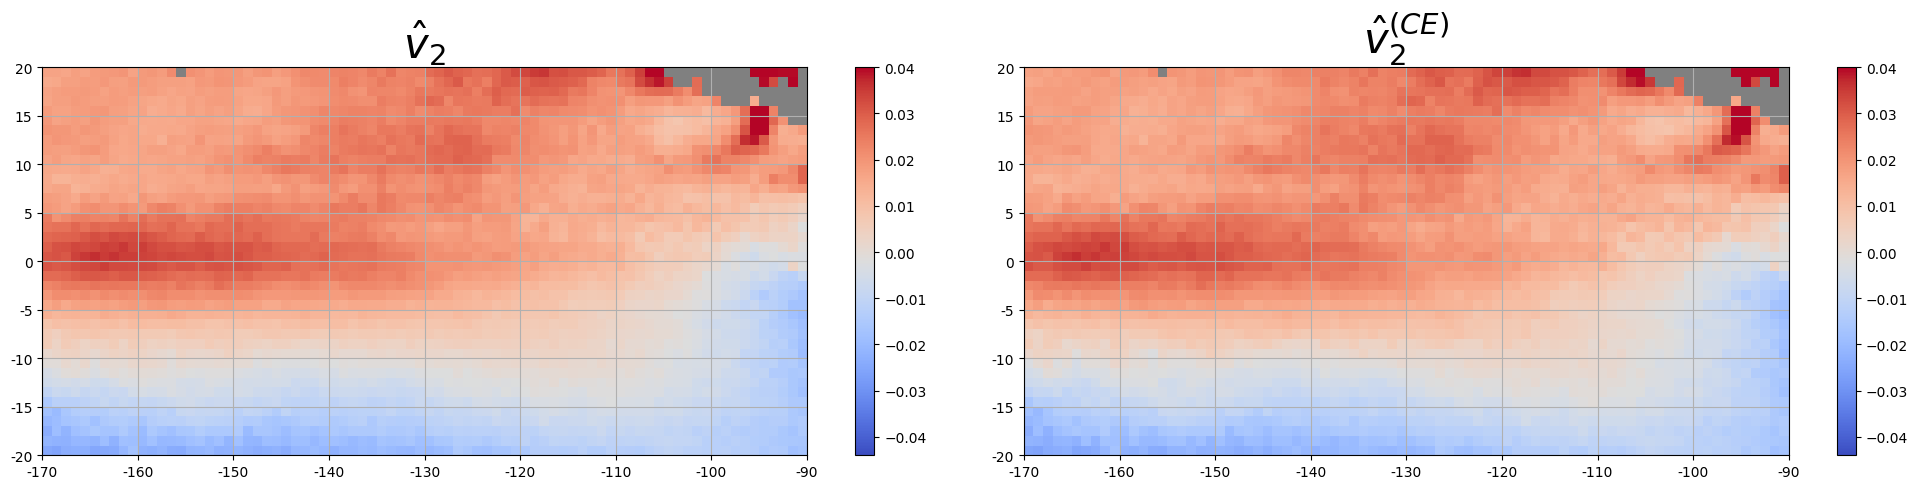

第1個lambda train 1st model time: -0.8483715057373047 秒
第1個lambda train 2nd model time: -1.0318849086761475 秒
第1個lambda train 3rd model time: -1.3766851425170898 秒
第1個lambda train SAE model time: -0.6852290630340576 秒
第一個lambda save model time: -0.010030508041381836 秒
using None estimating the loadings
1 estimation time: -1.3117356300354004 秒
SAE resindex = 0.15074437818130648, lambda = 0.0
CAE1 resindex = 0.151035653676621, lambda = 0
CAE3 resindex = 0.15098502599353464, lambda = 0
CAE5 resindex = 0.1512705334070512, lambda = 0
第2個lambda LOAD model time: -0.008354425430297852 秒
第2個lambda train 1st model time: -0.8755605220794678 秒
第2個lambda train 2nd model time: -1.0329515933990479 秒
第2個lambda train 3rd model time: -1.3578166961669922 秒
第2個lambda train SAE model time: -0.6855337619781494 秒
第2個lambda save model time: -0.010028839111328125 秒
using None estimating the loadings
2 estimation time: -1.2856216430664062 秒
SAE resindex = 0.1505907959448017, lambda = 1e-05
第3個lambda LOAD model ti

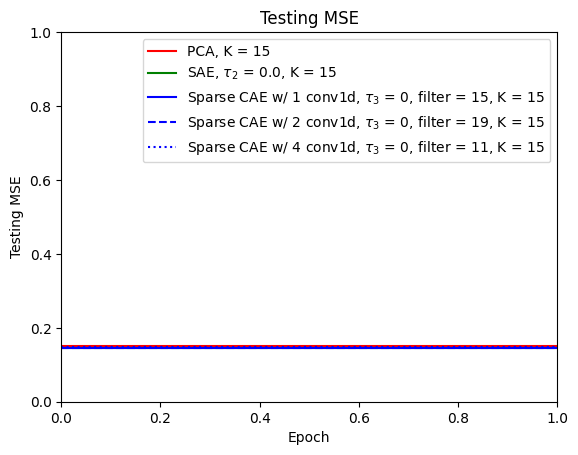

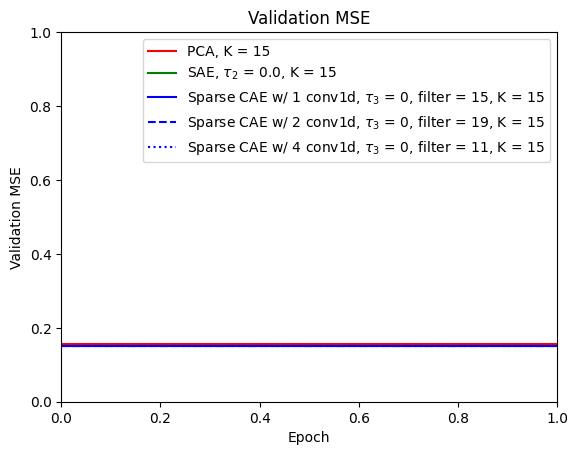

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1877: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1878: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

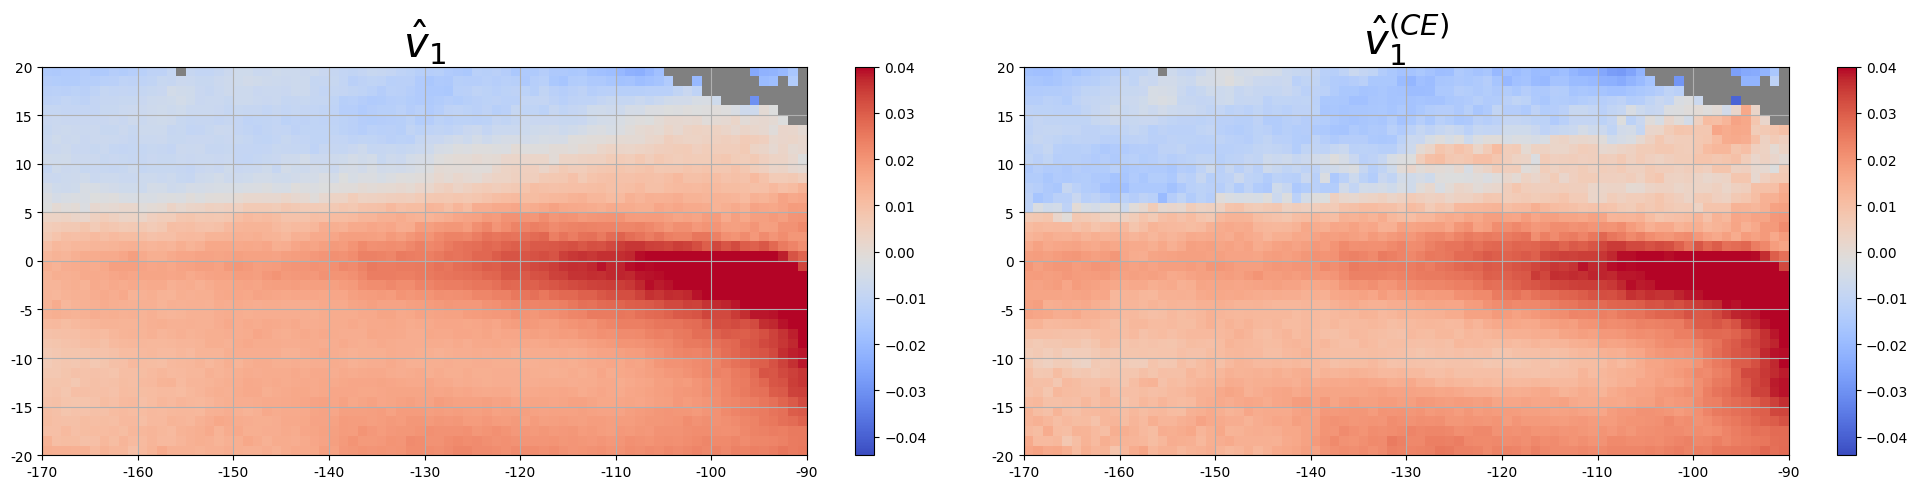

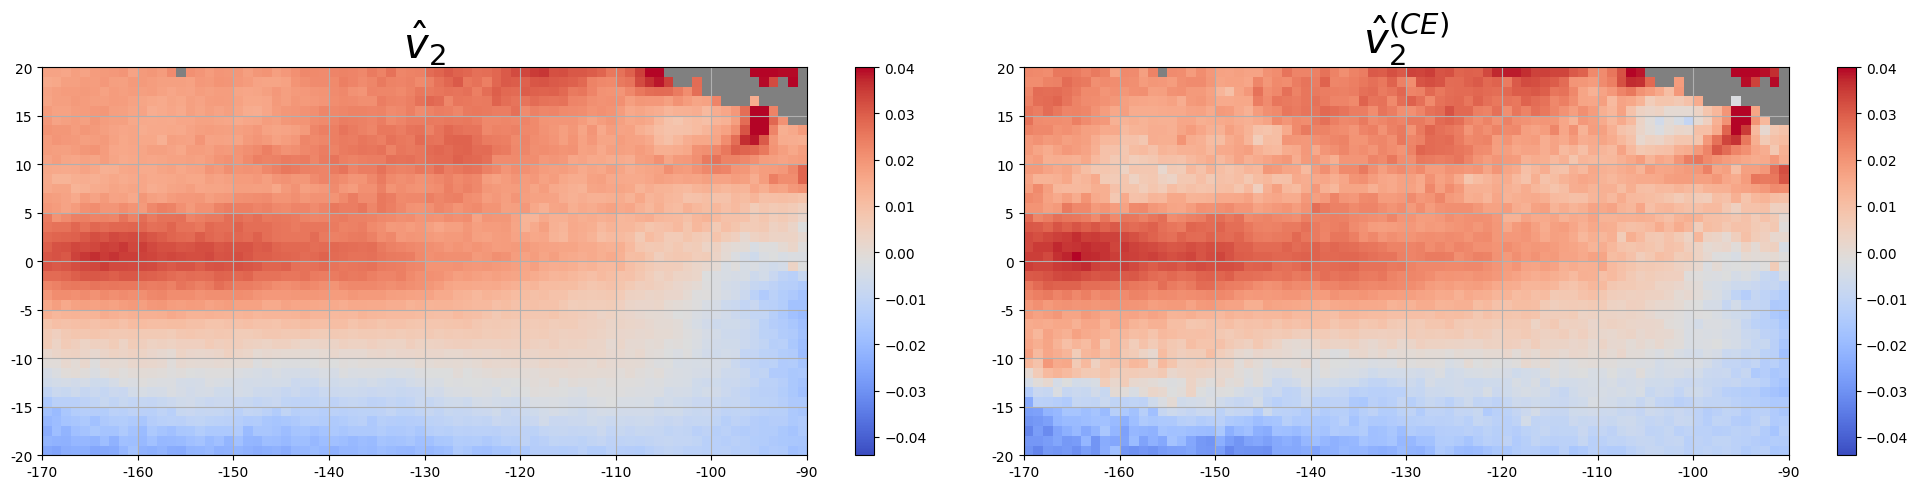

第1個lambda train 1st model time: -0.8475677967071533 秒
第1個lambda train 2nd model time: -1.0123891830444336 秒
第1個lambda train 3rd model time: -1.366858959197998 秒
第1個lambda train SAE model time: -0.7281279563903809 秒
第一個lambda save model time: -0.01208949089050293 秒
using None estimating the loadings
1 estimation time: -1.35060715675354 秒
SAE resindex = 0.14894345020167948, lambda = 0.0
CAE1 resindex = 0.14861613348560232, lambda = 0
CAE3 resindex = 0.14969342998765708, lambda = 0
CAE5 resindex = 0.15057022236663475, lambda = 0
第2個lambda LOAD model time: -0.008150100708007812 秒
第2個lambda train 1st model time: -0.8412728309631348 秒
第2個lambda train 2nd model time: -1.018789291381836 秒
第2個lambda train 3rd model time: -1.344660997390747 秒
第2個lambda train SAE model time: -0.6874697208404541 秒
第2個lambda save model time: -0.010433435440063477 秒
using None estimating the loadings
2 estimation time: -1.3412964344024658 秒
SAE resindex = 0.14890848658593653, lambda = 1e-05
第3個lambda LOAD model time

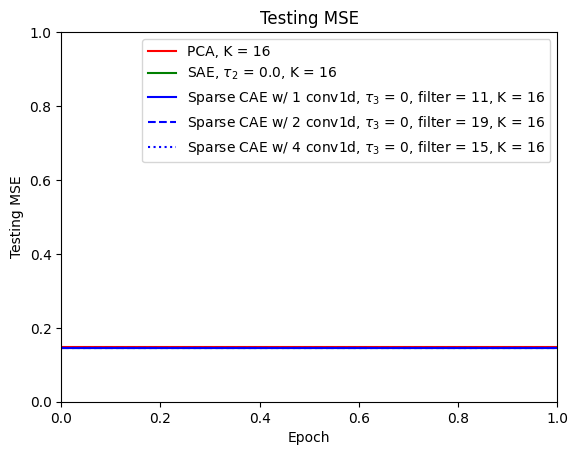

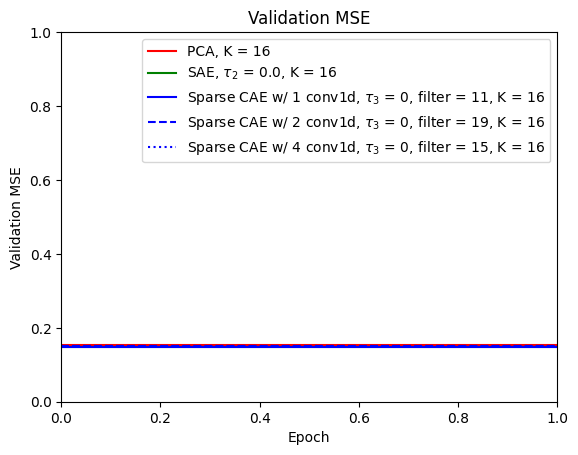

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

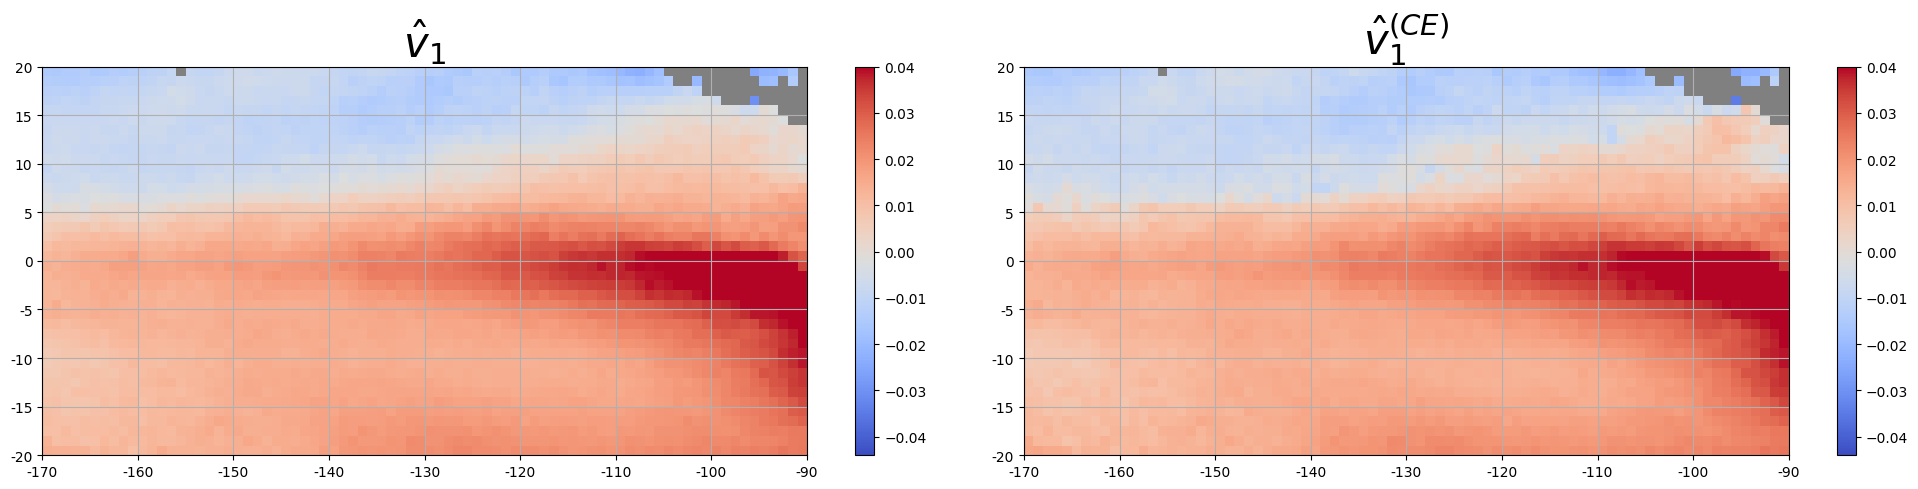

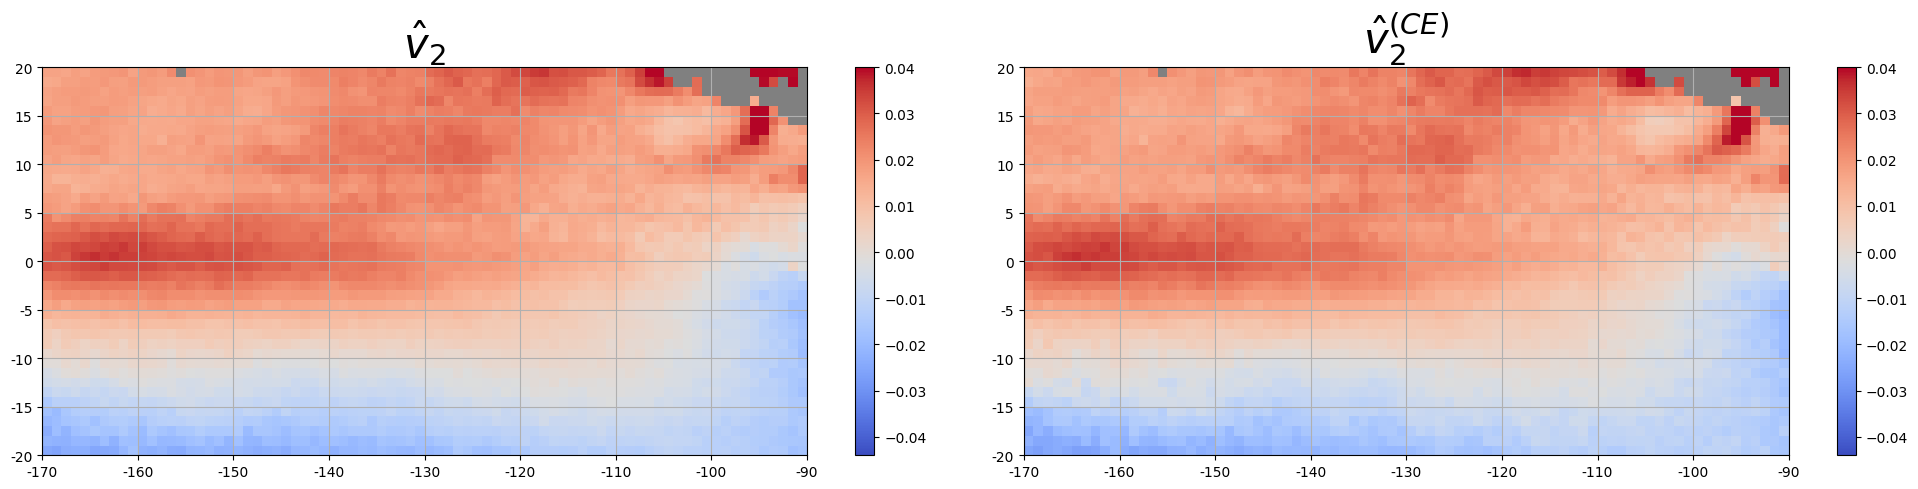

第1個lambda train 1st model time: -0.9402728080749512 秒
第1個lambda train 2nd model time: -1.1380414962768555 秒
第1個lambda train 3rd model time: -1.4589929580688477 秒
第1個lambda train SAE model time: -0.7275552749633789 秒
第一個lambda save model time: -0.010773181915283203 秒
using None estimating the loadings
1 estimation time: -1.2984685897827148 秒
SAE resindex = 0.14805254524250228, lambda = 0.0
CAE1 resindex = 0.1477295788287939, lambda = 0
CAE3 resindex = 0.1478814846839534, lambda = 0
第2個lambda LOAD model time: -0.009871959686279297 秒
第2個lambda train 1st model time: -0.9358689785003662 秒
第2個lambda train 2nd model time: -1.091843605041504 秒
第2個lambda train 3rd model time: -1.440040111541748 秒
第2個lambda train SAE model time: -0.7265632152557373 秒
第2個lambda save model time: -0.011121988296508789 秒
using None estimating the loadings
2 estimation time: -1.29360032081604 秒
SAE resindex = 0.14764608627205636, lambda = 1e-05
第3個lambda LOAD model time: -0.009189128875732422 秒
第3個lambda train 1st mo

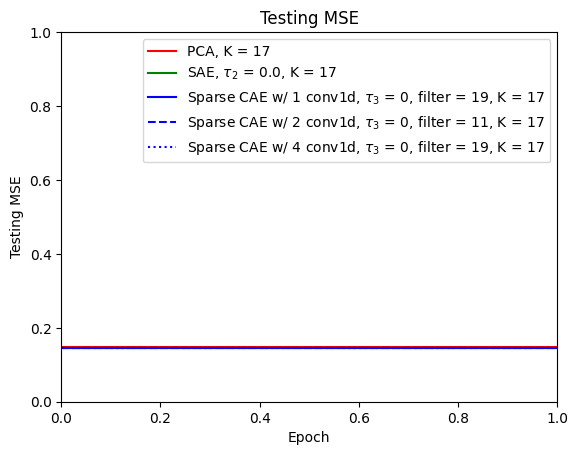

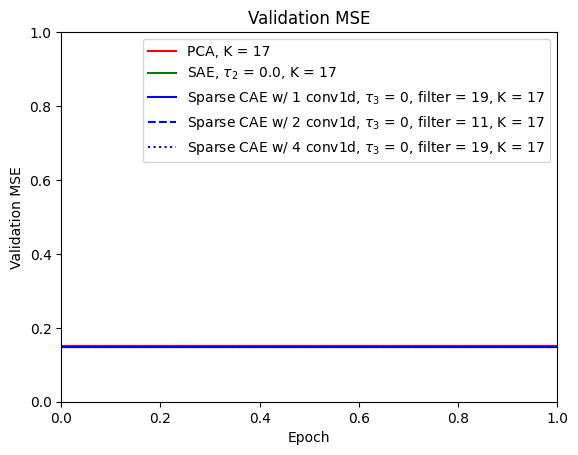

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

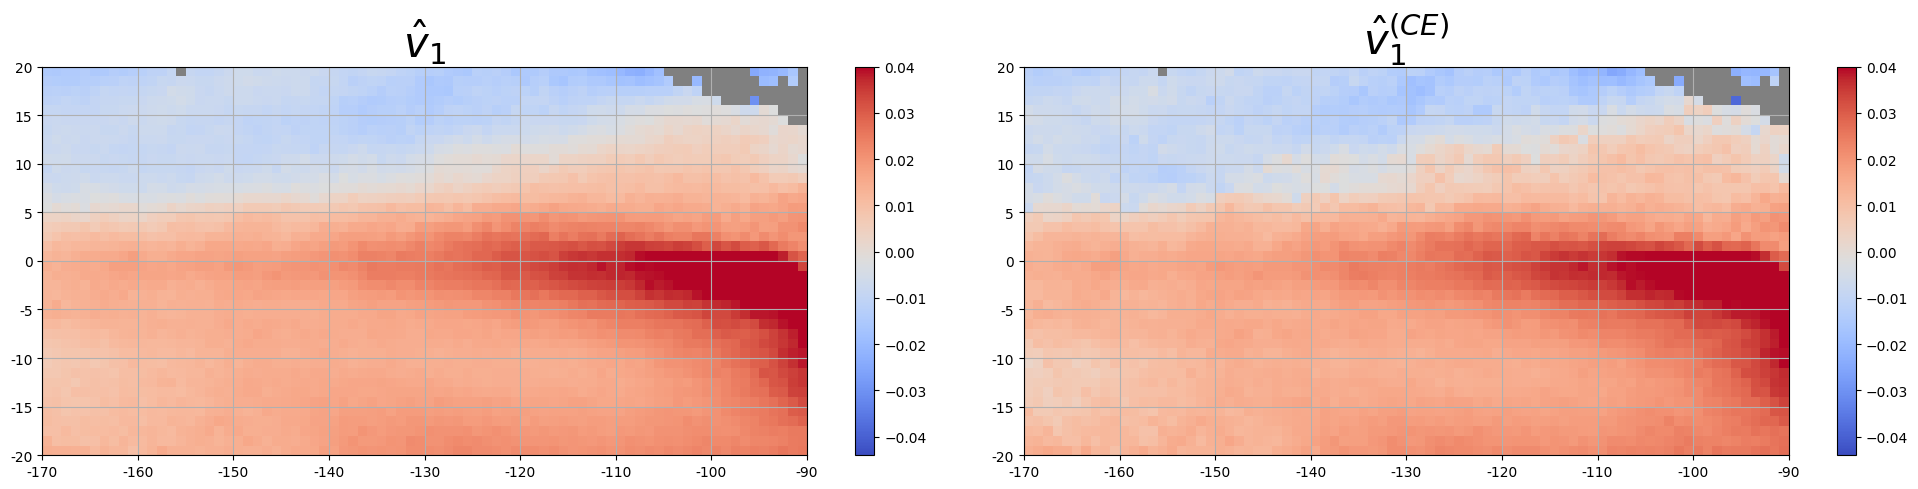

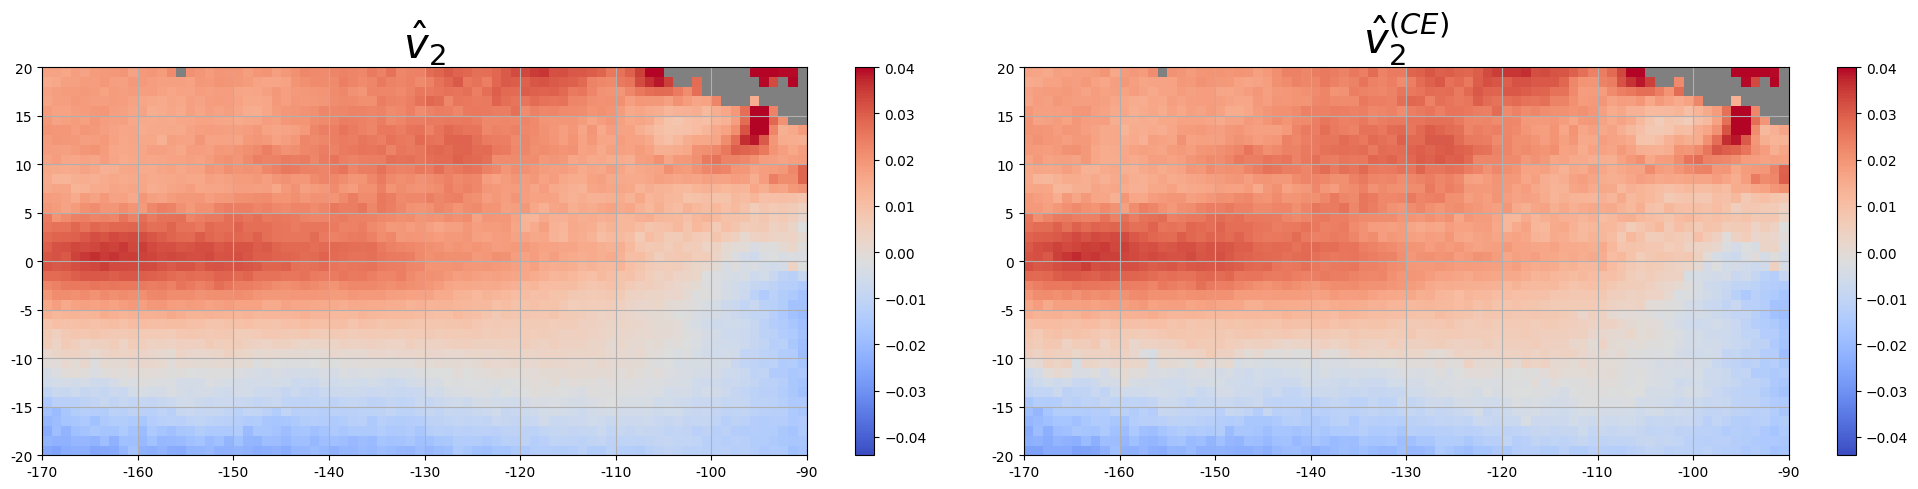

第1個lambda train 1st model time: -0.8873777389526367 秒
第1個lambda train 2nd model time: -1.0667848587036133 秒
第1個lambda train 3rd model time: -1.396740436553955 秒
第1個lambda train SAE model time: -0.7176384925842285 秒
第一個lambda save model time: -0.011445045471191406 秒
using None estimating the loadings
1 estimation time: -1.3263282775878906 秒
SAE resindex = 0.14642799376411347, lambda = 0.0
CAE1 resindex = 0.14632486976552572, lambda = 0
CAE3 resindex = 0.1469707644363017, lambda = 0
CAE5 resindex = 0.14811007310053576, lambda = 0
第2個lambda LOAD model time: -0.009256839752197266 秒
第2個lambda train 1st model time: -0.9230594635009766 秒
第2個lambda train 2nd model time: -1.0846543312072754 秒
第2個lambda train 3rd model time: -1.4421741962432861 秒
第2個lambda train SAE model time: -0.7318625450134277 秒
第2個lambda save model time: -0.011210918426513672 秒
using None estimating the loadings
2 estimation time: -1.338698387145996 秒
SAE resindex = 0.1463181955982717, lambda = 1e-05
第3個lambda LOAD model ti

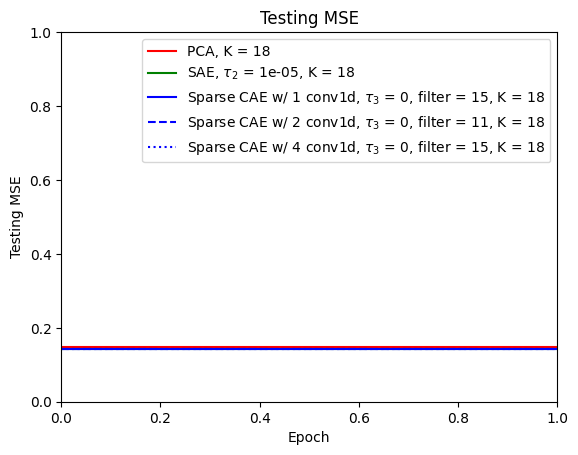

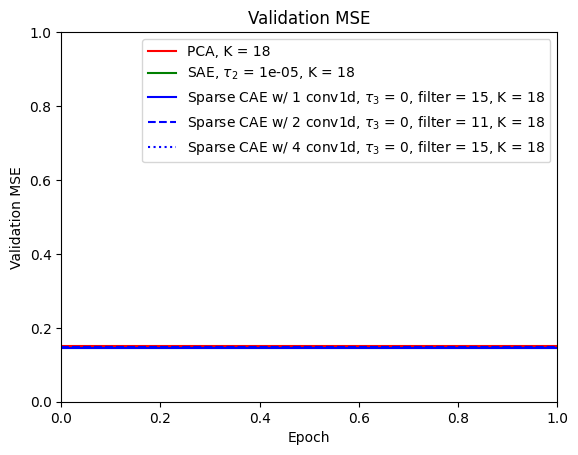

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

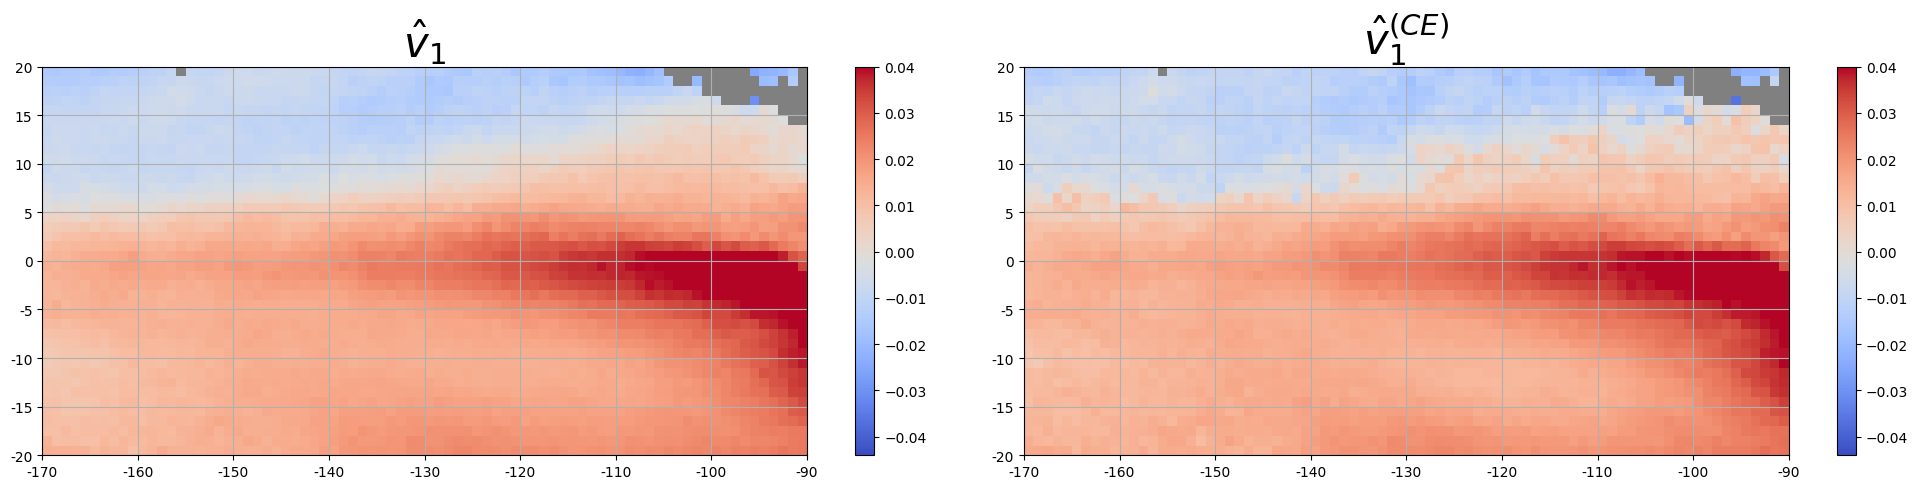

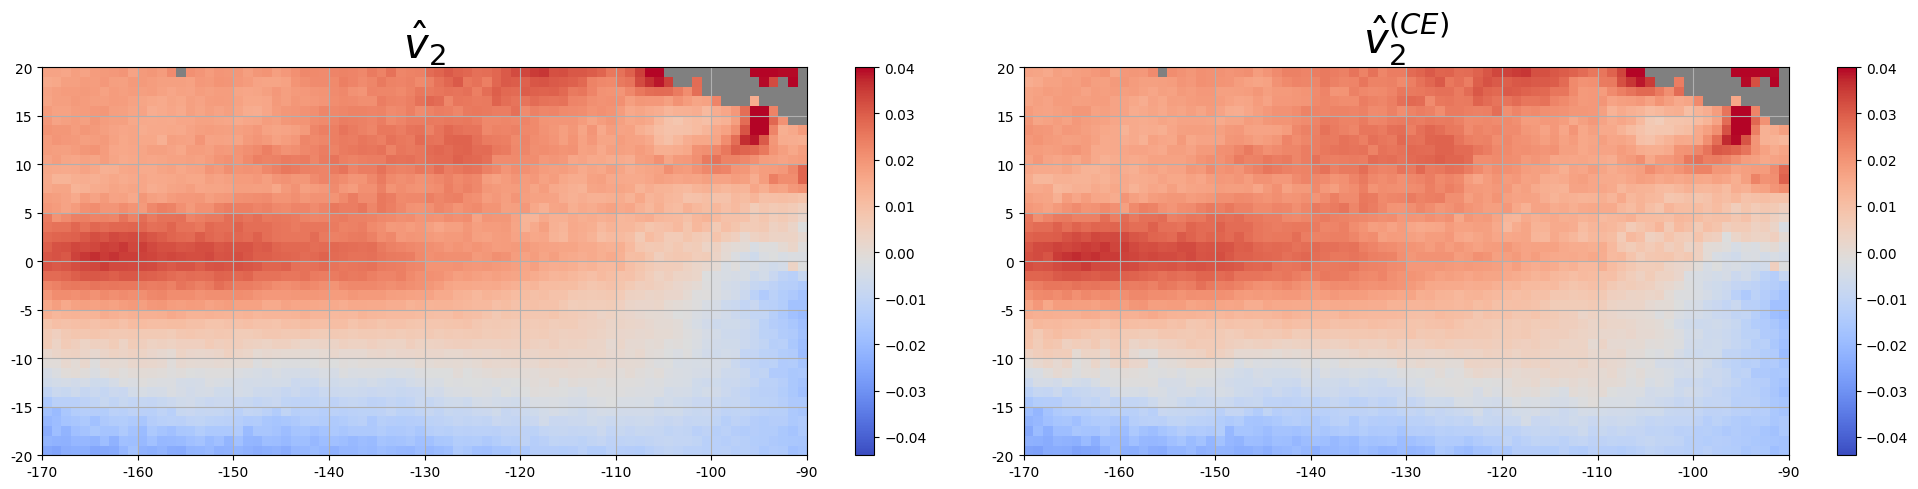

第1個lambda train 1st model time: -0.8858699798583984 秒
第1個lambda train 2nd model time: -1.0495672225952148 秒
第1個lambda train 3rd model time: -1.366199016571045 秒
第1個lambda train SAE model time: -0.7021527290344238 秒
第一個lambda save model time: -0.010661125183105469 秒
using None estimating the loadings
1 estimation time: -1.3164680004119873 秒
SAE resindex = 0.14599272480598105, lambda = 0.0
CAE1 resindex = 0.14563635784882037, lambda = 0
CAE3 resindex = 0.1462343843260348, lambda = 0
CAE5 resindex = 0.14661049284267585, lambda = 0
第2個lambda LOAD model time: -0.009067058563232422 秒
第2個lambda train 1st model time: -0.8575797080993652 秒
第2個lambda train 2nd model time: -1.0358028411865234 秒
第2個lambda train 3rd model time: -1.4388203620910645 秒
第2個lambda train SAE model time: -0.6866366863250732 秒
第2個lambda save model time: -0.010233163833618164 秒
using None estimating the loadings
2 estimation time: -1.3166165351867676 秒
SAE resindex = 0.14581082054059258, lambda = 1e-05
第3個lambda LOAD model 

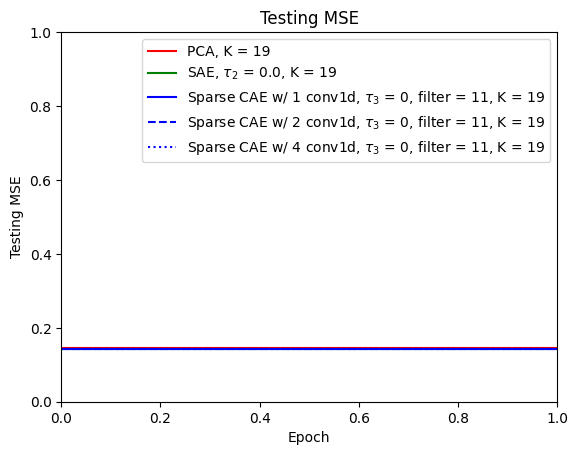

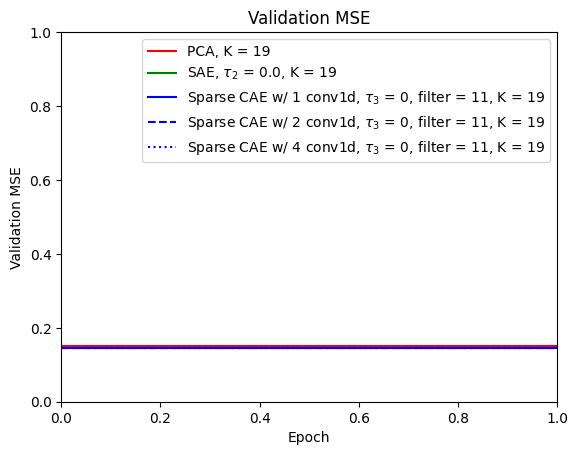

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

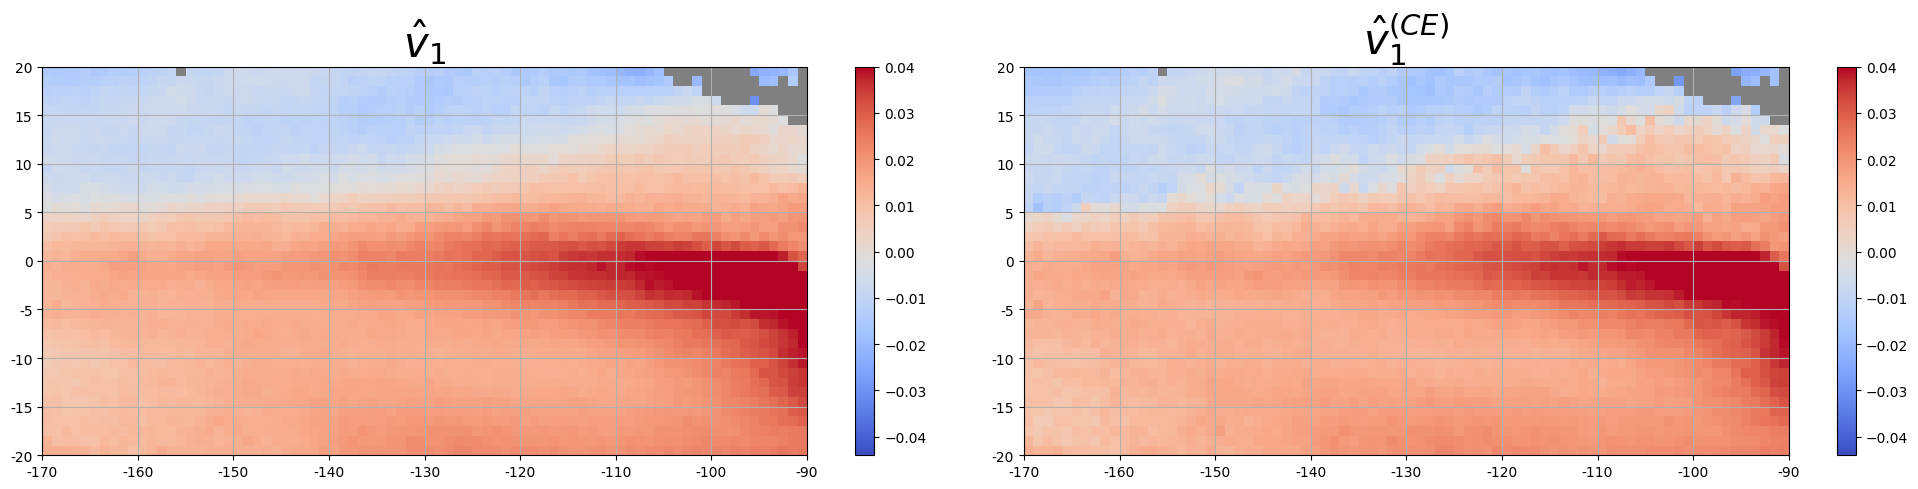

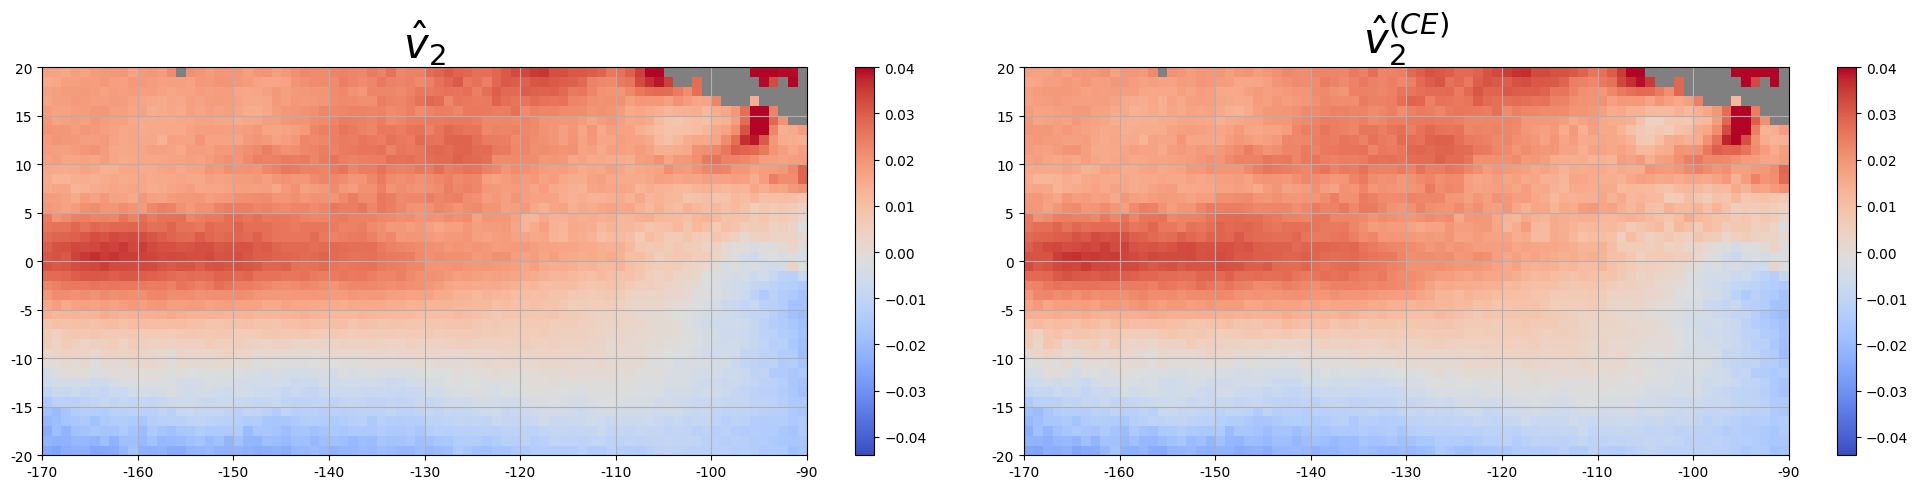

第1個lambda train 1st model time: -0.8510818481445312 秒
第1個lambda train 2nd model time: -1.0256879329681396 秒
第1個lambda train 3rd model time: -1.3407580852508545 秒
第1個lambda train SAE model time: -0.6943793296813965 秒
第一個lambda save model time: -0.011977672576904297 秒
using None estimating the loadings
1 estimation time: -1.2948598861694336 秒
SAE resindex = 0.14435266305235162, lambda = 0.0
CAE1 resindex = 0.14468300042381096, lambda = 0
CAE3 resindex = 0.145960766956313, lambda = 0
第2個lambda LOAD model time: -0.009031295776367188 秒
第2個lambda train 1st model time: -0.8666999340057373 秒
第2個lambda train 2nd model time: -1.0488994121551514 秒
第2個lambda train 3rd model time: -1.5069465637207031 秒
第2個lambda train SAE model time: -0.715986967086792 秒
第2個lambda save model time: -0.011446714401245117 秒
using None estimating the loadings
2 estimation time: -1.3077418804168701 秒
第3個lambda LOAD model time: -0.008587837219238281 秒
第3個lambda train 1st model time: -0.9637324810028076 秒
第3個lambda train 

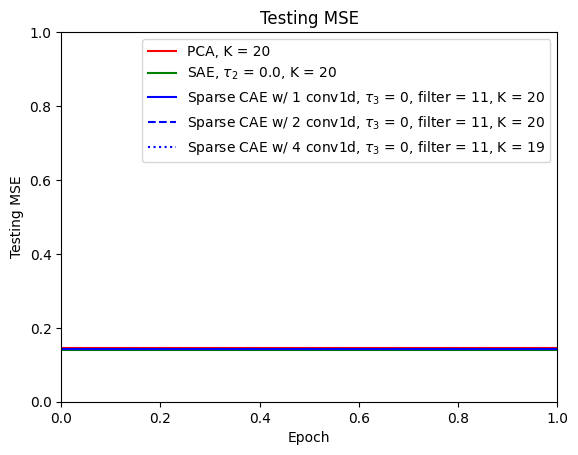

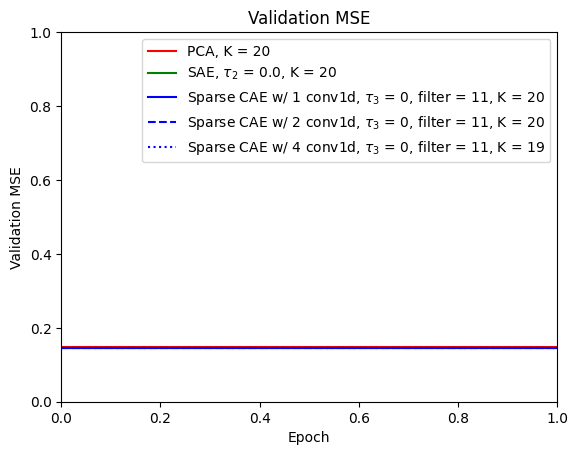

<ipython-input-47-ae236611d1b9>:1755: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:1784: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1785: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:1846: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:1847: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

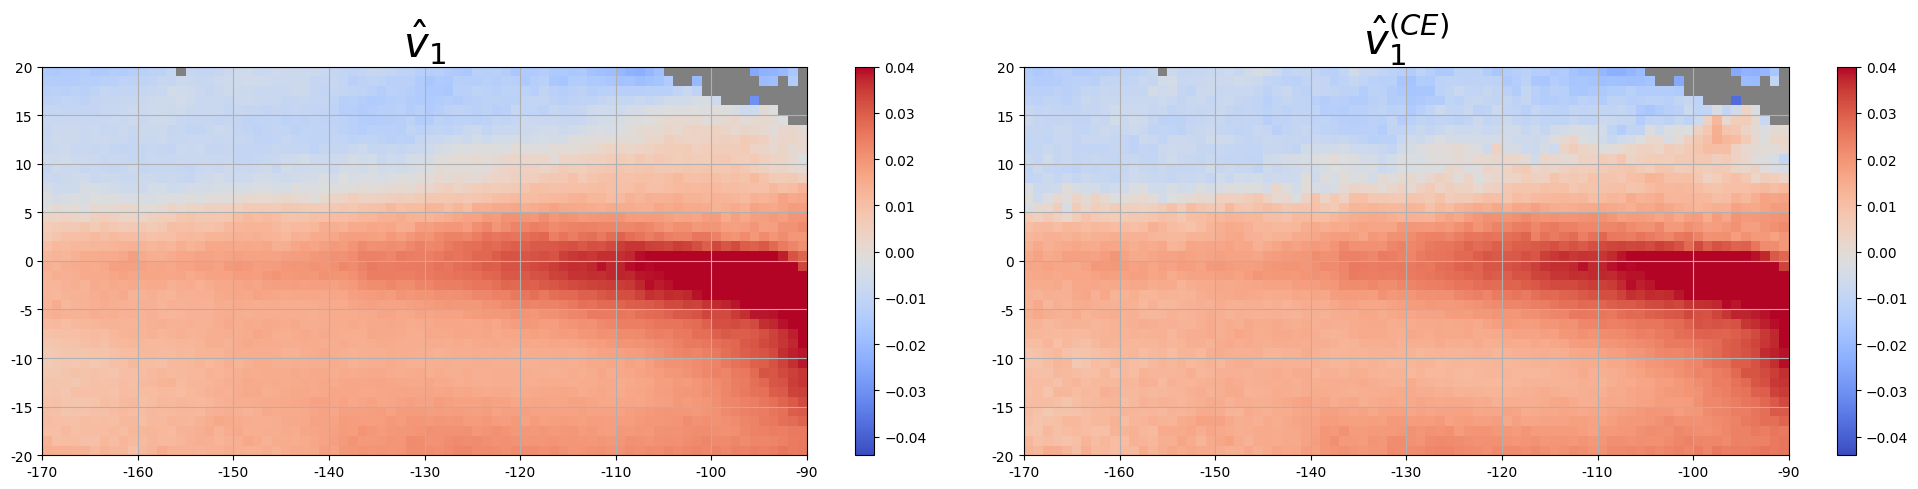

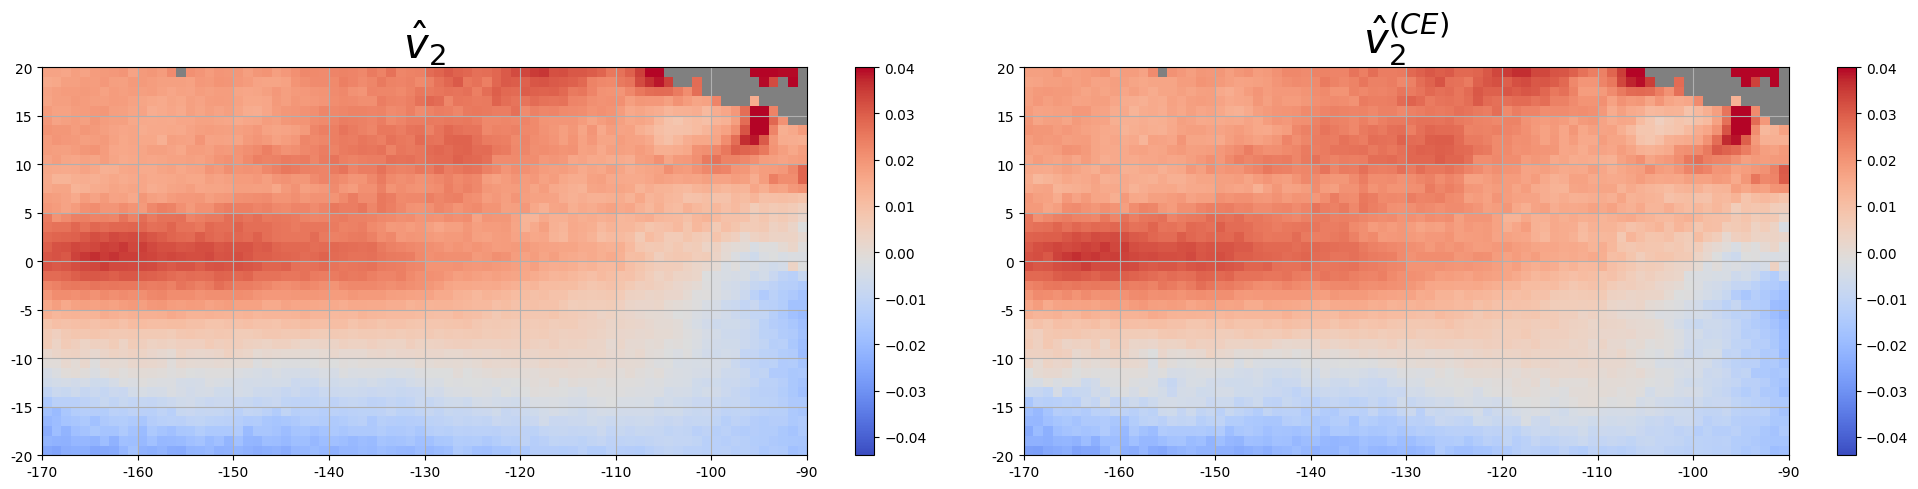

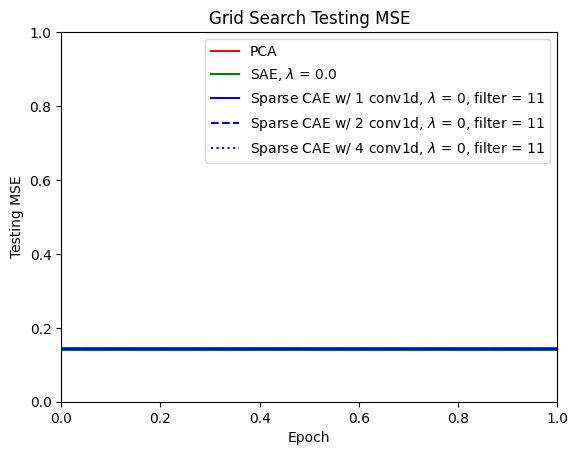

<ipython-input-47-ae236611d1b9>:2097: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:2125: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:2126: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:2163: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:2164: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_ytic

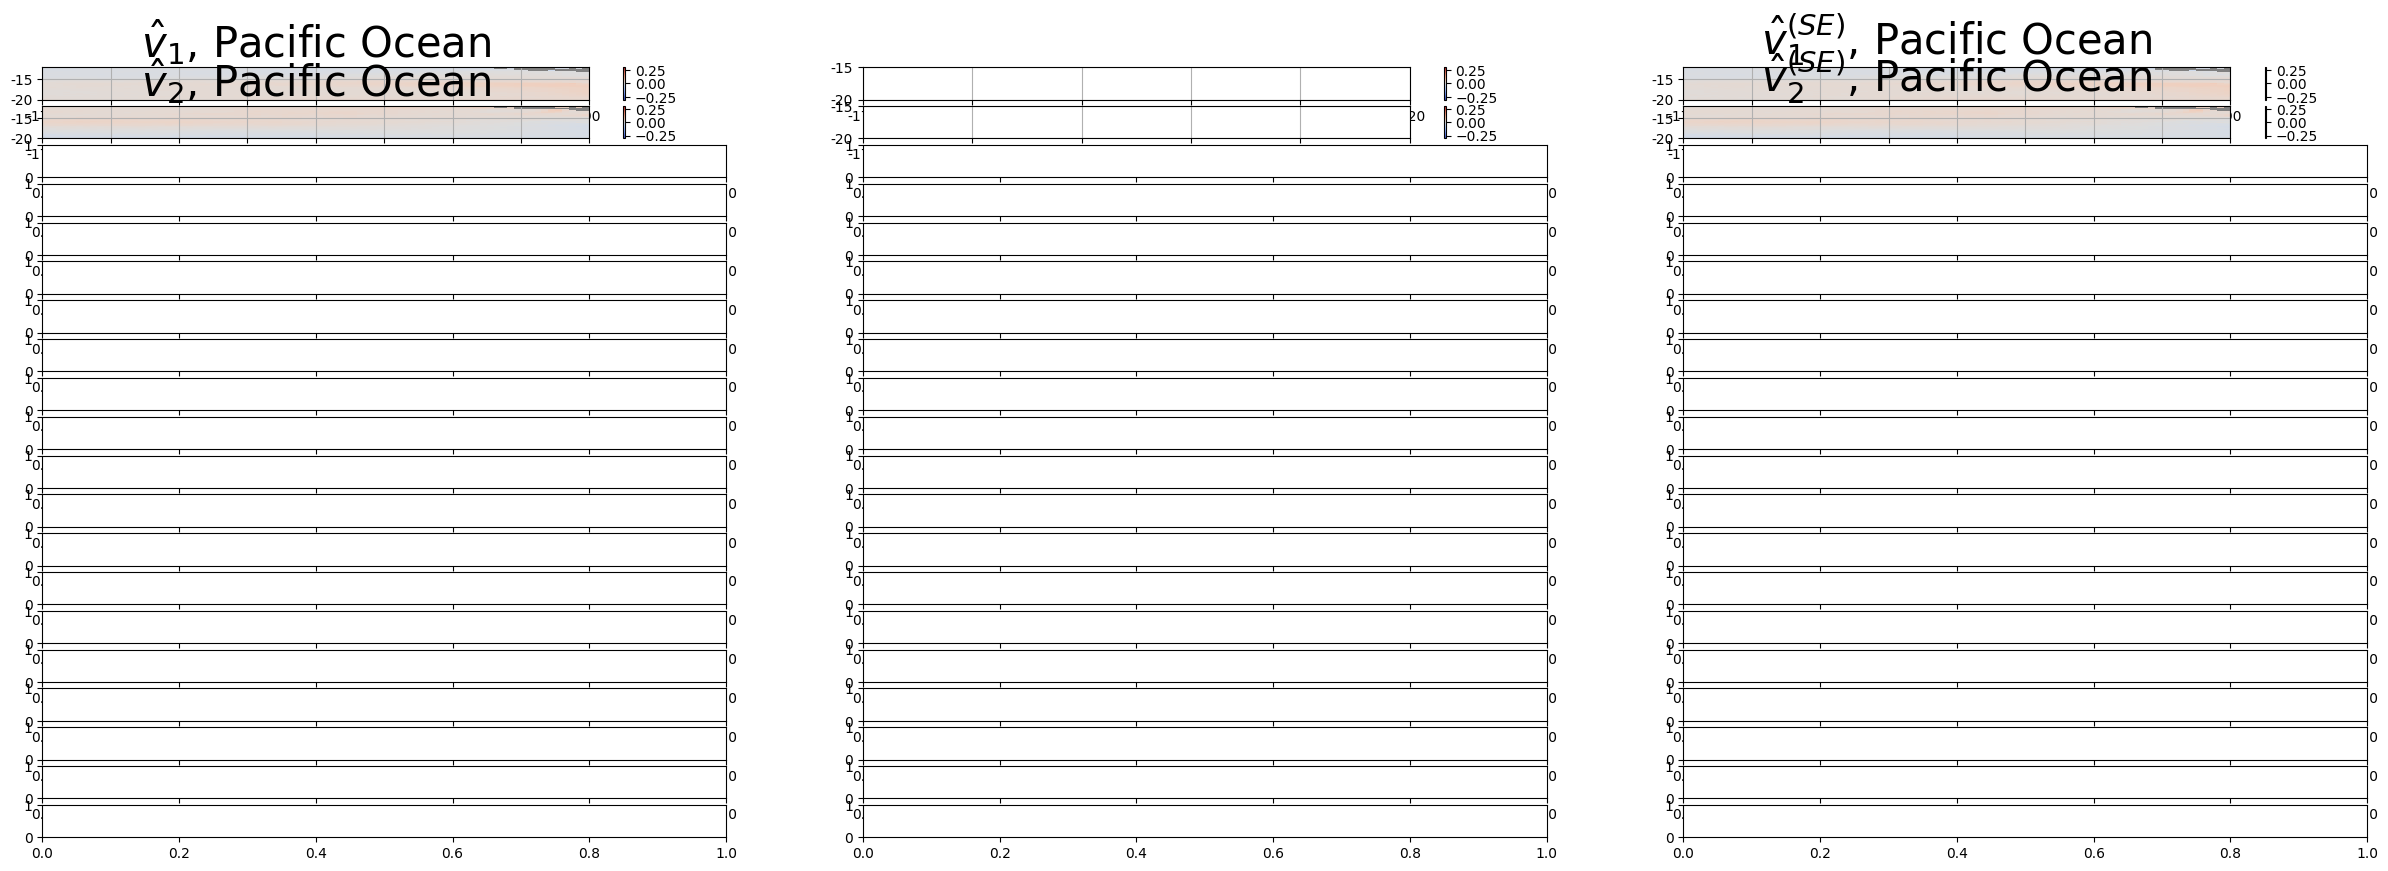

<ipython-input-47-ae236611d1b9>:2211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:2239: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:2240: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:2269: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:2270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_ytic

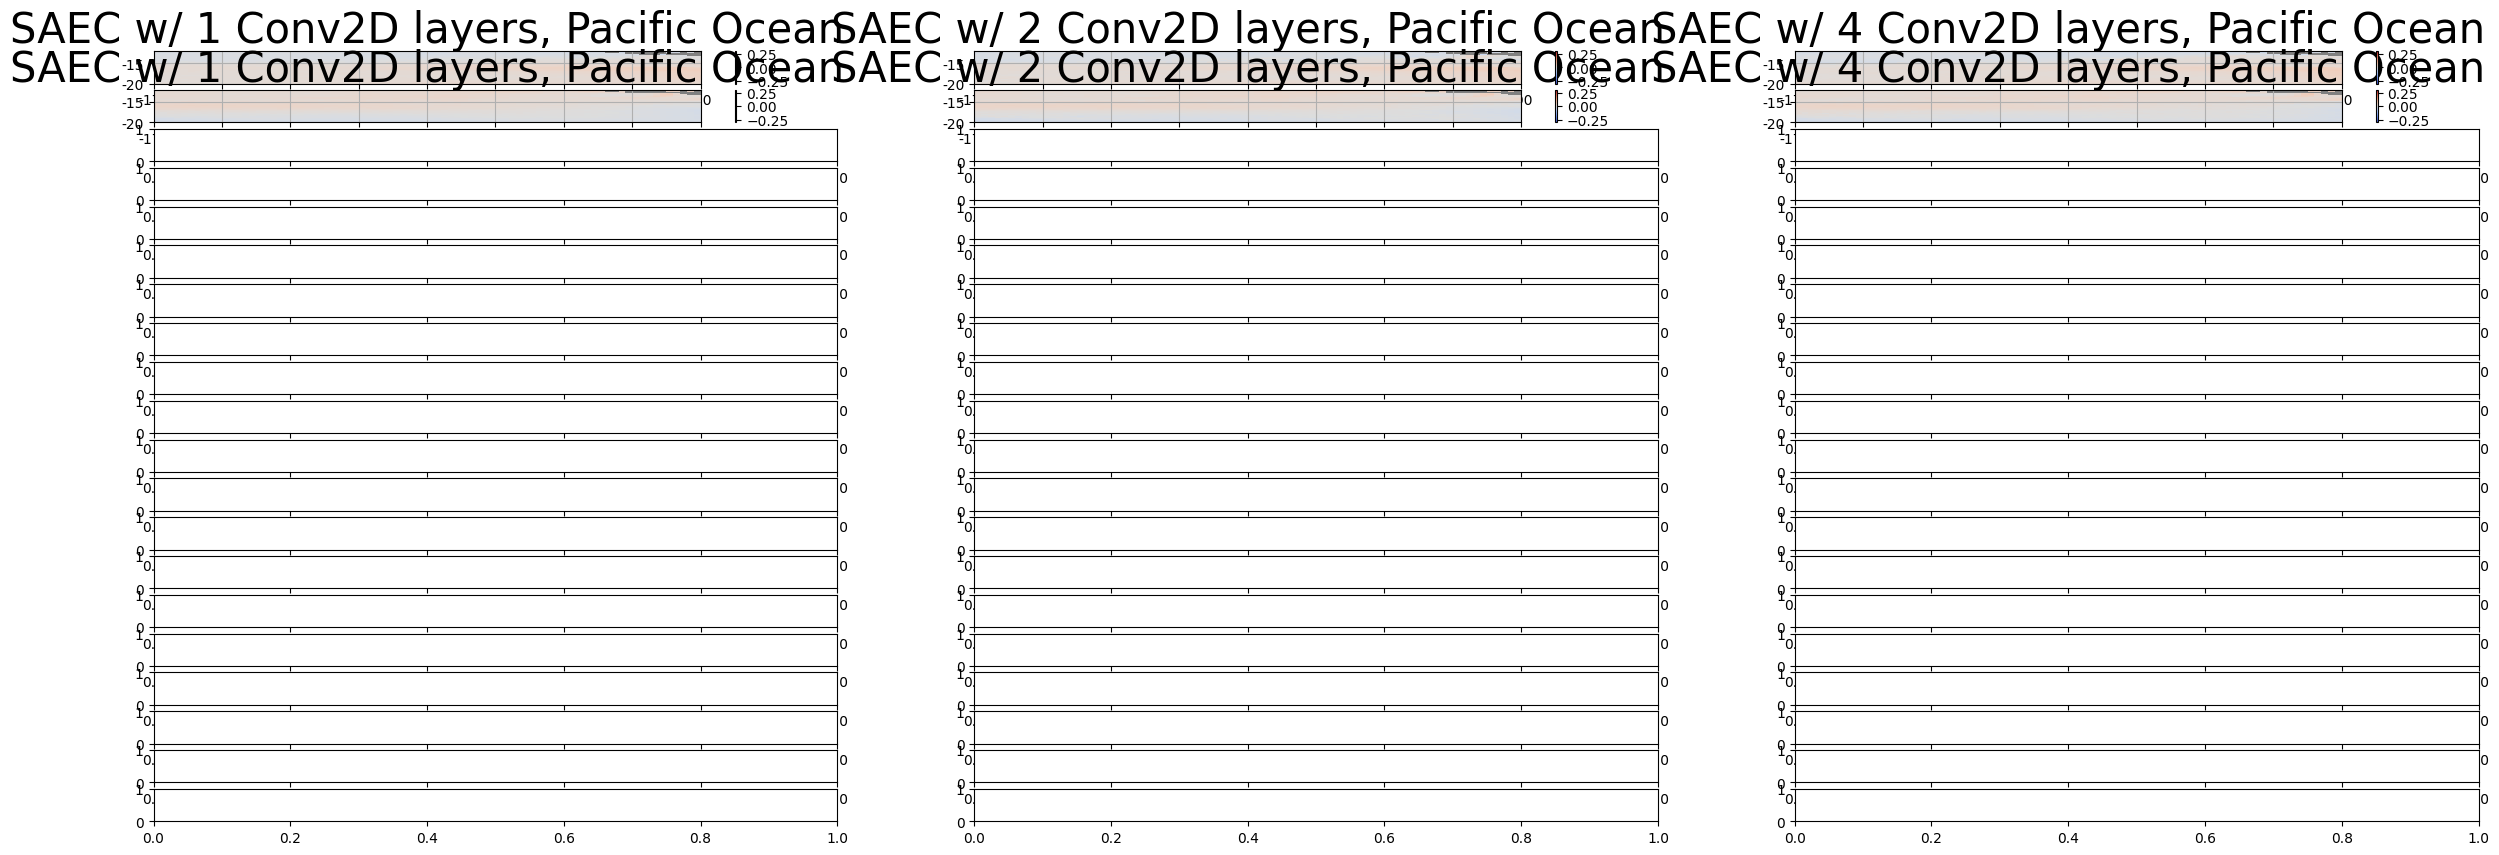

<ipython-input-47-ae236611d1b9>:2325: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-47-ae236611d1b9>:2354: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:2355: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-47-ae236611d1b9>:2416: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-47-ae236611d1b9>:2417: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20

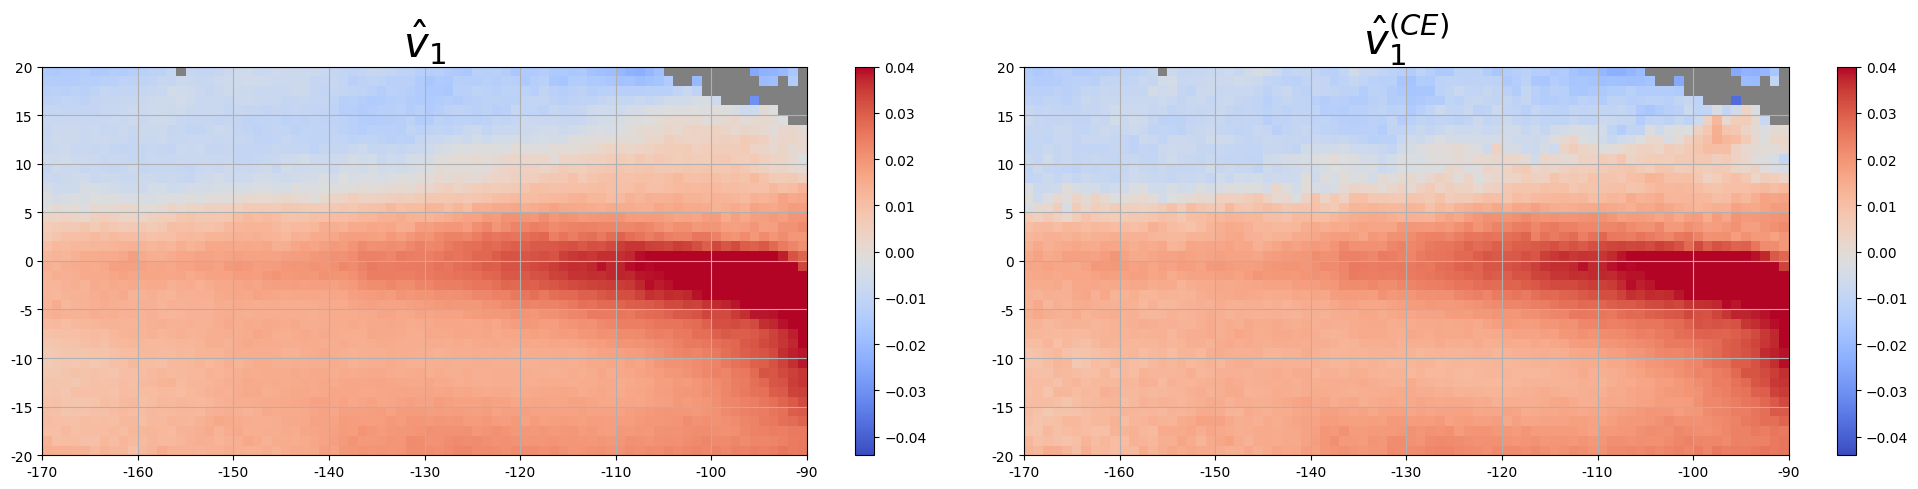

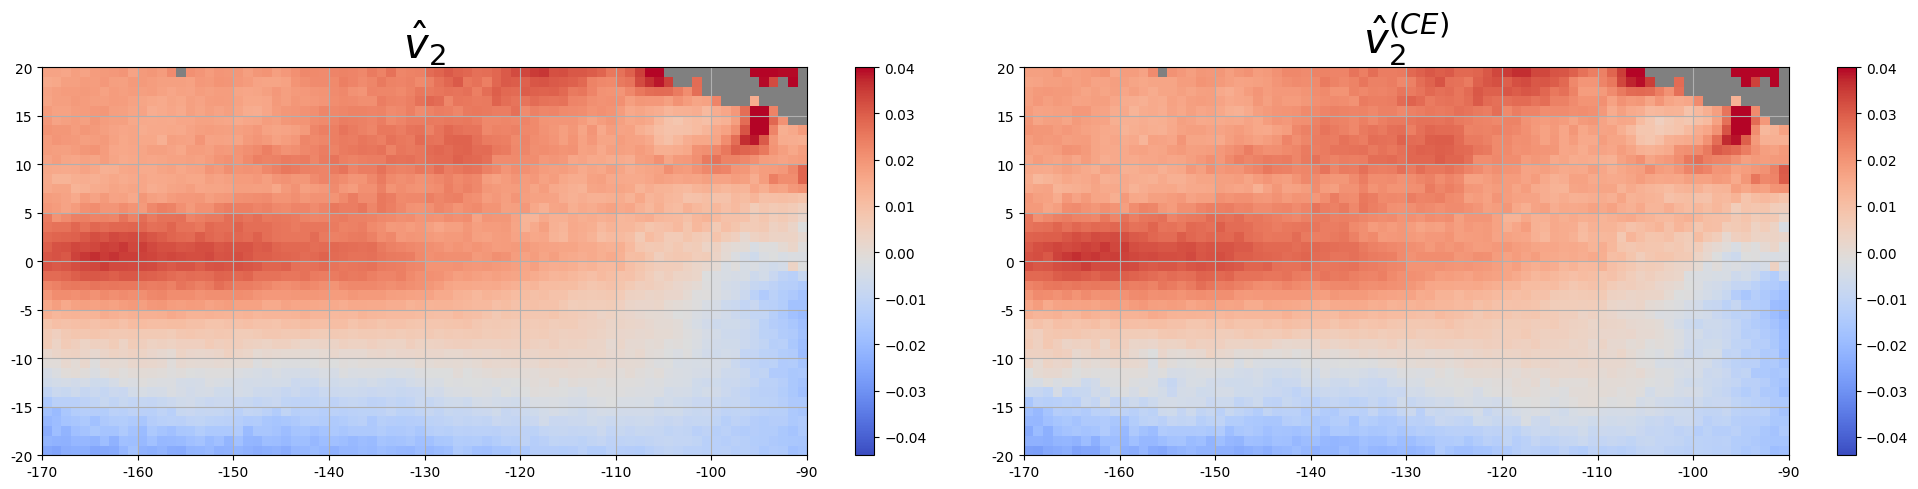

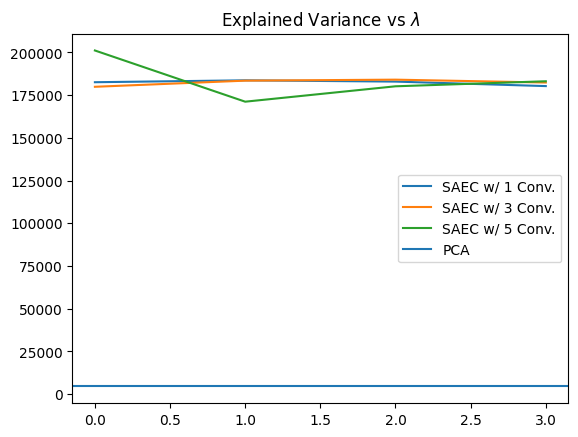

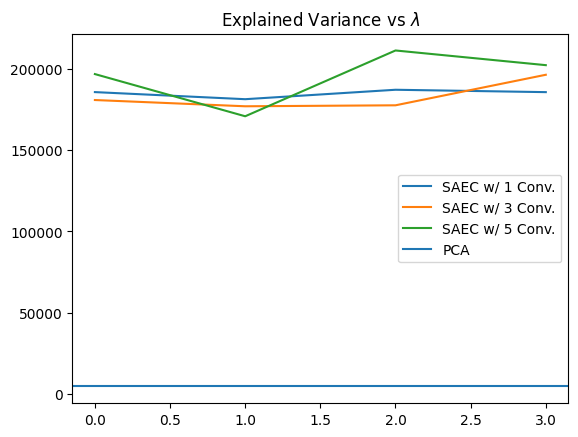

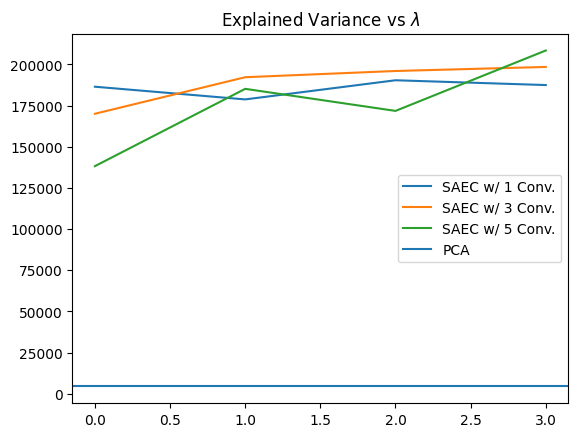

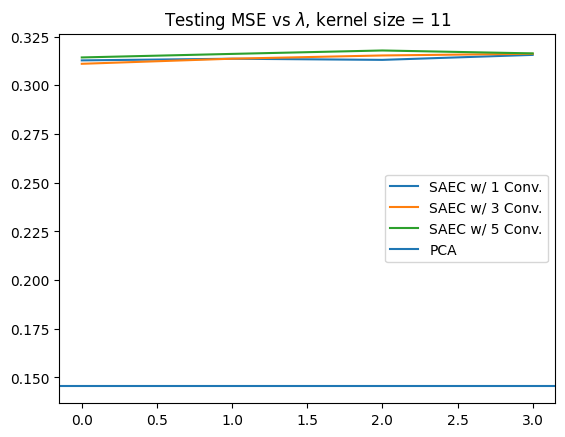

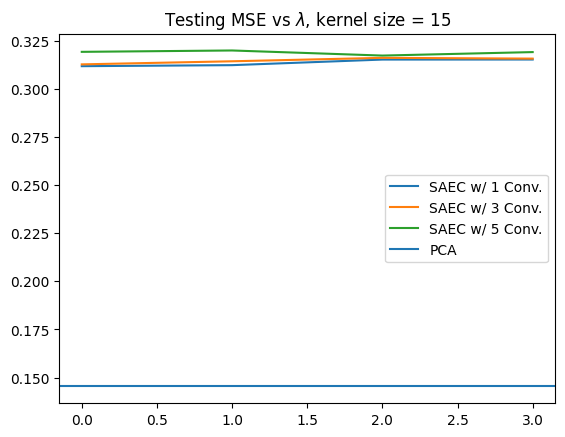

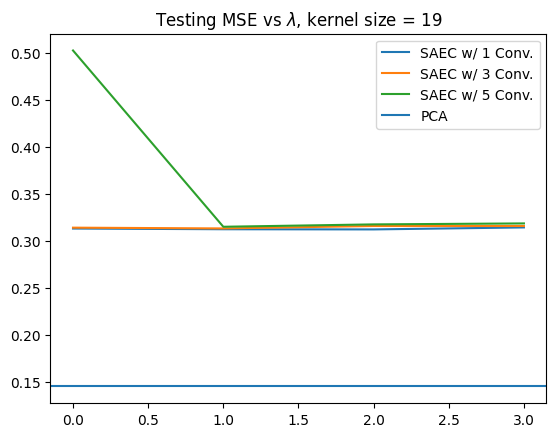

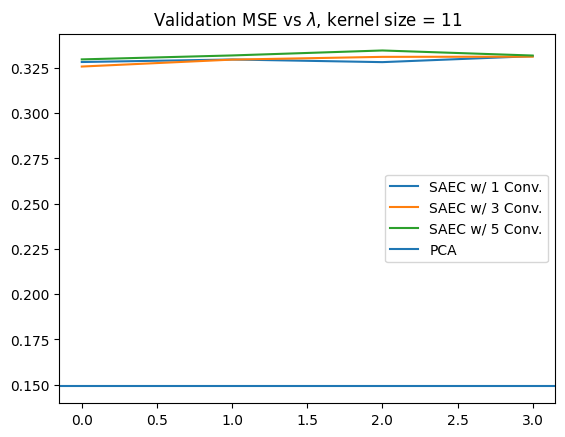

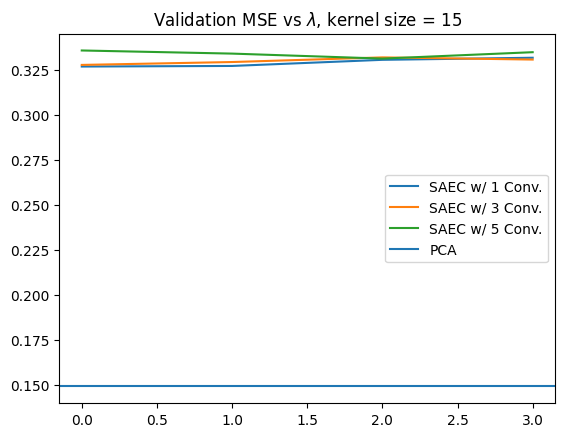

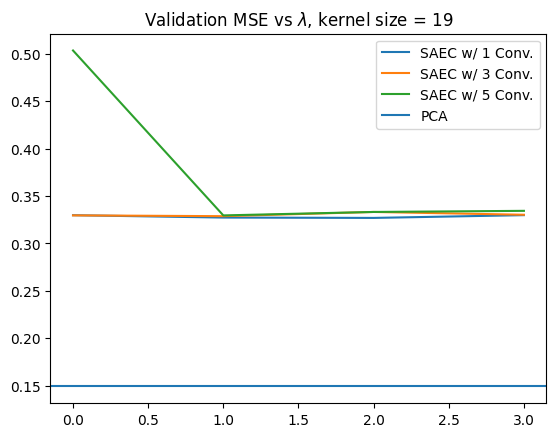

PCA Prediction RSS = 0.1452586846622004, Ncomp = 20
SAE Prediction RSS = 0.14116284002200025, lambda = 0.0, Ncomp = 20
CAE 1 Prediction RSS = 0.14134765834772148, lambda = 0, filter = 11, Ncomp = 20
CAE 2 Prediction RSS = 0.14254056293904557, lambda = 0, filter = 11, Ncomp = 20
CAE 4 Prediction RSS = 0.14317290780286712, lambda = 0, filter = 11, Ncomp = 19


In [ ]:
ncomps = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
pcaresindex, sresindex, cres1index, cres3index, cres5index, pcabestloading, saephi, eaephi1, eaephi3, eaephi5, vressaec1, vressaec3, vressaec5, tressaec1, tressaec3, tressaec5, saecvar1, saecvar3, saecvar5, respcas, tressae, tressae, tressaec1, tressaec3, tressaec5 = spatialAE2D(Y = np.array(result_data_imputed_pac), ncomp = ncomps ,activations = None, epoches = 100, padding0 = 'same', data_idx = 'Pacific Ocean')


<ipython-input-63-12d70dc61d7b>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
<ipython-input-63-12d70dc61d7b>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-63-12d70dc61d7b>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])
<ipython-input-63-12d70dc61d7b>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
<ipython-input-63-12d70dc61d7b>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([-20, -15, -10

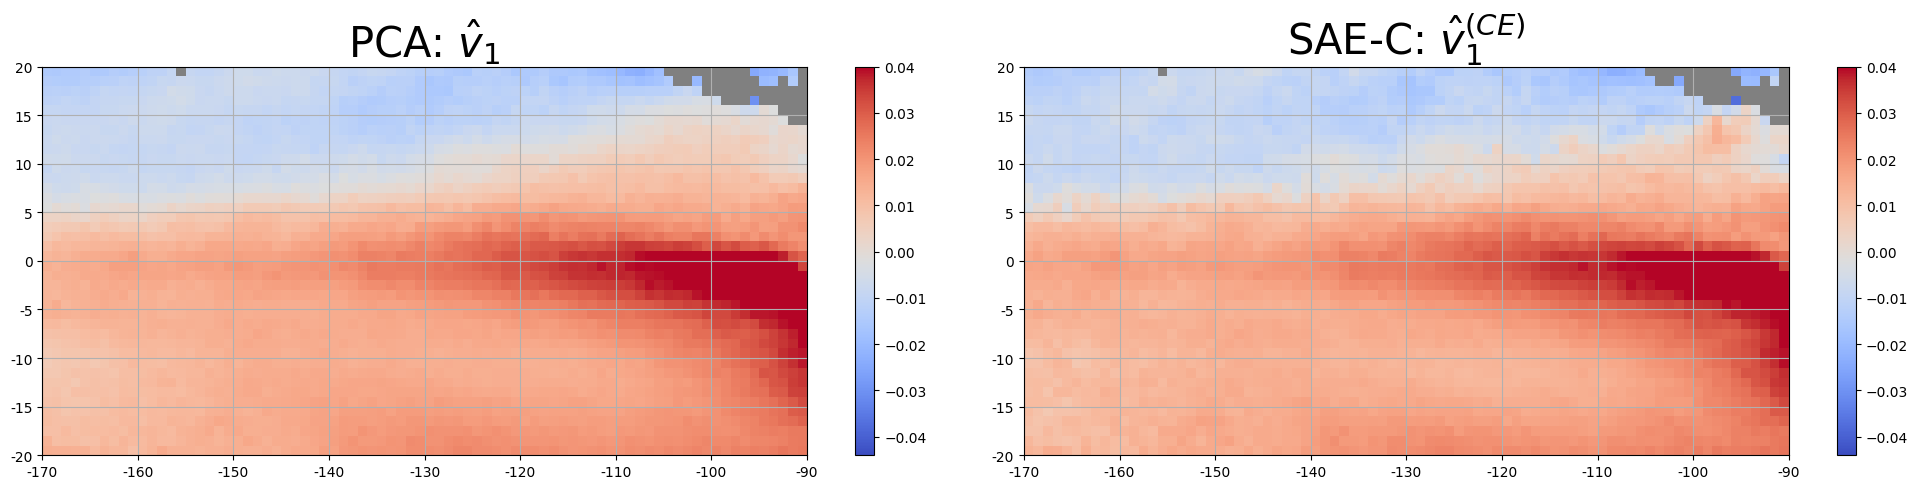

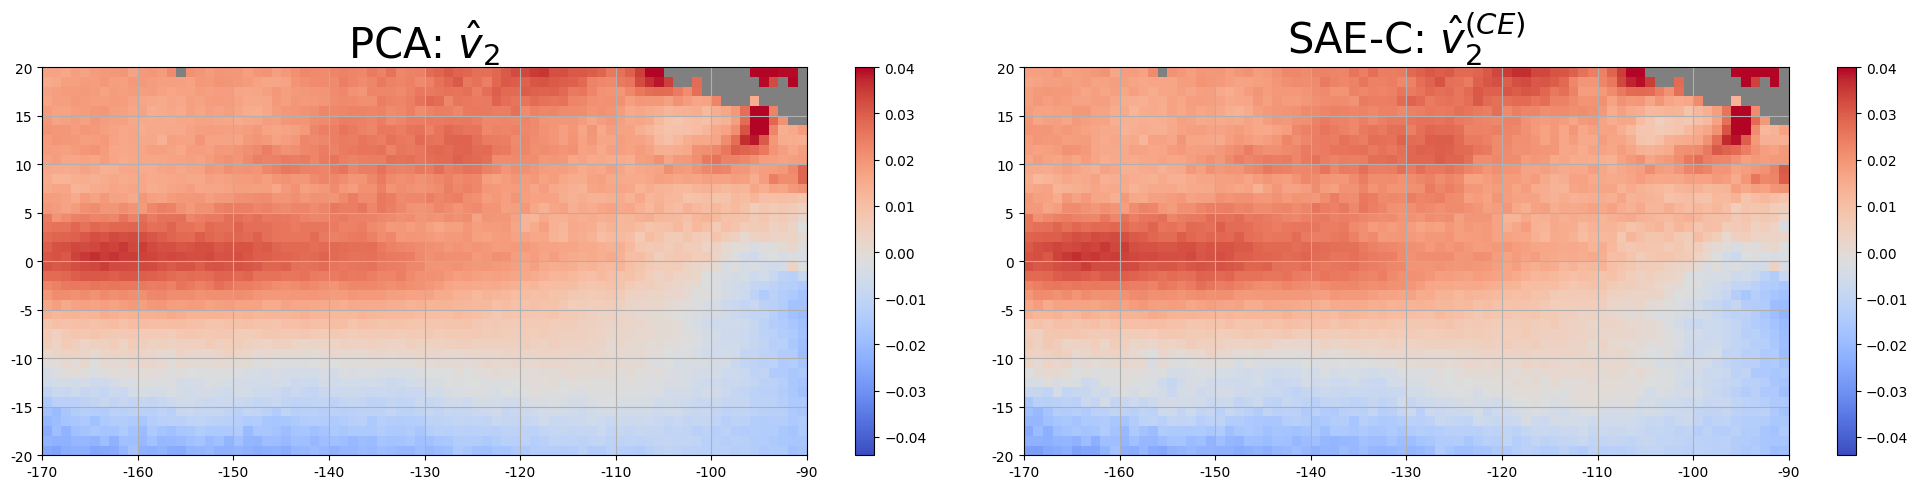

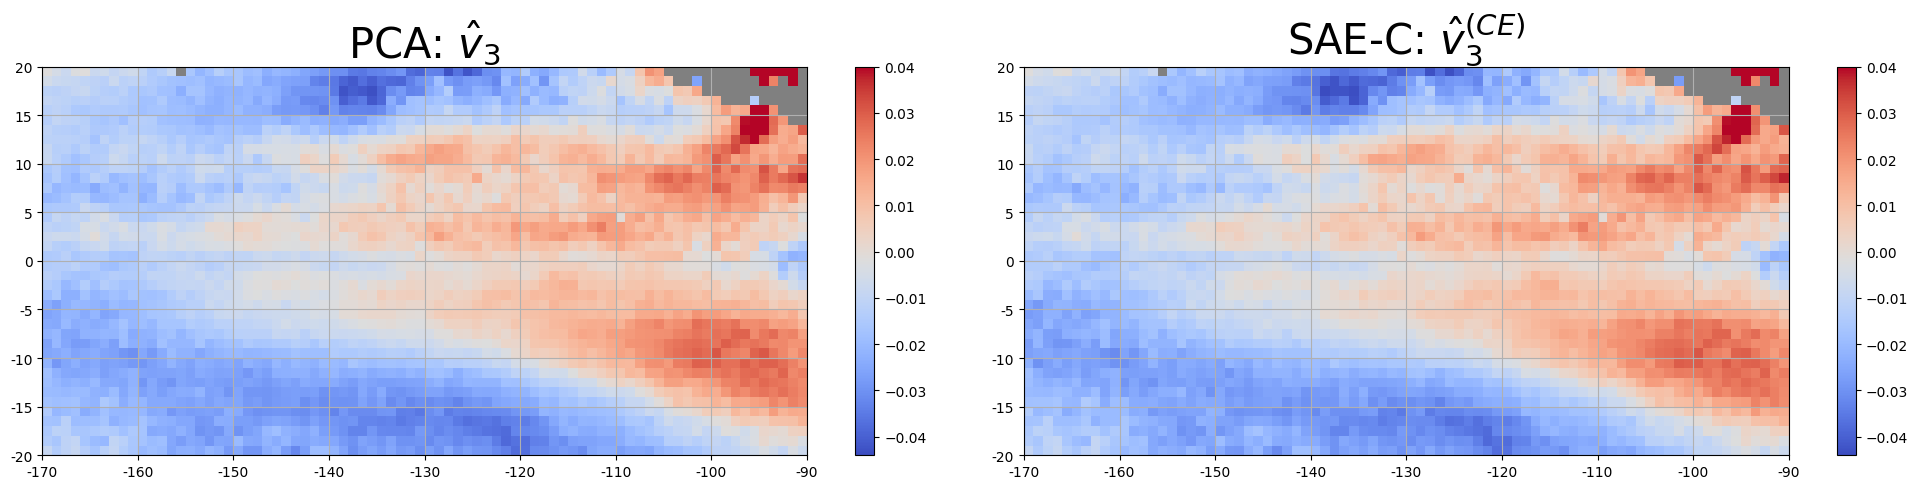

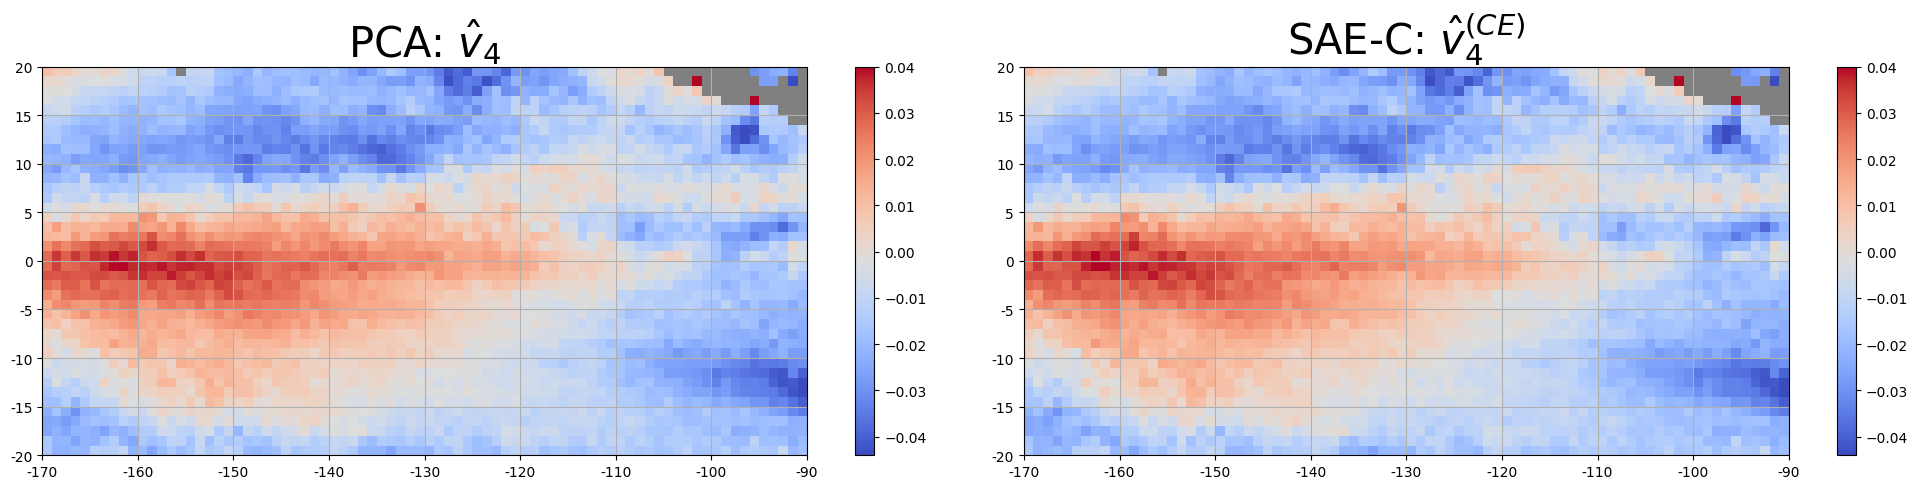

In [ ]:
vmaxs = []
vmins = []
Y = np.array(result_data_imputed_pac)
dimx,dimy = Y.shape[1],Y.shape[2]
data_idx = 'Pacific Ocean'
for k in range(20):
  vmaxs.append(max(pcabestloading[k]))
  vmins.append(min(pcabestloading[k]))
vmax = max(vmaxs)
vmin = min(vmins)
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad(color='gray')
for i in range(4):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    plt.subplots_adjust(wspace=0.5)

    loadingpca = pcabestloading[i]
    if data_idx == 'Indian Ocean':
      loadingpca[zero_indices_union_ind] = np.nan
    if data_idx == 'Atlantic Ocean':
      loadingpca[zero_indices_union_alt] = np.nan
    if data_idx == 'Pacific Ocean':
      loadingpca[zero_indices_union_pac] = np.nan
    loadingpca = np.flipud(loadingpca)
    # PCA loading plots
    if np.max(np.abs(pcabestloading[i])) == -np.min(pcabestloading[i]):
        pcabestloading[i] = -pcabestloading[i]
    img = axes[0].pcolormesh(np.fliplr(np.reshape(loadingpca, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
    axes[0].set_title(fr'PCA: $\hat{{v}}_{{{i+1}}}$', fontsize = 30 )

    '''
    axes[0].set_xticks(np.linspace(0, dimx-1, 9))
    axes[0].set_yticks(np.linspace(0, dimy-1, 5))
    '''
    if data_idx == 'Indian Ocean':
      axes[0].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
    if data_idx == 'Atalantic Ocean':
      axes[0].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
    if data_idx == 'Pacific Ocean':
      axes[0].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
    axes[0].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

    axes[0].grid()
    fig.colorbar(img, ax=axes[0])


    if np.argmin([cres1index, cres3index, cres5index]) == 0:
        # SCAE loading plots
        loadingae1 = eaephi1[:, i]
        if data_idx == 'Indian Ocean':
          loadingae1[zero_indices_union_ind] = np.nan
        if data_idx == 'Atlantic Ocean':
          loadingae1[zero_indices_union_alt] = np.nan
        if data_idx == 'Pacific Ocean':
          loadingae1[zero_indices_union_pac] = np.nan
        loadingae1 = np.flipud(loadingae1)
        if np.max(np.abs(eaephi1[:, i])) == -np.min(eaephi1[:, i]):
            eaephi1[:, i] = -eaephi1[:, i]
        img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae1, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
        axes[1].set_title(fr'SAE-C: $\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )

        '''
        axes[1].set_xticks(np.linspace(0, dimx-1, 9))
        axes[1].set_yticks(np.linspace(0, dimy-1, 5))
        '''
        if data_idx == 'Indian Ocean':
          axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
        if data_idx == 'Atalantic Ocean':
          axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
        if data_idx == 'Pacific Ocean':
          axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
        axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

        axes[1].grid()
        fig.colorbar(img, ax=axes[1])

        plt.tight_layout()
        plt.show()
    if np.argmin([cres1index, cres3index, cres5index]) == 1:
        # SCAE loading plots
        loadingae3 = eaephi3[:, i]
        if data_idx == 'Indian Ocean':
          loadingae3[zero_indices_union_ind] = np.nan
        if data_idx == 'Atlantic Ocean':
          loadingae3[zero_indices_union_alt] = np.nan
        if data_idx == 'Pacific Ocean':
          loadingae3[zero_indices_union_pac] = np.nan
        loadingae3 = np.flipud(loadingae3)
        if np.max(np.abs(eaephi3[:, i])) == -np.min(eaephi3[:, i]):
            eaephi3[:, i] = -eaephi3[:, i]
        img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae3, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
        axes[1].set_title(fr'SAE-C: $\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )
        '''
        axes[1].set_xticks(np.linspace(0, dimx-1, 9))
        axes[1].set_yticks(np.linspace(0, dimy-1, 5))
        '''
        if data_idx == 'Indian Ocean':
          axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
        if data_idx == 'Atalantic Ocean':
          axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
        if data_idx == 'Pacific Ocean':
          axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
        axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])


        axes[1].grid()
        fig.colorbar(img, ax=axes[1])

        plt.tight_layout()
        plt.show()
    if np.argmin([cres1index, cres3index, cres5index]) == 2:
        # SCAE loading plots
        loadingae5 = eaephi5[:, i]
        if data_idx == 'Indian Ocean':
          loadingae5[zero_indices_union_ind] = np.nan
        if data_idx == 'Atlantic Ocean':
          loadingae5[zero_indices_union_alt] = np.nan
        if data_idx == 'Pacific Ocean':
          loadingae5[zero_indices_union_pac] = np.nan
        loadingae5 = np.flipud(loadingae5)
        if np.max(np.abs(eaephi5[:, i])) == -np.min(eaephi5[:, i]):
            eaephi5[:, i] = -eaephi5[:, i]
        img = axes[1].pcolormesh(np.fliplr(np.reshape(loadingae5, (dimx,dimy))), cmap=cmap, vmax=-0.04, vmin=0.04)
        axes[1].set_title(fr'SAE-C: $\hat{{v}}_{{{i+1}}}^{{(CE)}}$', fontsize = 30 )
        '''
        axes[1].set_xticks(np.linspace(0, dimx-1, 9))
        axes[1].set_yticks(np.linspace(0, dimy-1, 5))
        '''
        if data_idx == 'Indian Ocean':
          axes[1].set_xticklabels([40, 50, 60, 70, 80, 90, 100, 110, 120])
        if data_idx == 'Atalantic Ocean':
          axes[1].set_xticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10])
        if data_idx == 'Pacific Ocean':
          axes[1].set_xticklabels([-170, -160, -150, -140, -130, -120, -110, -100, -90])
        axes[1].set_yticklabels([-20, -15, -10, -5, 0, 5, 10,15, 20])

        axes[1].grid()
        fig.colorbar(img, ax=axes[1])

        plt.tight_layout()
        plt.show()


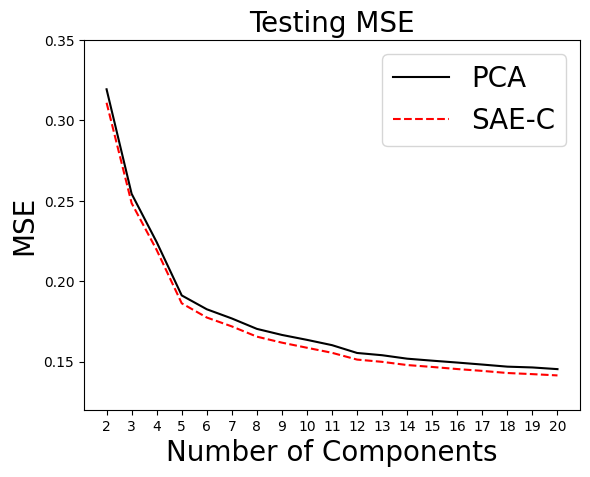

In [ ]:
#Testing MSE
import pandas as pd
testingmsesind = pd.read_csv('/content/drive/MyDrive/master/20240704/testingmses_pca_ncomp20test.csv')

minframeind = []
minframepac = []
for i in range(19):
  minframeind.append([np.min(testingmsesind.iloc[i*12:i*12+12,1]),np.min(np.min(testingmsesind.iloc[i*12:i*12+12,4:]))])

  #minframepac.append([np.min(testingmsespac.iloc[i*18:i*18+18,1:4])[0],np.min(np.min(testingmsespac.iloc[i*18:i*18+18,4:]))])
minframeind
a = pd.DataFrame(minframeind)
a.columns = ['PCA','SAE-C']

# 繪製第一張圖
plt.plot(a.iloc[:,0], color='black', linestyle='-')  # 第一條線，黑色實線
plt.plot(a.iloc[:,1], color='red', linestyle='--')  # 第二條線，紅色虛線

# 設定 x 座標的標籤
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], ['2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

# 加上圖例
plt.legend(['PCA', 'SAE-C'], loc='best',fontsize = 20)
plt.title('Testing MSE',fontsize = 20)
plt.xlabel('Number of Components',fontsize = 20)
plt.ylabel('MSE',fontsize = 20)
plt.ylim(0.12,0.35)
# 顯示第一張圖
plt.show()

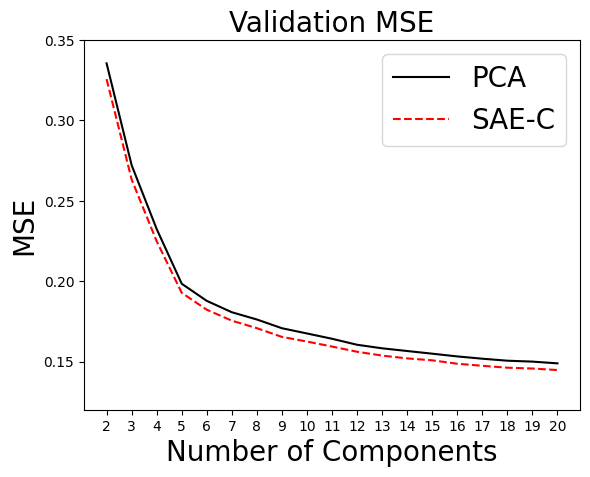

In [ ]:
#Validation MSE
import pandas as pd
validpac = pd.read_csv('/content/drive/MyDrive/master/20240704/testingmses_pca_ncomp20valid.csv')

minframeind = []
minframepac = []
for i in range(19):
  minframeind.append([np.min(validpac.iloc[i*12:i*12+12,1]),np.min(np.min(validpac.iloc[i*12:i*12+12,4:]))])

  #minframepac.append([np.min(testingmsespac.iloc[i*18:i*18+18,1:4])[0],np.min(np.min(testingmsespac.iloc[i*18:i*18+18,4:]))])
minframeind
a = pd.DataFrame(minframeind)
a.columns = ['PCA','SAE-C']

# 繪製第一張圖
plt.plot(a.iloc[:,0], color='black', linestyle='-')  # 第一條線，黑色實線
plt.plot(a.iloc[:,1], color='red', linestyle='--')  # 第二條線，紅色虛線

# 設定 x 座標的標籤
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], ['2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

# 加上圖例
plt.legend(['PCA', 'SAE-C'], loc='best',fontsize = 20)
plt.title('Validation MSE',fontsize = 20)
plt.xlabel('Number of Components',fontsize = 20)
plt.ylabel('MSE',fontsize = 20)
plt.ylim(0.12,0.35)
# 顯示第一張圖
plt.show()